In [1]:
import torch
from torch import embedding, nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
from tqdm import tqdm
from preprocessing import *
from baseline import FaceRecognizer
# train_data: tuple of length 320, each is a matrix represents a picture
# train_target: tuple of length 320, each is a label
# For training, there are 40 classes, each has 8 pictures
# For testing, there are 40 classes, each has 2 pictures

/home/jupyter-zhw622/DeepLearning/preprocessing.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_data = torch.tensor(train_data)


In [2]:
fr = FaceRecognizer()
fr.forward(train_data[1])
print(train_data[1].shape)

torch.Size([1, 1, 64, 64])


In [3]:
import torch_dct as dct

In [4]:
epsilon = 1e-8

In [5]:
print(train_data[1][0][0])

tensor([[-1.8057, -1.1350, -0.5841,  ..., -0.6799, -0.6799, -0.9434],
        [-1.7578, -1.2308, -0.7278,  ..., -0.6080, -0.7278, -0.8715],
        [-1.7099, -1.3027, -0.7996,  ..., -0.6320, -0.7517, -0.9194],
        ...,
        [ 1.7633,  1.6675,  1.7154,  ..., -0.5601, -0.5601, -0.4883],
        [ 1.7873,  1.6675,  1.7394,  ..., -0.5601, -0.5601, -0.4643],
        [ 1.7633,  1.7394,  1.7154,  ..., -0.5362, -0.5122, -0.4883]])


In [6]:
print(train_data[1][0][0]+epsilon)

tensor([[-1.8057, -1.1350, -0.5841,  ..., -0.6799, -0.6799, -0.9434],
        [-1.7578, -1.2308, -0.7278,  ..., -0.6080, -0.7278, -0.8715],
        [-1.7099, -1.3027, -0.7996,  ..., -0.6320, -0.7517, -0.9194],
        ...,
        [ 1.7633,  1.6675,  1.7154,  ..., -0.5601, -0.5601, -0.4883],
        [ 1.7873,  1.6675,  1.7394,  ..., -0.5601, -0.5601, -0.4643],
        [ 1.7633,  1.7394,  1.7154,  ..., -0.5362, -0.5122, -0.4883]])


In [7]:
for i in range(train_data.shape[0]):
    train_data[i] = dct.dct_2d(train_data[i])
    train_data[i][0][0] += epsilon
for j in range(test_data.shape[0]):
    test_data[j] = dct.dct_2d(test_data[j])

In [8]:


num_epochs_train = 0

def train(model, data, targets, optimizer, criterion,  num_epochs=0):  
    global num_epochs_train 
#     if num_epochs_train == 1:
#         tmp = optimizer.state_dict()
#         tmp["param_groups"][0]["lr"] = 0.0005
    model.train()
    epoch_loss = 0
    sampling = list(range(train_data.shape[0]))
    random.shuffle(sampling)
    print("training ...")
    for i, selected_batch_index in tqdm(enumerate(sampling)):
        optimizer.zero_grad()
        z = fr.forward(data[selected_batch_index])
        loss = 0       
        loss=criterion(z,targets[selected_batch_index].long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    num_epochs_train += 1
    return epoch_loss

confusion_matrix = []
num_epochs = 0
def evaluate(model, data, targets, criterion, num_targets): 
    model.eval()
    epoch_loss = 0
    sampling = list(range(data.shape[0]))
    random.shuffle(sampling)
    confusion_matrix.append(torch.zeros(num_targets,num_targets))
    global num_epochs
    for i, selected_batch_index in tqdm(enumerate(sampling)):
        z = fr.forward(data[selected_batch_index])
        loss = 0
        loss=criterion(z,targets[selected_batch_index].long())
        # print(targets[selected_batch_index].long())
        epoch_loss += loss.item()
        # Load in confusion_matrix
        for i in range(data[selected_batch_index].shape[0]):
            row = targets[selected_batch_index].long()
            col = torch.argmax(z[i])
            
#             print(num_epochs,row.item(),col.item())
#             print(confusion_matrix)
            confusion_matrix[num_epochs][row.item()][col.item()] += 1
     
    num_epochs += 1
        
    return epoch_loss
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [9]:
# optimizer = optim.Adam(fr.parameters())
# criterion = nn.CrossEntropyLoss(reduction = 'sum')
training_losses = []
test_losses = []

In [10]:
def train_eps(ep, lr, reg):
    optimizer = optim.SGD(fr.parameters(), lr=lr, momentum=0.9, weight_decay=reg, nesterov=False)
    criterion = nn.CrossEntropyLoss(reduction = 'sum')
    N_EPOCHS = ep
    best_test_loss = 999999
    for epoch in range(N_EPOCHS):  
        print("epoch start: ", epoch)  
        start_time = time.time()
        training_loss = train(fr, train_data, train_target, optimizer, criterion)
        training_losses.append(training_loss)
        test_loss = evaluate(fr, test_data, test_target, criterion, 40)
        test_losses.append(test_loss)  
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        if test_loss < best_test_loss:
            best_test_loss = test_loss 
            torch.save(fr.state_dict(), 'model_1e-8_1e-4_1e-2_new_2.pt')


        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', end='')
        print(f'\tTrain Loss: {training_loss:.3f} | Test Loss: {test_loss:.3f}')

In [11]:
train_eps(1000, 0.0001, 0.01)

0it [00:00, ?it/s]

epoch start:  0
training ...


280it [00:04, 57.83it/s]
120it [00:00, 1624.26it/s]
16it [00:00, 154.20it/s]

Epoch: 01 | Time: 0m 4s	Train Loss: 1421.258 | Test Loss: 441.087
epoch start:  1
training ...


280it [00:01, 149.77it/s]
120it [00:00, 1385.43it/s]
17it [00:00, 168.70it/s]

Epoch: 02 | Time: 0m 1s	Train Loss: 1033.148 | Test Loss: 441.070
epoch start:  2
training ...


280it [00:01, 151.66it/s]
120it [00:00, 2001.12it/s]
22it [00:00, 213.61it/s]

Epoch: 03 | Time: 0m 1s	Train Loss: 1033.142 | Test Loss: 441.016
epoch start:  3
training ...


280it [00:01, 231.17it/s]
120it [00:00, 1631.12it/s]
18it [00:00, 167.45it/s]

Epoch: 04 | Time: 0m 1s	Train Loss: 1033.131 | Test Loss: 440.948
epoch start:  4
training ...


280it [00:01, 151.83it/s]
120it [00:00, 1677.26it/s]
16it [00:00, 148.93it/s]

Epoch: 05 | Time: 0m 1s	Train Loss: 1033.130 | Test Loss: 440.913
epoch start:  5
training ...


280it [00:01, 149.53it/s]
120it [00:00, 1335.67it/s]
19it [00:00, 186.71it/s]

Epoch: 06 | Time: 0m 1s	Train Loss: 1033.117 | Test Loss: 440.862
epoch start:  6
training ...


280it [00:01, 152.30it/s]
120it [00:00, 1637.44it/s]
14it [00:00, 137.86it/s]

Epoch: 07 | Time: 0m 1s	Train Loss: 1033.123 | Test Loss: 440.827
epoch start:  7
training ...


280it [00:01, 148.80it/s]
120it [00:00, 1595.03it/s]
15it [00:00, 148.46it/s]

Epoch: 08 | Time: 0m 1s	Train Loss: 1033.100 | Test Loss: 440.778
epoch start:  8
training ...


280it [00:01, 148.43it/s]
120it [00:00, 1630.45it/s]
16it [00:00, 157.18it/s]

Epoch: 09 | Time: 0m 1s	Train Loss: 1033.113 | Test Loss: 440.666
epoch start:  9
training ...


280it [00:01, 156.09it/s]
120it [00:00, 1769.00it/s]
14it [00:00, 133.65it/s]

Epoch: 10 | Time: 0m 1s	Train Loss: 1033.086 | Test Loss: 440.583
epoch start:  10
training ...


280it [00:01, 152.57it/s]
120it [00:00, 1672.12it/s]
17it [00:00, 160.30it/s]

Epoch: 11 | Time: 0m 1s	Train Loss: 1033.075 | Test Loss: 440.508
epoch start:  11
training ...


280it [00:01, 148.70it/s]
120it [00:00, 1894.25it/s]
16it [00:00, 153.53it/s]

Epoch: 12 | Time: 0m 1s	Train Loss: 1033.063 | Test Loss: 440.387
epoch start:  12
training ...


280it [00:01, 191.57it/s]
120it [00:00, 1628.86it/s]
16it [00:00, 152.51it/s]

Epoch: 13 | Time: 0m 1s	Train Loss: 1033.054 | Test Loss: 440.293
epoch start:  13
training ...


280it [00:01, 150.46it/s]
120it [00:00, 1761.04it/s]
17it [00:00, 159.28it/s]

Epoch: 14 | Time: 0m 1s	Train Loss: 1040.262 | Test Loss: 442.704
epoch start:  14
training ...


280it [00:01, 149.35it/s]
120it [00:00, 1330.87it/s]
15it [00:00, 149.13it/s]

Epoch: 15 | Time: 0m 1s	Train Loss: 1033.006 | Test Loss: 442.704
epoch start:  15
training ...


280it [00:01, 157.59it/s]
120it [00:00, 1579.09it/s]
16it [00:00, 156.51it/s]

Epoch: 16 | Time: 0m 1s	Train Loss: 1032.996 | Test Loss: 442.703
epoch start:  16
training ...


280it [00:01, 158.95it/s]
120it [00:00, 1669.82it/s]
19it [00:00, 188.69it/s]

Epoch: 17 | Time: 0m 1s	Train Loss: 1032.929 | Test Loss: 442.638
epoch start:  17
training ...


280it [00:01, 153.02it/s]
120it [00:00, 1630.41it/s]
15it [00:00, 147.46it/s]

Epoch: 18 | Time: 0m 1s	Train Loss: 1032.845 | Test Loss: 442.520
epoch start:  18
training ...


280it [00:01, 149.99it/s]
120it [00:00, 1716.31it/s]
16it [00:00, 150.87it/s]

Epoch: 19 | Time: 0m 1s	Train Loss: 1032.778 | Test Loss: 442.492
epoch start:  19
training ...


280it [00:01, 151.37it/s]
120it [00:00, 1314.71it/s]
15it [00:00, 148.07it/s]

Epoch: 20 | Time: 0m 1s	Train Loss: 1033.928 | Test Loss: 442.706
epoch start:  20
training ...


280it [00:01, 151.96it/s]
120it [00:00, 1717.49it/s]
15it [00:00, 149.50it/s]

Epoch: 21 | Time: 0m 1s	Train Loss: 1032.956 | Test Loss: 442.708
epoch start:  21
training ...


280it [00:01, 152.33it/s]
120it [00:00, 1345.21it/s]
15it [00:00, 147.76it/s]

Epoch: 22 | Time: 0m 1s	Train Loss: 1032.940 | Test Loss: 442.708
epoch start:  22
training ...


280it [00:01, 152.26it/s]
120it [00:00, 1325.68it/s]
15it [00:00, 140.55it/s]

Epoch: 23 | Time: 0m 1s	Train Loss: 1032.896 | Test Loss: 442.710
epoch start:  23
training ...


280it [00:01, 147.88it/s]
120it [00:00, 1681.81it/s]
16it [00:00, 157.28it/s]

Epoch: 24 | Time: 0m 1s	Train Loss: 1032.865 | Test Loss: 442.710
epoch start:  24
training ...


280it [00:01, 147.29it/s]
120it [00:00, 1370.00it/s]
15it [00:00, 147.60it/s]

Epoch: 25 | Time: 0m 1s	Train Loss: 1032.817 | Test Loss: 442.713
epoch start:  25
training ...


280it [00:01, 155.73it/s]
120it [00:00, 1753.35it/s]
16it [00:00, 159.40it/s]

Epoch: 26 | Time: 0m 1s	Train Loss: 1032.750 | Test Loss: 442.721
epoch start:  26
training ...


280it [00:01, 150.22it/s]
120it [00:00, 1715.99it/s]
16it [00:00, 155.76it/s]

Epoch: 27 | Time: 0m 1s	Train Loss: 1032.653 | Test Loss: 442.725
epoch start:  27
training ...


280it [00:01, 158.12it/s]
120it [00:00, 1421.06it/s]
16it [00:00, 151.05it/s]

Epoch: 28 | Time: 0m 1s	Train Loss: 1032.537 | Test Loss: 442.728
epoch start:  28
training ...


280it [00:01, 151.68it/s]
120it [00:00, 1735.27it/s]
16it [00:00, 154.40it/s]

Epoch: 29 | Time: 0m 1s	Train Loss: 1032.304 | Test Loss: 442.722
epoch start:  29
training ...


280it [00:01, 152.48it/s]
120it [00:00, 1664.13it/s]
16it [00:00, 159.44it/s]

Epoch: 30 | Time: 0m 1s	Train Loss: 1031.902 | Test Loss: 442.724
epoch start:  30
training ...


280it [00:01, 189.78it/s]
120it [00:00, 1639.84it/s]
24it [00:00, 238.46it/s]

Epoch: 31 | Time: 0m 1s	Train Loss: 1031.086 | Test Loss: 442.811
epoch start:  31
training ...


280it [00:01, 218.52it/s]
120it [00:00, 1710.62it/s]
18it [00:00, 173.25it/s]

Epoch: 32 | Time: 0m 1s	Train Loss: 1028.281 | Test Loss: 449.102
epoch start:  32
training ...


280it [00:01, 161.98it/s]
120it [00:00, 1586.82it/s]
16it [00:00, 153.43it/s]

Epoch: 33 | Time: 0m 1s	Train Loss: 1018.845 | Test Loss: 442.767
epoch start:  33
training ...


280it [00:01, 213.97it/s]
120it [00:00, 1594.98it/s]
16it [00:00, 153.47it/s]

Epoch: 34 | Time: 0m 1s	Train Loss: 993.565 | Test Loss: 433.992
epoch start:  34
training ...


280it [00:01, 155.11it/s]
120it [00:00, 1673.66it/s]
14it [00:00, 138.41it/s]

Epoch: 35 | Time: 0m 1s	Train Loss: 920.057 | Test Loss: 397.822
epoch start:  35
training ...


280it [00:01, 161.67it/s]
120it [00:00, 1535.88it/s]
18it [00:00, 169.81it/s]

Epoch: 36 | Time: 0m 1s	Train Loss: 828.983 | Test Loss: 383.100
epoch start:  36
training ...


280it [00:01, 168.26it/s]
120it [00:00, 1586.90it/s]
17it [00:00, 167.72it/s]

Epoch: 37 | Time: 0m 1s	Train Loss: 643.419 | Test Loss: 364.198
epoch start:  37
training ...


280it [00:01, 166.40it/s]
120it [00:00, 1609.51it/s]
21it [00:00, 202.17it/s]

Epoch: 38 | Time: 0m 1s	Train Loss: 500.935 | Test Loss: 372.176
epoch start:  38
training ...


280it [00:01, 173.22it/s]
120it [00:00, 1523.15it/s]
19it [00:00, 178.08it/s]

Epoch: 39 | Time: 0m 1s	Train Loss: 341.398 | Test Loss: 411.302
epoch start:  39
training ...


280it [00:01, 168.20it/s]
120it [00:00, 1747.01it/s]
18it [00:00, 168.43it/s]

Epoch: 40 | Time: 0m 1s	Train Loss: 276.418 | Test Loss: 401.867
epoch start:  40
training ...


280it [00:01, 154.50it/s]
120it [00:00, 1671.64it/s]
23it [00:00, 226.57it/s]

Epoch: 41 | Time: 0m 1s	Train Loss: 152.160 | Test Loss: 409.324
epoch start:  41
training ...


280it [00:01, 233.15it/s]
120it [00:00, 1574.78it/s]
24it [00:00, 234.39it/s]

Epoch: 42 | Time: 0m 1s	Train Loss: 129.794 | Test Loss: 401.562
epoch start:  42
training ...


280it [00:01, 233.12it/s]
120it [00:00, 1484.66it/s]
24it [00:00, 232.17it/s]

Epoch: 43 | Time: 0m 1s	Train Loss: 161.467 | Test Loss: 638.087
epoch start:  43
training ...


280it [00:01, 238.68it/s]
120it [00:00, 1426.00it/s]
24it [00:00, 229.91it/s]

Epoch: 44 | Time: 0m 1s	Train Loss: 201.024 | Test Loss: 544.835
epoch start:  44
training ...


280it [00:01, 167.01it/s]
120it [00:00, 1775.65it/s]
15it [00:00, 143.86it/s]

Epoch: 45 | Time: 0m 1s	Train Loss: 70.434 | Test Loss: 648.792
epoch start:  45
training ...


280it [00:01, 194.10it/s]
120it [00:00, 1594.37it/s]
17it [00:00, 162.95it/s]

Epoch: 46 | Time: 0m 1s	Train Loss: 42.109 | Test Loss: 444.964
epoch start:  46
training ...


280it [00:01, 175.33it/s]
120it [00:00, 1590.49it/s]
16it [00:00, 159.89it/s]

Epoch: 47 | Time: 0m 1s	Train Loss: 2.384 | Test Loss: 450.693
epoch start:  47
training ...


280it [00:01, 160.52it/s]
120it [00:00, 1654.76it/s]
14it [00:00, 135.36it/s]

Epoch: 48 | Time: 0m 1s	Train Loss: 0.684 | Test Loss: 449.594
epoch start:  48
training ...


280it [00:01, 184.59it/s]
120it [00:00, 1603.01it/s]
16it [00:00, 159.39it/s]

Epoch: 49 | Time: 0m 1s	Train Loss: 0.550 | Test Loss: 449.976
epoch start:  49
training ...


280it [00:01, 153.18it/s]
120it [00:00, 1644.89it/s]
17it [00:00, 162.30it/s]

Epoch: 50 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 449.650
epoch start:  50
training ...


280it [00:01, 152.66it/s]
120it [00:00, 1655.86it/s]
16it [00:00, 156.51it/s]

Epoch: 51 | Time: 0m 1s	Train Loss: 0.433 | Test Loss: 448.680
epoch start:  51
training ...


280it [00:01, 148.00it/s]
120it [00:00, 1749.91it/s]
15it [00:00, 149.98it/s]

Epoch: 52 | Time: 0m 1s	Train Loss: 0.402 | Test Loss: 447.630
epoch start:  52
training ...


280it [00:01, 152.59it/s]
120it [00:00, 1709.13it/s]
15it [00:00, 142.52it/s]

Epoch: 53 | Time: 0m 1s	Train Loss: 0.378 | Test Loss: 444.968
epoch start:  53
training ...


280it [00:01, 149.71it/s]
120it [00:00, 1696.57it/s]
17it [00:00, 165.69it/s]

Epoch: 54 | Time: 0m 1s	Train Loss: 0.362 | Test Loss: 444.383
epoch start:  54
training ...


280it [00:01, 153.81it/s]
120it [00:00, 1723.54it/s]
17it [00:00, 160.68it/s]

Epoch: 55 | Time: 0m 1s	Train Loss: 0.345 | Test Loss: 443.268
epoch start:  55
training ...


280it [00:01, 157.11it/s]
120it [00:00, 1609.82it/s]
17it [00:00, 161.39it/s]

Epoch: 56 | Time: 0m 1s	Train Loss: 0.335 | Test Loss: 441.414
epoch start:  56
training ...


280it [00:01, 147.17it/s]
120it [00:00, 1682.60it/s]
21it [00:00, 202.69it/s]

Epoch: 57 | Time: 0m 1s	Train Loss: 0.325 | Test Loss: 440.524
epoch start:  57
training ...


280it [00:01, 221.76it/s]
120it [00:00, 1620.71it/s]
22it [00:00, 212.19it/s]

Epoch: 58 | Time: 0m 1s	Train Loss: 0.318 | Test Loss: 438.315
epoch start:  58
training ...


280it [00:01, 164.57it/s]
120it [00:00, 1734.01it/s]
16it [00:00, 151.38it/s]

Epoch: 59 | Time: 0m 1s	Train Loss: 0.312 | Test Loss: 437.639
epoch start:  59
training ...


280it [00:01, 150.22it/s]
120it [00:00, 1587.46it/s]
24it [00:00, 230.10it/s]

Epoch: 60 | Time: 0m 1s	Train Loss: 0.305 | Test Loss: 435.983
epoch start:  60
training ...


280it [00:01, 161.55it/s]
120it [00:00, 1307.82it/s]
16it [00:00, 155.95it/s]

Epoch: 61 | Time: 0m 1s	Train Loss: 0.301 | Test Loss: 434.622
epoch start:  61
training ...


280it [00:01, 154.99it/s]
120it [00:00, 1347.26it/s]
16it [00:00, 152.98it/s]

Epoch: 62 | Time: 0m 1s	Train Loss: 0.294 | Test Loss: 433.704
epoch start:  62
training ...


280it [00:01, 211.11it/s]
120it [00:00, 1514.20it/s]
17it [00:00, 160.45it/s]

Epoch: 63 | Time: 0m 1s	Train Loss: 0.295 | Test Loss: 431.781
epoch start:  63
training ...


280it [00:01, 150.18it/s]
120it [00:00, 1792.27it/s]
15it [00:00, 140.54it/s]

Epoch: 64 | Time: 0m 1s	Train Loss: 0.291 | Test Loss: 430.028
epoch start:  64
training ...


280it [00:01, 152.54it/s]
120it [00:00, 1722.16it/s]
19it [00:00, 182.35it/s]

Epoch: 65 | Time: 0m 1s	Train Loss: 0.290 | Test Loss: 428.648
epoch start:  65
training ...


280it [00:01, 171.91it/s]
120it [00:00, 1684.57it/s]
16it [00:00, 152.51it/s]

Epoch: 66 | Time: 0m 1s	Train Loss: 0.288 | Test Loss: 427.250
epoch start:  66
training ...


280it [00:01, 151.17it/s]
120it [00:00, 1338.58it/s]
14it [00:00, 139.32it/s]

Epoch: 67 | Time: 0m 1s	Train Loss: 0.287 | Test Loss: 426.067
epoch start:  67
training ...


280it [00:01, 144.05it/s]
120it [00:00, 1676.36it/s]
15it [00:00, 142.99it/s]

Epoch: 68 | Time: 0m 2s	Train Loss: 0.287 | Test Loss: 424.550
epoch start:  68
training ...


280it [00:01, 162.83it/s]
120it [00:00, 1712.15it/s]
16it [00:00, 152.87it/s]

Epoch: 69 | Time: 0m 1s	Train Loss: 0.287 | Test Loss: 423.242
epoch start:  69
training ...


280it [00:01, 153.06it/s]
120it [00:00, 1733.47it/s]
16it [00:00, 154.39it/s]

Epoch: 70 | Time: 0m 1s	Train Loss: 0.284 | Test Loss: 422.032
epoch start:  70
training ...


280it [00:01, 148.84it/s]
120it [00:00, 1698.36it/s]
16it [00:00, 153.86it/s]

Epoch: 71 | Time: 0m 1s	Train Loss: 0.286 | Test Loss: 420.774
epoch start:  71
training ...


280it [00:01, 153.94it/s]
120it [00:00, 1623.17it/s]
17it [00:00, 165.38it/s]

Epoch: 72 | Time: 0m 1s	Train Loss: 0.287 | Test Loss: 419.428
epoch start:  72
training ...


280it [00:01, 155.27it/s]
120it [00:00, 1644.26it/s]
18it [00:00, 174.53it/s]

Epoch: 73 | Time: 0m 1s	Train Loss: 0.286 | Test Loss: 418.164
epoch start:  73
training ...


280it [00:01, 148.40it/s]
120it [00:00, 1740.03it/s]
15it [00:00, 143.96it/s]

Epoch: 74 | Time: 0m 1s	Train Loss: 0.289 | Test Loss: 416.892
epoch start:  74
training ...


280it [00:01, 144.19it/s]
120it [00:00, 1780.36it/s]
15it [00:00, 141.41it/s]

Epoch: 75 | Time: 0m 2s	Train Loss: 0.288 | Test Loss: 415.618
epoch start:  75
training ...


280it [00:01, 221.81it/s]
120it [00:00, 1503.90it/s]
14it [00:00, 137.16it/s]

Epoch: 76 | Time: 0m 1s	Train Loss: 0.288 | Test Loss: 413.868
epoch start:  76
training ...


280it [00:01, 150.24it/s]
120it [00:00, 1585.41it/s]
16it [00:00, 155.01it/s]

Epoch: 77 | Time: 0m 1s	Train Loss: 0.290 | Test Loss: 412.793
epoch start:  77
training ...


280it [00:01, 147.75it/s]
120it [00:00, 1714.41it/s]
17it [00:00, 161.10it/s]

Epoch: 78 | Time: 0m 1s	Train Loss: 0.291 | Test Loss: 411.463
epoch start:  78
training ...


280it [00:01, 156.96it/s]
120it [00:00, 1721.26it/s]
16it [00:00, 155.21it/s]

Epoch: 79 | Time: 0m 1s	Train Loss: 0.293 | Test Loss: 410.377
epoch start:  79
training ...


280it [00:01, 153.44it/s]
120it [00:00, 1685.11it/s]
16it [00:00, 150.49it/s]

Epoch: 80 | Time: 0m 1s	Train Loss: 0.293 | Test Loss: 409.114
epoch start:  80
training ...


280it [00:01, 151.13it/s]
120it [00:00, 1704.16it/s]
17it [00:00, 168.51it/s]

Epoch: 81 | Time: 0m 1s	Train Loss: 0.293 | Test Loss: 407.918
epoch start:  81
training ...


280it [00:01, 212.17it/s]
120it [00:00, 1426.13it/s]
18it [00:00, 166.42it/s]

Epoch: 82 | Time: 0m 1s	Train Loss: 0.297 | Test Loss: 406.758
epoch start:  82
training ...


280it [00:01, 163.27it/s]
120it [00:00, 1315.86it/s]
15it [00:00, 140.06it/s]

Epoch: 83 | Time: 0m 1s	Train Loss: 0.298 | Test Loss: 405.273
epoch start:  83
training ...


280it [00:01, 148.61it/s]
120it [00:00, 1694.94it/s]
16it [00:00, 153.47it/s]

Epoch: 84 | Time: 0m 1s	Train Loss: 0.301 | Test Loss: 403.793
epoch start:  84
training ...


280it [00:01, 154.88it/s]
120it [00:00, 1676.23it/s]
15it [00:00, 142.38it/s]

Epoch: 85 | Time: 0m 1s	Train Loss: 0.302 | Test Loss: 402.829
epoch start:  85
training ...


280it [00:01, 148.84it/s]
120it [00:00, 1746.09it/s]
23it [00:00, 215.90it/s]

Epoch: 86 | Time: 0m 1s	Train Loss: 0.305 | Test Loss: 401.555
epoch start:  86
training ...


280it [00:01, 155.98it/s]
120it [00:00, 1734.48it/s]
15it [00:00, 148.09it/s]

Epoch: 87 | Time: 0m 1s	Train Loss: 0.306 | Test Loss: 400.192
epoch start:  87
training ...


280it [00:01, 151.51it/s]
120it [00:00, 1678.87it/s]
16it [00:00, 150.15it/s]

Epoch: 88 | Time: 0m 1s	Train Loss: 0.310 | Test Loss: 399.201
epoch start:  88
training ...


280it [00:01, 151.89it/s]
120it [00:00, 1932.42it/s]
14it [00:00, 138.03it/s]

Epoch: 89 | Time: 0m 1s	Train Loss: 0.313 | Test Loss: 398.047
epoch start:  89
training ...


280it [00:01, 158.48it/s]
120it [00:00, 1298.79it/s]
15it [00:00, 149.92it/s]

Epoch: 90 | Time: 0m 1s	Train Loss: 0.314 | Test Loss: 396.931
epoch start:  90
training ...


280it [00:01, 156.87it/s]
120it [00:00, 1751.20it/s]
15it [00:00, 147.72it/s]

Epoch: 91 | Time: 0m 1s	Train Loss: 0.316 | Test Loss: 396.024
epoch start:  91
training ...


280it [00:01, 151.95it/s]
120it [00:00, 1270.53it/s]
15it [00:00, 142.57it/s]

Epoch: 92 | Time: 0m 1s	Train Loss: 0.320 | Test Loss: 394.708
epoch start:  92
training ...


280it [00:01, 153.04it/s]
120it [00:00, 1673.22it/s]
21it [00:00, 207.38it/s]

Epoch: 93 | Time: 0m 1s	Train Loss: 0.324 | Test Loss: 393.584
epoch start:  93
training ...


280it [00:01, 233.53it/s]
120it [00:00, 1668.02it/s]
25it [00:00, 240.12it/s]

Epoch: 94 | Time: 0m 1s	Train Loss: 0.327 | Test Loss: 392.686
epoch start:  94
training ...


280it [00:01, 232.49it/s]
120it [00:00, 1684.66it/s]
24it [00:00, 239.77it/s]

Epoch: 95 | Time: 0m 1s	Train Loss: 0.330 | Test Loss: 391.779
epoch start:  95
training ...


280it [00:01, 234.85it/s]
120it [00:00, 1515.83it/s]
24it [00:00, 234.92it/s]

Epoch: 96 | Time: 0m 1s	Train Loss: 0.331 | Test Loss: 390.633
epoch start:  96
training ...


280it [00:01, 237.28it/s]
120it [00:00, 1471.60it/s]
22it [00:00, 215.02it/s]

Epoch: 97 | Time: 0m 1s	Train Loss: 0.335 | Test Loss: 389.778
epoch start:  97
training ...


280it [00:01, 233.39it/s]
120it [00:00, 1695.01it/s]
24it [00:00, 234.27it/s]

Epoch: 98 | Time: 0m 1s	Train Loss: 0.338 | Test Loss: 388.548
epoch start:  98
training ...


280it [00:01, 235.31it/s]
120it [00:00, 1601.86it/s]
23it [00:00, 226.38it/s]

Epoch: 99 | Time: 0m 1s	Train Loss: 0.338 | Test Loss: 387.597
epoch start:  99
training ...


280it [00:01, 235.54it/s]
120it [00:00, 1520.64it/s]
24it [00:00, 228.29it/s]

Epoch: 100 | Time: 0m 1s	Train Loss: 0.341 | Test Loss: 386.465
epoch start:  100
training ...


280it [00:01, 195.60it/s]
120it [00:00, 1688.85it/s]
17it [00:00, 165.95it/s]

Epoch: 101 | Time: 0m 1s	Train Loss: 0.343 | Test Loss: 385.318
epoch start:  101
training ...


280it [00:01, 232.15it/s]
120it [00:00, 1624.79it/s]
17it [00:00, 165.69it/s]

Epoch: 102 | Time: 0m 1s	Train Loss: 0.346 | Test Loss: 384.534
epoch start:  102
training ...


280it [00:01, 220.04it/s]
120it [00:00, 1523.61it/s]
22it [00:00, 212.67it/s]

Epoch: 103 | Time: 0m 1s	Train Loss: 0.348 | Test Loss: 383.265
epoch start:  103
training ...


280it [00:01, 234.17it/s]
120it [00:00, 1550.30it/s]
24it [00:00, 224.63it/s]

Epoch: 104 | Time: 0m 1s	Train Loss: 0.351 | Test Loss: 382.350
epoch start:  104
training ...


280it [00:01, 233.49it/s]
120it [00:00, 1479.89it/s]
23it [00:00, 229.50it/s]

Epoch: 105 | Time: 0m 1s	Train Loss: 0.354 | Test Loss: 381.408
epoch start:  105
training ...


280it [00:01, 234.48it/s]
120it [00:00, 1587.87it/s]
24it [00:00, 225.51it/s]

Epoch: 106 | Time: 0m 1s	Train Loss: 0.356 | Test Loss: 380.499
epoch start:  106
training ...


280it [00:01, 229.93it/s]
120it [00:00, 1592.32it/s]
22it [00:00, 218.77it/s]

Epoch: 107 | Time: 0m 1s	Train Loss: 0.359 | Test Loss: 379.622
epoch start:  107
training ...


280it [00:01, 234.16it/s]
120it [00:00, 1507.07it/s]
25it [00:00, 246.02it/s]

Epoch: 108 | Time: 0m 1s	Train Loss: 0.360 | Test Loss: 378.663
epoch start:  108
training ...


280it [00:01, 236.89it/s]
120it [00:00, 1451.56it/s]
24it [00:00, 230.98it/s]

Epoch: 109 | Time: 0m 1s	Train Loss: 0.361 | Test Loss: 377.557
epoch start:  109
training ...


280it [00:01, 237.72it/s]
120it [00:00, 1599.75it/s]
23it [00:00, 229.58it/s]

Epoch: 110 | Time: 0m 1s	Train Loss: 0.366 | Test Loss: 376.586
epoch start:  110
training ...


280it [00:01, 215.10it/s]
120it [00:00, 1325.69it/s]
15it [00:00, 147.23it/s]

Epoch: 111 | Time: 0m 1s	Train Loss: 0.367 | Test Loss: 375.581
epoch start:  111
training ...


280it [00:01, 157.44it/s]
120it [00:00, 1542.80it/s]
17it [00:00, 166.99it/s]

Epoch: 112 | Time: 0m 1s	Train Loss: 0.371 | Test Loss: 374.733
epoch start:  112
training ...


280it [00:01, 167.95it/s]
120it [00:00, 1495.88it/s]
16it [00:00, 155.05it/s]

Epoch: 113 | Time: 0m 1s	Train Loss: 0.373 | Test Loss: 373.985
epoch start:  113
training ...


280it [00:01, 150.21it/s]
120it [00:00, 1586.52it/s]
15it [00:00, 145.24it/s]

Epoch: 114 | Time: 0m 1s	Train Loss: 0.374 | Test Loss: 373.118
epoch start:  114
training ...


280it [00:01, 159.38it/s]
120it [00:00, 1518.11it/s]
20it [00:00, 190.98it/s]

Epoch: 115 | Time: 0m 1s	Train Loss: 0.378 | Test Loss: 372.275
epoch start:  115
training ...


280it [00:01, 153.83it/s]
120it [00:00, 1596.34it/s]
15it [00:00, 142.60it/s]

Epoch: 116 | Time: 0m 1s	Train Loss: 0.376 | Test Loss: 371.403
epoch start:  116
training ...


280it [00:01, 144.85it/s]
120it [00:00, 1740.08it/s]
24it [00:00, 232.03it/s]

Epoch: 117 | Time: 0m 2s	Train Loss: 0.380 | Test Loss: 370.276
epoch start:  117
training ...


280it [00:01, 195.61it/s]
120it [00:00, 1414.31it/s]
16it [00:00, 158.80it/s]

Epoch: 118 | Time: 0m 1s	Train Loss: 0.382 | Test Loss: 369.546
epoch start:  118
training ...


280it [00:01, 158.75it/s]
120it [00:00, 1769.59it/s]
15it [00:00, 146.09it/s]

Epoch: 119 | Time: 0m 1s	Train Loss: 0.386 | Test Loss: 368.509
epoch start:  119
training ...


280it [00:01, 158.48it/s]
120it [00:00, 1782.11it/s]
17it [00:00, 167.81it/s]

Epoch: 120 | Time: 0m 1s	Train Loss: 0.387 | Test Loss: 367.962
epoch start:  120
training ...


280it [00:01, 149.39it/s]
120it [00:00, 1643.70it/s]
18it [00:00, 169.78it/s]

Epoch: 121 | Time: 0m 1s	Train Loss: 0.390 | Test Loss: 367.077
epoch start:  121
training ...


280it [00:01, 153.63it/s]
120it [00:00, 1761.84it/s]
17it [00:00, 161.17it/s]

Epoch: 122 | Time: 0m 1s	Train Loss: 0.390 | Test Loss: 365.901
epoch start:  122
training ...


280it [00:01, 150.86it/s]
120it [00:00, 1637.31it/s]
17it [00:00, 165.90it/s]

Epoch: 123 | Time: 0m 1s	Train Loss: 0.393 | Test Loss: 365.178
epoch start:  123
training ...


280it [00:01, 152.25it/s]
120it [00:00, 1801.81it/s]
15it [00:00, 144.32it/s]

Epoch: 124 | Time: 0m 1s	Train Loss: 0.394 | Test Loss: 364.403
epoch start:  124
training ...


280it [00:01, 190.09it/s]
120it [00:00, 1431.09it/s]
17it [00:00, 169.52it/s]

Epoch: 125 | Time: 0m 1s	Train Loss: 0.396 | Test Loss: 363.373
epoch start:  125
training ...


280it [00:01, 159.02it/s]
120it [00:00, 1658.65it/s]
19it [00:00, 179.66it/s]

Epoch: 126 | Time: 0m 1s	Train Loss: 0.397 | Test Loss: 362.533
epoch start:  126
training ...


280it [00:01, 149.02it/s]
120it [00:00, 1703.18it/s]
15it [00:00, 146.92it/s]

Epoch: 127 | Time: 0m 1s	Train Loss: 0.401 | Test Loss: 361.645
epoch start:  127
training ...


280it [00:01, 149.87it/s]
120it [00:00, 1780.96it/s]
17it [00:00, 160.32it/s]

Epoch: 128 | Time: 0m 1s	Train Loss: 0.402 | Test Loss: 361.029
epoch start:  128
training ...


280it [00:01, 155.60it/s]
120it [00:00, 1683.39it/s]
15it [00:00, 144.53it/s]

Epoch: 129 | Time: 0m 1s	Train Loss: 0.404 | Test Loss: 360.195
epoch start:  129
training ...


280it [00:01, 148.27it/s]
120it [00:00, 1708.28it/s]
16it [00:00, 154.22it/s]

Epoch: 130 | Time: 0m 1s	Train Loss: 0.406 | Test Loss: 359.497
epoch start:  130
training ...


280it [00:01, 151.20it/s]
120it [00:00, 1672.81it/s]
15it [00:00, 146.95it/s]

Epoch: 131 | Time: 0m 1s	Train Loss: 0.408 | Test Loss: 358.481
epoch start:  131
training ...


280it [00:01, 164.13it/s]
120it [00:00, 1641.49it/s]
22it [00:00, 214.80it/s]

Epoch: 132 | Time: 0m 1s	Train Loss: 0.409 | Test Loss: 357.509
epoch start:  132
training ...


280it [00:01, 160.60it/s]
120it [00:00, 1770.60it/s]
16it [00:00, 158.75it/s]

Epoch: 133 | Time: 0m 1s	Train Loss: 0.412 | Test Loss: 357.569
epoch start:  133
training ...


280it [00:01, 150.50it/s]
120it [00:00, 1778.77it/s]
16it [00:00, 149.90it/s]

Epoch: 134 | Time: 0m 1s	Train Loss: 0.412 | Test Loss: 356.274
epoch start:  134
training ...


280it [00:01, 156.73it/s]
120it [00:00, 1668.52it/s]
16it [00:00, 157.27it/s]

Epoch: 135 | Time: 0m 1s	Train Loss: 0.415 | Test Loss: 355.687
epoch start:  135
training ...


280it [00:01, 149.08it/s]
120it [00:00, 1721.32it/s]
17it [00:00, 166.10it/s]

Epoch: 136 | Time: 0m 1s	Train Loss: 0.418 | Test Loss: 354.880
epoch start:  136
training ...


280it [00:01, 160.44it/s]
120it [00:00, 1650.46it/s]
18it [00:00, 171.17it/s]

Epoch: 137 | Time: 0m 1s	Train Loss: 0.419 | Test Loss: 354.604
epoch start:  137
training ...


280it [00:01, 153.79it/s]
120it [00:00, 1773.73it/s]
15it [00:00, 144.06it/s]

Epoch: 138 | Time: 0m 1s	Train Loss: 0.419 | Test Loss: 354.115
epoch start:  138
training ...


280it [00:01, 150.07it/s]
120it [00:00, 1746.81it/s]
18it [00:00, 169.59it/s]

Epoch: 139 | Time: 0m 1s	Train Loss: 0.422 | Test Loss: 353.601
epoch start:  139
training ...


280it [00:01, 148.36it/s]
120it [00:00, 1691.55it/s]
15it [00:00, 147.01it/s]

Epoch: 140 | Time: 0m 1s	Train Loss: 0.421 | Test Loss: 353.095
epoch start:  140
training ...


280it [00:01, 149.51it/s]
120it [00:00, 1852.51it/s]
16it [00:00, 158.40it/s]

Epoch: 141 | Time: 0m 1s	Train Loss: 0.424 | Test Loss: 352.645
epoch start:  141
training ...


280it [00:01, 156.41it/s]
120it [00:00, 1505.03it/s]
17it [00:00, 163.39it/s]

Epoch: 142 | Time: 0m 1s	Train Loss: 0.425 | Test Loss: 351.550
epoch start:  142
training ...


280it [00:01, 177.15it/s]
120it [00:00, 1512.57it/s]
23it [00:00, 214.99it/s]

Epoch: 143 | Time: 0m 1s	Train Loss: 0.427 | Test Loss: 350.898
epoch start:  143
training ...


280it [00:01, 158.95it/s]
120it [00:00, 1734.30it/s]
17it [00:00, 164.49it/s]

Epoch: 144 | Time: 0m 1s	Train Loss: 0.428 | Test Loss: 350.810
epoch start:  144
training ...


280it [00:01, 150.86it/s]
120it [00:00, 1705.58it/s]
16it [00:00, 157.02it/s]

Epoch: 145 | Time: 0m 1s	Train Loss: 0.430 | Test Loss: 350.307
epoch start:  145
training ...


280it [00:01, 152.64it/s]
120it [00:00, 1718.55it/s]
17it [00:00, 159.89it/s]

Epoch: 146 | Time: 0m 1s	Train Loss: 0.431 | Test Loss: 349.663
epoch start:  146
training ...


280it [00:01, 153.59it/s]
120it [00:00, 1767.89it/s]
17it [00:00, 164.13it/s]

Epoch: 147 | Time: 0m 1s	Train Loss: 0.432 | Test Loss: 349.222
epoch start:  147
training ...


280it [00:01, 200.03it/s]
120it [00:00, 1384.73it/s]
21it [00:00, 208.91it/s]

Epoch: 148 | Time: 0m 1s	Train Loss: 0.434 | Test Loss: 348.314
epoch start:  148
training ...


280it [00:01, 196.41it/s]
120it [00:00, 1377.70it/s]
23it [00:00, 224.62it/s]

Epoch: 149 | Time: 0m 1s	Train Loss: 0.433 | Test Loss: 347.783
epoch start:  149
training ...


280it [00:01, 189.67it/s]
120it [00:00, 1393.60it/s]
19it [00:00, 188.81it/s]

Epoch: 150 | Time: 0m 1s	Train Loss: 0.434 | Test Loss: 347.052
epoch start:  150
training ...


280it [00:01, 179.88it/s]
120it [00:00, 1601.65it/s]
23it [00:00, 224.70it/s]

Epoch: 151 | Time: 0m 1s	Train Loss: 0.437 | Test Loss: 346.486
epoch start:  151
training ...


280it [00:01, 170.43it/s]
120it [00:00, 1713.07it/s]
15it [00:00, 147.68it/s]

Epoch: 152 | Time: 0m 1s	Train Loss: 0.440 | Test Loss: 346.457
epoch start:  152
training ...


280it [00:01, 149.16it/s]
120it [00:00, 1706.78it/s]
19it [00:00, 187.06it/s]

Epoch: 153 | Time: 0m 1s	Train Loss: 0.438 | Test Loss: 346.069
epoch start:  153
training ...


280it [00:01, 149.93it/s]
120it [00:00, 1658.61it/s]
17it [00:00, 167.43it/s]

Epoch: 154 | Time: 0m 1s	Train Loss: 0.441 | Test Loss: 345.713
epoch start:  154
training ...


280it [00:01, 148.90it/s]
120it [00:00, 1713.25it/s]
15it [00:00, 147.47it/s]

Epoch: 155 | Time: 0m 1s	Train Loss: 0.439 | Test Loss: 344.823
epoch start:  155
training ...


280it [00:01, 152.93it/s]
120it [00:00, 1685.38it/s]
14it [00:00, 137.76it/s]

Epoch: 156 | Time: 0m 1s	Train Loss: 0.442 | Test Loss: 344.821
epoch start:  156
training ...


280it [00:01, 149.81it/s]
120it [00:00, 1722.01it/s]
15it [00:00, 142.61it/s]

Epoch: 157 | Time: 0m 1s	Train Loss: 0.442 | Test Loss: 344.234
epoch start:  157
training ...


280it [00:01, 158.29it/s]
120it [00:00, 1677.76it/s]
18it [00:00, 175.75it/s]

Epoch: 158 | Time: 0m 1s	Train Loss: 0.441 | Test Loss: 344.137
epoch start:  158
training ...


280it [00:01, 154.65it/s]
120it [00:00, 1722.84it/s]
17it [00:00, 164.60it/s]

Epoch: 159 | Time: 0m 1s	Train Loss: 0.444 | Test Loss: 343.456
epoch start:  159
training ...


280it [00:01, 158.51it/s]
120it [00:00, 1558.17it/s]
16it [00:00, 152.65it/s]

Epoch: 160 | Time: 0m 1s	Train Loss: 0.442 | Test Loss: 342.744
epoch start:  160
training ...


280it [00:01, 192.29it/s]
120it [00:00, 1641.24it/s]
20it [00:00, 199.19it/s]

Epoch: 161 | Time: 0m 1s	Train Loss: 0.442 | Test Loss: 342.324
epoch start:  161
training ...


280it [00:01, 165.76it/s]
120it [00:00, 1649.89it/s]
16it [00:00, 151.00it/s]

Epoch: 162 | Time: 0m 1s	Train Loss: 0.445 | Test Loss: 341.943
epoch start:  162
training ...


280it [00:01, 155.83it/s]
120it [00:00, 1611.27it/s]
15it [00:00, 147.26it/s]

Epoch: 163 | Time: 0m 1s	Train Loss: 0.445 | Test Loss: 341.020
epoch start:  163
training ...


280it [00:01, 153.57it/s]
120it [00:00, 1685.19it/s]
18it [00:00, 168.33it/s]

Epoch: 164 | Time: 0m 1s	Train Loss: 0.446 | Test Loss: 341.194
epoch start:  164
training ...


280it [00:01, 156.67it/s]
120it [00:00, 1772.67it/s]
17it [00:00, 169.63it/s]

Epoch: 165 | Time: 0m 1s	Train Loss: 0.445 | Test Loss: 340.736
epoch start:  165
training ...


280it [00:01, 199.84it/s]
120it [00:00, 1693.52it/s]
14it [00:00, 136.57it/s]

Epoch: 166 | Time: 0m 1s	Train Loss: 0.446 | Test Loss: 339.684
epoch start:  166
training ...


280it [00:01, 150.29it/s]
120it [00:00, 1754.30it/s]
16it [00:00, 150.58it/s]

Epoch: 167 | Time: 0m 1s	Train Loss: 0.447 | Test Loss: 339.164
epoch start:  167
training ...


280it [00:01, 155.41it/s]
120it [00:00, 1765.25it/s]
16it [00:00, 157.28it/s]

Epoch: 168 | Time: 0m 1s	Train Loss: 0.446 | Test Loss: 338.690
epoch start:  168
training ...


280it [00:01, 152.37it/s]
120it [00:00, 1764.80it/s]
18it [00:00, 172.45it/s]

Epoch: 169 | Time: 0m 1s	Train Loss: 0.447 | Test Loss: 338.281
epoch start:  169
training ...


280it [00:01, 153.60it/s]
120it [00:00, 1741.77it/s]
15it [00:00, 147.63it/s]

Epoch: 170 | Time: 0m 1s	Train Loss: 0.448 | Test Loss: 337.202
epoch start:  170
training ...


280it [00:01, 162.09it/s]
120it [00:00, 1485.00it/s]
17it [00:00, 167.27it/s]

Epoch: 171 | Time: 0m 1s	Train Loss: 0.449 | Test Loss: 336.548
epoch start:  171
training ...


280it [00:01, 161.21it/s]
120it [00:00, 1758.65it/s]
17it [00:00, 167.24it/s]

Epoch: 172 | Time: 0m 1s	Train Loss: 0.450 | Test Loss: 336.028
epoch start:  172
training ...


280it [00:01, 176.69it/s]
120it [00:00, 1754.55it/s]
16it [00:00, 157.57it/s]

Epoch: 173 | Time: 0m 1s	Train Loss: 0.451 | Test Loss: 335.199
epoch start:  173
training ...


280it [00:01, 153.35it/s]
120it [00:00, 1728.43it/s]
14it [00:00, 138.00it/s]

Epoch: 174 | Time: 0m 1s	Train Loss: 0.452 | Test Loss: 334.300
epoch start:  174
training ...


280it [00:01, 193.19it/s]
120it [00:00, 1802.04it/s]
16it [00:00, 149.13it/s]

Epoch: 175 | Time: 0m 1s	Train Loss: 0.452 | Test Loss: 333.467
epoch start:  175
training ...


280it [00:01, 163.56it/s]
120it [00:00, 1698.13it/s]
16it [00:00, 157.20it/s]

Epoch: 176 | Time: 0m 1s	Train Loss: 0.453 | Test Loss: 332.497
epoch start:  176
training ...


280it [00:01, 146.30it/s]
120it [00:00, 1802.64it/s]
15it [00:00, 144.85it/s]

Epoch: 177 | Time: 0m 1s	Train Loss: 0.457 | Test Loss: 332.534
epoch start:  177
training ...


280it [00:01, 151.64it/s]
120it [00:00, 1722.54it/s]
17it [00:00, 166.92it/s]

Epoch: 178 | Time: 0m 1s	Train Loss: 0.455 | Test Loss: 331.788
epoch start:  178
training ...


280it [00:01, 160.45it/s]
120it [00:00, 1578.20it/s]
20it [00:00, 192.36it/s]

Epoch: 179 | Time: 0m 1s	Train Loss: 0.457 | Test Loss: 330.997
epoch start:  179
training ...


280it [00:01, 157.43it/s]
120it [00:00, 1690.56it/s]
19it [00:00, 183.66it/s]

Epoch: 180 | Time: 0m 1s	Train Loss: 0.458 | Test Loss: 330.624
epoch start:  180
training ...


280it [00:01, 155.27it/s]
120it [00:00, 1691.84it/s]
15it [00:00, 140.82it/s]

Epoch: 181 | Time: 0m 1s	Train Loss: 0.457 | Test Loss: 329.701
epoch start:  181
training ...


280it [00:01, 152.29it/s]
120it [00:00, 1687.01it/s]
17it [00:00, 165.49it/s]

Epoch: 182 | Time: 0m 1s	Train Loss: 0.461 | Test Loss: 329.054
epoch start:  182
training ...


280it [00:01, 148.06it/s]
120it [00:00, 1636.14it/s]
15it [00:00, 144.74it/s]

Epoch: 183 | Time: 0m 1s	Train Loss: 0.462 | Test Loss: 328.751
epoch start:  183
training ...


280it [00:01, 149.94it/s]
120it [00:00, 1781.39it/s]
16it [00:00, 158.46it/s]

Epoch: 184 | Time: 0m 1s	Train Loss: 0.466 | Test Loss: 328.640
epoch start:  184
training ...


280it [00:01, 148.75it/s]
120it [00:00, 1754.95it/s]
15it [00:00, 147.08it/s]

Epoch: 185 | Time: 0m 1s	Train Loss: 0.465 | Test Loss: 327.260
epoch start:  185
training ...


280it [00:01, 149.24it/s]
120it [00:00, 1658.65it/s]
15it [00:00, 146.05it/s]

Epoch: 186 | Time: 0m 1s	Train Loss: 0.466 | Test Loss: 326.481
epoch start:  186
training ...


280it [00:01, 147.91it/s]
120it [00:00, 1713.18it/s]
15it [00:00, 143.00it/s]

Epoch: 187 | Time: 0m 1s	Train Loss: 0.466 | Test Loss: 325.846
epoch start:  187
training ...


280it [00:01, 152.87it/s]
120it [00:00, 1759.71it/s]
15it [00:00, 147.04it/s]

Epoch: 188 | Time: 0m 1s	Train Loss: 0.469 | Test Loss: 325.498
epoch start:  188
training ...


280it [00:01, 152.33it/s]
120it [00:00, 1763.94it/s]
15it [00:00, 141.96it/s]

Epoch: 189 | Time: 0m 1s	Train Loss: 0.470 | Test Loss: 324.755
epoch start:  189
training ...


280it [00:01, 149.57it/s]
120it [00:00, 1835.92it/s]
18it [00:00, 170.48it/s]

Epoch: 190 | Time: 0m 1s	Train Loss: 0.470 | Test Loss: 323.893
epoch start:  190
training ...


280it [00:01, 176.88it/s]
120it [00:00, 1443.52it/s]
24it [00:00, 234.20it/s]

Epoch: 191 | Time: 0m 1s	Train Loss: 0.470 | Test Loss: 323.312
epoch start:  191
training ...


280it [00:01, 160.80it/s]
120it [00:00, 1664.92it/s]
16it [00:00, 151.50it/s]

Epoch: 192 | Time: 0m 1s	Train Loss: 0.472 | Test Loss: 323.052
epoch start:  192
training ...


280it [00:01, 151.51it/s]
120it [00:00, 1794.22it/s]
15it [00:00, 146.02it/s]

Epoch: 193 | Time: 0m 1s	Train Loss: 0.474 | Test Loss: 322.744
epoch start:  193
training ...


280it [00:01, 148.84it/s]
120it [00:00, 1751.34it/s]
15it [00:00, 142.90it/s]

Epoch: 194 | Time: 0m 1s	Train Loss: 0.473 | Test Loss: 321.505
epoch start:  194
training ...


280it [00:01, 149.21it/s]
120it [00:00, 1621.52it/s]
17it [00:00, 168.58it/s]

Epoch: 195 | Time: 0m 1s	Train Loss: 0.472 | Test Loss: 320.946
epoch start:  195
training ...


280it [00:01, 160.59it/s]
120it [00:00, 1664.80it/s]
14it [00:00, 127.75it/s]

Epoch: 196 | Time: 0m 1s	Train Loss: 0.473 | Test Loss: 320.206
epoch start:  196
training ...


280it [00:01, 154.36it/s]
120it [00:00, 1709.45it/s]
17it [00:00, 161.01it/s]

Epoch: 197 | Time: 0m 1s	Train Loss: 0.472 | Test Loss: 319.875
epoch start:  197
training ...


280it [00:01, 166.29it/s]
120it [00:00, 1543.31it/s]
16it [00:00, 156.32it/s]

Epoch: 198 | Time: 0m 1s	Train Loss: 0.475 | Test Loss: 320.293
epoch start:  198
training ...


280it [00:01, 151.72it/s]
120it [00:00, 1692.49it/s]
18it [00:00, 169.21it/s]

Epoch: 199 | Time: 0m 1s	Train Loss: 0.475 | Test Loss: 319.252
epoch start:  199
training ...


280it [00:01, 155.33it/s]
120it [00:00, 1714.80it/s]
17it [00:00, 158.45it/s]

Epoch: 200 | Time: 0m 1s	Train Loss: 0.475 | Test Loss: 318.097
epoch start:  200
training ...


280it [00:01, 154.05it/s]
120it [00:00, 1212.20it/s]
22it [00:00, 215.71it/s]

Epoch: 201 | Time: 0m 1s	Train Loss: 0.476 | Test Loss: 317.168
epoch start:  201
training ...


280it [00:01, 186.37it/s]
120it [00:00, 1725.19it/s]
17it [00:00, 164.02it/s]

Epoch: 202 | Time: 0m 1s	Train Loss: 0.477 | Test Loss: 316.524
epoch start:  202
training ...


280it [00:01, 150.38it/s]
120it [00:00, 1767.15it/s]
15it [00:00, 147.74it/s]

Epoch: 203 | Time: 0m 1s	Train Loss: 0.474 | Test Loss: 316.429
epoch start:  203
training ...


280it [00:01, 151.24it/s]
120it [00:00, 1681.04it/s]
15it [00:00, 149.19it/s]

Epoch: 204 | Time: 0m 1s	Train Loss: 0.478 | Test Loss: 315.285
epoch start:  204
training ...


280it [00:01, 160.60it/s]
120it [00:00, 1757.64it/s]
16it [00:00, 153.07it/s]

Epoch: 205 | Time: 0m 1s	Train Loss: 0.479 | Test Loss: 314.333
epoch start:  205
training ...


280it [00:01, 151.68it/s]
120it [00:00, 1934.04it/s]
15it [00:00, 146.44it/s]

Epoch: 206 | Time: 0m 1s	Train Loss: 0.481 | Test Loss: 314.732
epoch start:  206
training ...


280it [00:01, 147.87it/s]
120it [00:00, 1811.07it/s]
15it [00:00, 142.38it/s]

Epoch: 207 | Time: 0m 1s	Train Loss: 0.477 | Test Loss: 312.352
epoch start:  207
training ...


280it [00:01, 153.72it/s]
120it [00:00, 1712.76it/s]
16it [00:00, 156.90it/s]

Epoch: 208 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 312.826
epoch start:  208
training ...


280it [00:01, 148.69it/s]
120it [00:00, 1759.77it/s]
19it [00:00, 184.26it/s]

Epoch: 209 | Time: 0m 1s	Train Loss: 0.478 | Test Loss: 312.242
epoch start:  209
training ...


280it [00:01, 149.33it/s]
120it [00:00, 1735.70it/s]
16it [00:00, 158.10it/s]

Epoch: 210 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 311.414
epoch start:  210
training ...


280it [00:01, 157.13it/s]
120it [00:00, 1753.26it/s]
18it [00:00, 174.56it/s]

Epoch: 211 | Time: 0m 1s	Train Loss: 0.479 | Test Loss: 311.542
epoch start:  211
training ...


280it [00:01, 152.81it/s]
120it [00:00, 1687.31it/s]
15it [00:00, 149.88it/s]

Epoch: 212 | Time: 0m 1s	Train Loss: 0.479 | Test Loss: 310.687
epoch start:  212
training ...


280it [00:01, 159.21it/s]
120it [00:00, 1618.79it/s]
17it [00:00, 162.30it/s]

Epoch: 213 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 309.816
epoch start:  213
training ...


280it [00:01, 153.40it/s]
120it [00:00, 1745.81it/s]
16it [00:00, 154.69it/s]

Epoch: 214 | Time: 0m 1s	Train Loss: 0.481 | Test Loss: 308.789
epoch start:  214
training ...


280it [00:01, 157.32it/s]
120it [00:00, 1638.34it/s]
18it [00:00, 174.32it/s]

Epoch: 215 | Time: 0m 1s	Train Loss: 0.479 | Test Loss: 307.599
epoch start:  215
training ...


280it [00:01, 156.94it/s]
120it [00:00, 1737.29it/s]
15it [00:00, 147.54it/s]

Epoch: 216 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 307.880
epoch start:  216
training ...


280it [00:01, 148.04it/s]
120it [00:00, 1742.65it/s]
18it [00:00, 169.33it/s]

Epoch: 217 | Time: 0m 1s	Train Loss: 0.481 | Test Loss: 306.916
epoch start:  217
training ...


280it [00:01, 151.54it/s]
120it [00:00, 1770.50it/s]
15it [00:00, 140.70it/s]

Epoch: 218 | Time: 0m 1s	Train Loss: 0.481 | Test Loss: 306.489
epoch start:  218
training ...


280it [00:01, 148.90it/s]
120it [00:00, 1769.55it/s]
16it [00:00, 155.35it/s]

Epoch: 219 | Time: 0m 1s	Train Loss: 0.481 | Test Loss: 305.715
epoch start:  219
training ...


280it [00:01, 158.00it/s]
120it [00:00, 1735.33it/s]
16it [00:00, 156.86it/s]

Epoch: 220 | Time: 0m 1s	Train Loss: 0.483 | Test Loss: 304.867
epoch start:  220
training ...


280it [00:01, 157.45it/s]
120it [00:00, 1572.08it/s]
16it [00:00, 153.54it/s]

Epoch: 221 | Time: 0m 1s	Train Loss: 0.486 | Test Loss: 304.154
epoch start:  221
training ...


280it [00:01, 157.26it/s]
120it [00:00, 1810.02it/s]
15it [00:00, 147.25it/s]

Epoch: 222 | Time: 0m 1s	Train Loss: 0.485 | Test Loss: 303.777
epoch start:  222
training ...


280it [00:01, 153.73it/s]
120it [00:00, 1721.22it/s]
15it [00:00, 149.08it/s]

Epoch: 223 | Time: 0m 1s	Train Loss: 0.486 | Test Loss: 303.692
epoch start:  223
training ...


280it [00:01, 161.89it/s]
120it [00:00, 1754.18it/s]
14it [00:00, 135.70it/s]

Epoch: 224 | Time: 0m 1s	Train Loss: 0.486 | Test Loss: 302.551
epoch start:  224
training ...


280it [00:01, 147.71it/s]
120it [00:00, 1712.14it/s]
16it [00:00, 152.59it/s]

Epoch: 225 | Time: 0m 1s	Train Loss: 0.487 | Test Loss: 301.873
epoch start:  225
training ...


280it [00:01, 157.47it/s]
120it [00:00, 1673.73it/s]
17it [00:00, 168.64it/s]

Epoch: 226 | Time: 0m 1s	Train Loss: 0.486 | Test Loss: 300.639
epoch start:  226
training ...


280it [00:01, 152.78it/s]
120it [00:00, 1763.91it/s]
16it [00:00, 156.70it/s]

Epoch: 227 | Time: 0m 1s	Train Loss: 0.488 | Test Loss: 300.955
epoch start:  227
training ...


280it [00:01, 152.19it/s]
120it [00:00, 1780.59it/s]
16it [00:00, 152.02it/s]

Epoch: 228 | Time: 0m 1s	Train Loss: 0.487 | Test Loss: 299.877
epoch start:  228
training ...


280it [00:01, 148.86it/s]
120it [00:00, 1738.56it/s]
16it [00:00, 157.05it/s]

Epoch: 229 | Time: 0m 1s	Train Loss: 0.491 | Test Loss: 298.458
epoch start:  229
training ...


280it [00:01, 147.80it/s]
120it [00:00, 1729.18it/s]
16it [00:00, 151.48it/s]

Epoch: 230 | Time: 0m 1s	Train Loss: 0.489 | Test Loss: 298.005
epoch start:  230
training ...


280it [00:01, 157.68it/s]
120it [00:00, 1705.88it/s]
17it [00:00, 165.53it/s]

Epoch: 231 | Time: 0m 1s	Train Loss: 0.490 | Test Loss: 297.757
epoch start:  231
training ...


280it [00:01, 154.04it/s]
120it [00:00, 1718.66it/s]
16it [00:00, 156.23it/s]

Epoch: 232 | Time: 0m 1s	Train Loss: 0.492 | Test Loss: 297.057
epoch start:  232
training ...


280it [00:01, 148.07it/s]
120it [00:00, 1540.83it/s]
16it [00:00, 159.35it/s]

Epoch: 233 | Time: 0m 1s	Train Loss: 0.494 | Test Loss: 296.963
epoch start:  233
training ...


280it [00:01, 157.60it/s]
120it [00:00, 1701.95it/s]
16it [00:00, 155.84it/s]

Epoch: 234 | Time: 0m 1s	Train Loss: 0.493 | Test Loss: 295.507
epoch start:  234
training ...


280it [00:01, 151.55it/s]
120it [00:00, 1748.66it/s]
15it [00:00, 145.06it/s]

Epoch: 235 | Time: 0m 1s	Train Loss: 0.493 | Test Loss: 294.784
epoch start:  235
training ...


280it [00:01, 154.46it/s]
120it [00:00, 1803.14it/s]
15it [00:00, 147.23it/s]

Epoch: 236 | Time: 0m 1s	Train Loss: 0.494 | Test Loss: 294.693
epoch start:  236
training ...


280it [00:01, 152.05it/s]
120it [00:00, 1793.83it/s]
16it [00:00, 152.98it/s]

Epoch: 237 | Time: 0m 1s	Train Loss: 0.494 | Test Loss: 295.023
epoch start:  237
training ...


280it [00:01, 166.96it/s]
120it [00:00, 1399.35it/s]
17it [00:00, 167.71it/s]

Epoch: 238 | Time: 0m 1s	Train Loss: 0.496 | Test Loss: 294.420
epoch start:  238
training ...


280it [00:01, 151.95it/s]
120it [00:00, 1698.22it/s]
17it [00:00, 160.87it/s]

Epoch: 239 | Time: 0m 1s	Train Loss: 0.496 | Test Loss: 293.331
epoch start:  239
training ...


280it [00:01, 148.34it/s]
120it [00:00, 1789.13it/s]
15it [00:00, 148.00it/s]

Epoch: 240 | Time: 0m 1s	Train Loss: 0.498 | Test Loss: 292.699
epoch start:  240
training ...


280it [00:01, 152.34it/s]
120it [00:00, 1676.61it/s]
16it [00:00, 159.77it/s]

Epoch: 241 | Time: 0m 1s	Train Loss: 0.500 | Test Loss: 291.468
epoch start:  241
training ...


280it [00:01, 150.18it/s]
120it [00:00, 1696.99it/s]
17it [00:00, 165.13it/s]

Epoch: 242 | Time: 0m 1s	Train Loss: 0.499 | Test Loss: 291.027
epoch start:  242
training ...


280it [00:01, 158.76it/s]
120it [00:00, 1627.32it/s]
17it [00:00, 163.13it/s]

Epoch: 243 | Time: 0m 1s	Train Loss: 0.498 | Test Loss: 290.352
epoch start:  243
training ...


280it [00:01, 155.90it/s]
120it [00:00, 1667.14it/s]
15it [00:00, 148.19it/s]

Epoch: 244 | Time: 0m 1s	Train Loss: 0.500 | Test Loss: 289.534
epoch start:  244
training ...


280it [00:01, 157.51it/s]
120it [00:00, 1739.76it/s]
17it [00:00, 169.54it/s]

Epoch: 245 | Time: 0m 1s	Train Loss: 0.499 | Test Loss: 288.505
epoch start:  245
training ...


280it [00:01, 158.55it/s]
120it [00:00, 1752.20it/s]
16it [00:00, 150.77it/s]

Epoch: 246 | Time: 0m 1s	Train Loss: 0.501 | Test Loss: 288.933
epoch start:  246
training ...


280it [00:01, 160.75it/s]
120it [00:00, 1566.03it/s]
17it [00:00, 169.58it/s]

Epoch: 247 | Time: 0m 1s	Train Loss: 0.505 | Test Loss: 287.571
epoch start:  247
training ...


280it [00:01, 155.04it/s]
120it [00:00, 1794.28it/s]
16it [00:00, 149.22it/s]

Epoch: 248 | Time: 0m 1s	Train Loss: 0.501 | Test Loss: 286.953
epoch start:  248
training ...


280it [00:01, 165.50it/s]
120it [00:00, 1659.95it/s]
15it [00:00, 149.23it/s]

Epoch: 249 | Time: 0m 1s	Train Loss: 0.505 | Test Loss: 286.163
epoch start:  249
training ...


280it [00:01, 148.75it/s]
120it [00:00, 1681.58it/s]
17it [00:00, 166.92it/s]

Epoch: 250 | Time: 0m 1s	Train Loss: 0.506 | Test Loss: 285.400
epoch start:  250
training ...


280it [00:01, 150.15it/s]
120it [00:00, 1703.48it/s]
15it [00:00, 143.31it/s]

Epoch: 251 | Time: 0m 1s	Train Loss: 0.506 | Test Loss: 284.961
epoch start:  251
training ...


280it [00:01, 165.13it/s]
120it [00:00, 1644.28it/s]
18it [00:00, 168.41it/s]

Epoch: 252 | Time: 0m 1s	Train Loss: 0.506 | Test Loss: 284.432
epoch start:  252
training ...


280it [00:01, 164.69it/s]
120it [00:00, 1652.49it/s]
16it [00:00, 159.90it/s]

Epoch: 253 | Time: 0m 1s	Train Loss: 0.508 | Test Loss: 284.271
epoch start:  253
training ...


280it [00:01, 149.49it/s]
120it [00:00, 1702.46it/s]
15it [00:00, 146.53it/s]

Epoch: 254 | Time: 0m 1s	Train Loss: 0.508 | Test Loss: 282.991
epoch start:  254
training ...


280it [00:01, 152.99it/s]
120it [00:00, 1665.09it/s]
14it [00:00, 138.20it/s]

Epoch: 255 | Time: 0m 1s	Train Loss: 0.508 | Test Loss: 281.305
epoch start:  255
training ...


280it [00:01, 155.76it/s]
120it [00:00, 1667.11it/s]
17it [00:00, 168.48it/s]

Epoch: 256 | Time: 0m 1s	Train Loss: 0.508 | Test Loss: 281.873
epoch start:  256
training ...


280it [00:01, 148.19it/s]
120it [00:00, 1709.67it/s]
16it [00:00, 157.05it/s]

Epoch: 257 | Time: 0m 1s	Train Loss: 0.509 | Test Loss: 280.619
epoch start:  257
training ...


280it [00:01, 151.01it/s]
120it [00:00, 1811.27it/s]
15it [00:00, 143.48it/s]

Epoch: 258 | Time: 0m 1s	Train Loss: 0.507 | Test Loss: 281.518
epoch start:  258
training ...


280it [00:01, 155.06it/s]
120it [00:00, 1550.16it/s]
20it [00:00, 192.88it/s]

Epoch: 259 | Time: 0m 1s	Train Loss: 0.509 | Test Loss: 279.460
epoch start:  259
training ...


280it [00:01, 153.59it/s]
120it [00:00, 1772.35it/s]
16it [00:00, 150.31it/s]

Epoch: 260 | Time: 0m 1s	Train Loss: 0.507 | Test Loss: 278.742
epoch start:  260
training ...


280it [00:01, 152.49it/s]
120it [00:00, 1808.42it/s]
15it [00:00, 146.59it/s]

Epoch: 261 | Time: 0m 1s	Train Loss: 0.511 | Test Loss: 278.414
epoch start:  261
training ...


280it [00:01, 150.57it/s]
120it [00:00, 1668.67it/s]
14it [00:00, 133.60it/s]

Epoch: 262 | Time: 0m 1s	Train Loss: 0.509 | Test Loss: 277.887
epoch start:  262
training ...


280it [00:01, 149.19it/s]
120it [00:00, 1765.38it/s]
15it [00:00, 149.33it/s]

Epoch: 263 | Time: 0m 1s	Train Loss: 0.511 | Test Loss: 276.537
epoch start:  263
training ...


280it [00:01, 167.78it/s]
120it [00:00, 1728.25it/s]
17it [00:00, 163.21it/s]

Epoch: 264 | Time: 0m 1s	Train Loss: 0.512 | Test Loss: 276.039
epoch start:  264
training ...


280it [00:01, 170.84it/s]
120it [00:00, 1714.89it/s]
16it [00:00, 150.72it/s]

Epoch: 265 | Time: 0m 1s	Train Loss: 0.515 | Test Loss: 275.877
epoch start:  265
training ...


280it [00:01, 152.02it/s]
120it [00:00, 1738.03it/s]
16it [00:00, 154.10it/s]

Epoch: 266 | Time: 0m 1s	Train Loss: 0.513 | Test Loss: 274.061
epoch start:  266
training ...


280it [00:01, 151.28it/s]
120it [00:00, 1714.56it/s]
16it [00:00, 149.55it/s]

Epoch: 267 | Time: 0m 1s	Train Loss: 0.515 | Test Loss: 273.627
epoch start:  267
training ...


280it [00:01, 160.46it/s]
120it [00:00, 1639.60it/s]
15it [00:00, 149.53it/s]

Epoch: 268 | Time: 0m 1s	Train Loss: 0.514 | Test Loss: 272.815
epoch start:  268
training ...


280it [00:01, 151.71it/s]
120it [00:00, 1724.93it/s]
17it [00:00, 160.38it/s]

Epoch: 269 | Time: 0m 1s	Train Loss: 0.516 | Test Loss: 272.564
epoch start:  269
training ...


280it [00:01, 148.42it/s]
120it [00:00, 1750.15it/s]
15it [00:00, 139.99it/s]

Epoch: 270 | Time: 0m 1s	Train Loss: 0.517 | Test Loss: 272.043
epoch start:  270
training ...


280it [00:01, 150.46it/s]
120it [00:00, 1691.42it/s]
16it [00:00, 151.97it/s]

Epoch: 271 | Time: 0m 1s	Train Loss: 0.515 | Test Loss: 271.320
epoch start:  271
training ...


280it [00:01, 154.06it/s]
120it [00:00, 1421.42it/s]
17it [00:00, 166.67it/s]

Epoch: 272 | Time: 0m 1s	Train Loss: 0.518 | Test Loss: 271.363
epoch start:  272
training ...


280it [00:01, 178.26it/s]
120it [00:00, 1678.27it/s]
16it [00:00, 159.61it/s]

Epoch: 273 | Time: 0m 1s	Train Loss: 0.517 | Test Loss: 270.334
epoch start:  273
training ...


280it [00:01, 148.74it/s]
120it [00:00, 1798.34it/s]
16it [00:00, 154.30it/s]

Epoch: 274 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 270.362
epoch start:  274
training ...


280it [00:01, 148.50it/s]
120it [00:00, 1799.59it/s]
17it [00:00, 160.21it/s]

Epoch: 275 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 269.958
epoch start:  275
training ...


280it [00:01, 151.97it/s]
120it [00:00, 1735.34it/s]
17it [00:00, 158.65it/s]

Epoch: 276 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 268.636
epoch start:  276
training ...


280it [00:01, 149.25it/s]
120it [00:00, 1649.87it/s]
17it [00:00, 165.68it/s]

Epoch: 277 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 267.010
epoch start:  277
training ...


280it [00:01, 150.64it/s]
120it [00:00, 1801.73it/s]
15it [00:00, 143.40it/s]

Epoch: 278 | Time: 0m 1s	Train Loss: 0.518 | Test Loss: 266.528
epoch start:  278
training ...


280it [00:01, 170.45it/s]
120it [00:00, 1732.61it/s]
17it [00:00, 163.39it/s]

Epoch: 279 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 266.075
epoch start:  279
training ...


280it [00:01, 155.65it/s]
120it [00:00, 1560.28it/s]
16it [00:00, 158.77it/s]

Epoch: 280 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 266.303
epoch start:  280
training ...


280it [00:01, 151.07it/s]
120it [00:00, 1772.03it/s]
16it [00:00, 158.95it/s]

Epoch: 281 | Time: 0m 1s	Train Loss: 0.517 | Test Loss: 262.865
epoch start:  281
training ...


280it [00:01, 167.28it/s]
120it [00:00, 1713.67it/s]
20it [00:00, 193.42it/s]

Epoch: 282 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 264.331
epoch start:  282
training ...


280it [00:01, 159.01it/s]
120it [00:00, 1750.03it/s]
25it [00:00, 246.08it/s]

Epoch: 283 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 265.002
epoch start:  283
training ...


280it [00:01, 158.47it/s]
120it [00:00, 1647.95it/s]
17it [00:00, 160.77it/s]

Epoch: 284 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 262.772
epoch start:  284
training ...


280it [00:01, 151.01it/s]
120it [00:00, 1720.53it/s]
16it [00:00, 153.94it/s]

Epoch: 285 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 262.569
epoch start:  285
training ...


280it [00:01, 154.87it/s]
120it [00:00, 1753.75it/s]
16it [00:00, 150.39it/s]

Epoch: 286 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 262.487
epoch start:  286
training ...


280it [00:01, 154.96it/s]
120it [00:00, 1677.98it/s]
17it [00:00, 164.71it/s]

Epoch: 287 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 260.216
epoch start:  287
training ...


280it [00:01, 158.13it/s]
120it [00:00, 1656.21it/s]
19it [00:00, 183.69it/s]

Epoch: 288 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 259.679
epoch start:  288
training ...


280it [00:01, 231.82it/s]
120it [00:00, 1653.89it/s]
25it [00:00, 239.87it/s]

Epoch: 289 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 260.250
epoch start:  289
training ...


280it [00:01, 199.13it/s]
120it [00:00, 1755.99it/s]
16it [00:00, 154.22it/s]

Epoch: 290 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 259.521
epoch start:  290
training ...


280it [00:01, 152.38it/s]
120it [00:00, 1772.48it/s]
18it [00:00, 173.32it/s]

Epoch: 291 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 258.875
epoch start:  291
training ...


280it [00:01, 153.26it/s]
120it [00:00, 1815.47it/s]
17it [00:00, 160.03it/s]

Epoch: 292 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 258.065
epoch start:  292
training ...


280it [00:01, 150.09it/s]
120it [00:00, 1692.50it/s]
17it [00:00, 159.42it/s]

Epoch: 293 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 257.330
epoch start:  293
training ...


280it [00:01, 147.97it/s]
120it [00:00, 1751.09it/s]
15it [00:00, 144.18it/s]

Epoch: 294 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 257.594
epoch start:  294
training ...


280it [00:01, 151.51it/s]
120it [00:00, 1658.84it/s]
18it [00:00, 168.40it/s]

Epoch: 295 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 257.033
epoch start:  295
training ...


280it [00:01, 151.22it/s]
120it [00:00, 1722.53it/s]
18it [00:00, 174.16it/s]

Epoch: 296 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 254.709
epoch start:  296
training ...


280it [00:01, 163.87it/s]
120it [00:00, 1783.38it/s]
15it [00:00, 144.15it/s]

Epoch: 297 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 256.204
epoch start:  297
training ...


280it [00:01, 149.69it/s]
120it [00:00, 1779.56it/s]
17it [00:00, 162.14it/s]

Epoch: 298 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 254.634
epoch start:  298
training ...


280it [00:01, 152.37it/s]
120it [00:00, 1698.95it/s]
15it [00:00, 148.44it/s]

Epoch: 299 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 253.562
epoch start:  299
training ...


280it [00:01, 149.93it/s]
120it [00:00, 1753.97it/s]
14it [00:00, 139.96it/s]

Epoch: 300 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 253.804
epoch start:  300
training ...


280it [00:01, 150.05it/s]
120it [00:00, 1827.54it/s]
17it [00:00, 163.00it/s]

Epoch: 301 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 253.874
epoch start:  301
training ...


280it [00:01, 156.79it/s]
120it [00:00, 1817.60it/s]
15it [00:00, 145.48it/s]

Epoch: 302 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 253.395
epoch start:  302
training ...


280it [00:01, 146.96it/s]
120it [00:00, 1740.31it/s]
14it [00:00, 133.54it/s]

Epoch: 303 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 251.554
epoch start:  303
training ...


280it [00:01, 150.40it/s]
120it [00:00, 1811.47it/s]
17it [00:00, 169.14it/s]

Epoch: 304 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 252.007
epoch start:  304
training ...


280it [00:01, 150.47it/s]
120it [00:00, 1631.52it/s]
16it [00:00, 154.94it/s]

Epoch: 305 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 250.272
epoch start:  305
training ...


280it [00:01, 176.50it/s]
120it [00:00, 1833.74it/s]
16it [00:00, 149.62it/s]

Epoch: 306 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 250.681
epoch start:  306
training ...


280it [00:01, 154.12it/s]
120it [00:00, 1780.52it/s]
16it [00:00, 149.71it/s]

Epoch: 307 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 251.251
epoch start:  307
training ...


280it [00:01, 152.38it/s]
120it [00:00, 1814.81it/s]
18it [00:00, 174.94it/s]

Epoch: 308 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 249.364
epoch start:  308
training ...


280it [00:01, 154.32it/s]
120it [00:00, 1750.98it/s]
16it [00:00, 150.11it/s]

Epoch: 309 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 249.754
epoch start:  309
training ...


280it [00:01, 148.33it/s]
120it [00:00, 1778.87it/s]
15it [00:00, 149.98it/s]

Epoch: 310 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 248.339
epoch start:  310
training ...


280it [00:01, 149.03it/s]
120it [00:00, 1808.40it/s]
16it [00:00, 156.65it/s]

Epoch: 311 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 248.783
epoch start:  311
training ...


280it [00:01, 151.55it/s]
120it [00:00, 1729.59it/s]
16it [00:00, 157.13it/s]

Epoch: 312 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 247.496
epoch start:  312
training ...


280it [00:01, 148.42it/s]
120it [00:00, 1781.35it/s]
18it [00:00, 168.23it/s]

Epoch: 313 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 247.917
epoch start:  313
training ...


280it [00:01, 149.84it/s]
120it [00:00, 1817.74it/s]
16it [00:00, 158.11it/s]

Epoch: 314 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 247.797
epoch start:  314
training ...


280it [00:01, 152.36it/s]
120it [00:00, 1705.62it/s]
16it [00:00, 157.55it/s]

Epoch: 315 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 246.943
epoch start:  315
training ...


280it [00:01, 151.68it/s]
120it [00:00, 1695.04it/s]
15it [00:00, 148.49it/s]

Epoch: 316 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 247.821
epoch start:  316
training ...


280it [00:01, 152.29it/s]
120it [00:00, 1896.22it/s]
15it [00:00, 146.32it/s]

Epoch: 317 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 246.717
epoch start:  317
training ...


280it [00:01, 152.97it/s]
120it [00:00, 1716.30it/s]
16it [00:00, 153.07it/s]

Epoch: 318 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 247.239
epoch start:  318
training ...


280it [00:01, 151.14it/s]
120it [00:00, 1812.87it/s]
15it [00:00, 142.96it/s]

Epoch: 319 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 245.856
epoch start:  319
training ...


280it [00:01, 154.03it/s]
120it [00:00, 1690.06it/s]
16it [00:00, 155.73it/s]

Epoch: 320 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 246.374
epoch start:  320
training ...


280it [00:01, 152.73it/s]
120it [00:00, 1699.99it/s]
16it [00:00, 154.51it/s]

Epoch: 321 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 246.065
epoch start:  321
training ...


280it [00:01, 150.03it/s]
120it [00:00, 1694.48it/s]
18it [00:00, 178.21it/s]

Epoch: 322 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 246.308
epoch start:  322
training ...


280it [00:01, 155.68it/s]
120it [00:00, 1690.06it/s]
16it [00:00, 159.79it/s]

Epoch: 323 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 246.312
epoch start:  323
training ...


280it [00:01, 155.85it/s]
120it [00:00, 1715.45it/s]
16it [00:00, 150.85it/s]

Epoch: 324 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 245.886
epoch start:  324
training ...


280it [00:01, 153.28it/s]
120it [00:00, 1777.59it/s]
16it [00:00, 159.07it/s]

Epoch: 325 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 245.895
epoch start:  325
training ...


280it [00:01, 156.13it/s]
120it [00:00, 1806.70it/s]
14it [00:00, 139.05it/s]

Epoch: 326 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 244.283
epoch start:  326
training ...


280it [00:01, 146.02it/s]
120it [00:00, 1730.78it/s]
17it [00:00, 165.30it/s]

Epoch: 327 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 243.883
epoch start:  327
training ...


280it [00:01, 182.28it/s]
120it [00:00, 1808.09it/s]
17it [00:00, 162.99it/s]

Epoch: 328 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 244.370
epoch start:  328
training ...


280it [00:01, 157.55it/s]
120it [00:00, 1644.88it/s]
20it [00:00, 193.15it/s]

Epoch: 329 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 244.651
epoch start:  329
training ...


280it [00:01, 156.71it/s]
120it [00:00, 1636.73it/s]
16it [00:00, 154.27it/s]

Epoch: 330 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 244.582
epoch start:  330
training ...


280it [00:01, 149.01it/s]
120it [00:00, 1770.22it/s]
16it [00:00, 152.22it/s]

Epoch: 331 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 243.362
epoch start:  331
training ...


280it [00:01, 154.49it/s]
120it [00:00, 1624.65it/s]
17it [00:00, 169.86it/s]

Epoch: 332 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 243.571
epoch start:  332
training ...


280it [00:01, 159.39it/s]
120it [00:00, 1693.98it/s]
16it [00:00, 153.56it/s]

Epoch: 333 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 242.302
epoch start:  333
training ...


280it [00:01, 153.00it/s]
120it [00:00, 1686.37it/s]
16it [00:00, 149.17it/s]

Epoch: 334 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 242.354
epoch start:  334
training ...


280it [00:01, 146.04it/s]
120it [00:00, 1754.93it/s]
20it [00:00, 196.21it/s]

Epoch: 335 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 242.346
epoch start:  335
training ...


280it [00:01, 170.33it/s]
120it [00:00, 1799.55it/s]
15it [00:00, 149.81it/s]

Epoch: 336 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 242.079
epoch start:  336
training ...


280it [00:01, 153.39it/s]
120it [00:00, 1690.47it/s]
14it [00:00, 137.52it/s]

Epoch: 337 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 241.530
epoch start:  337
training ...


280it [00:01, 150.59it/s]
120it [00:00, 1740.38it/s]
15it [00:00, 146.62it/s]

Epoch: 338 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 242.241
epoch start:  338
training ...


280it [00:01, 149.99it/s]
120it [00:00, 1616.05it/s]
17it [00:00, 166.50it/s]

Epoch: 339 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 242.654
epoch start:  339
training ...


280it [00:01, 176.47it/s]
120it [00:00, 1658.04it/s]
17it [00:00, 168.02it/s]

Epoch: 340 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 240.244
epoch start:  340
training ...


280it [00:01, 153.38it/s]
120it [00:00, 1673.10it/s]
15it [00:00, 140.49it/s]

Epoch: 341 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 240.874
epoch start:  341
training ...


280it [00:01, 148.86it/s]
120it [00:00, 1708.58it/s]
15it [00:00, 149.07it/s]

Epoch: 342 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 239.940
epoch start:  342
training ...


280it [00:01, 151.96it/s]
120it [00:00, 1606.10it/s]
16it [00:00, 154.10it/s]

Epoch: 343 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 238.476
epoch start:  343
training ...


280it [00:01, 157.93it/s]
120it [00:00, 1764.75it/s]
17it [00:00, 165.40it/s]

Epoch: 344 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 240.700
epoch start:  344
training ...


280it [00:01, 152.96it/s]
120it [00:00, 1811.61it/s]
18it [00:00, 178.15it/s]

Epoch: 345 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 240.389
epoch start:  345
training ...


280it [00:01, 151.59it/s]
120it [00:00, 1705.98it/s]
23it [00:00, 216.74it/s]

Epoch: 346 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 238.908
epoch start:  346
training ...


280it [00:01, 187.88it/s]
120it [00:00, 1675.55it/s]
16it [00:00, 157.15it/s]

Epoch: 347 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 241.664
epoch start:  347
training ...


280it [00:01, 152.35it/s]
120it [00:00, 1763.78it/s]
16it [00:00, 153.80it/s]

Epoch: 348 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 242.497
epoch start:  348
training ...


280it [00:01, 161.20it/s]
120it [00:00, 1623.48it/s]
17it [00:00, 161.17it/s]

Epoch: 349 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 238.302
epoch start:  349
training ...


280it [00:01, 153.28it/s]
120it [00:00, 1661.08it/s]
16it [00:00, 149.73it/s]

Epoch: 350 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 238.985
epoch start:  350
training ...


280it [00:01, 154.10it/s]
120it [00:00, 1788.18it/s]
17it [00:00, 164.36it/s]

Epoch: 351 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 238.424
epoch start:  351
training ...


280it [00:01, 157.09it/s]
120it [00:00, 1732.42it/s]
16it [00:00, 158.82it/s]

Epoch: 352 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 239.014
epoch start:  352
training ...


280it [00:01, 155.81it/s]
120it [00:00, 1662.61it/s]
15it [00:00, 143.59it/s]

Epoch: 353 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 241.717
epoch start:  353
training ...


280it [00:01, 147.69it/s]
120it [00:00, 1833.42it/s]
15it [00:00, 141.93it/s]

Epoch: 354 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 235.470
epoch start:  354
training ...


280it [00:01, 160.14it/s]
120it [00:00, 1534.70it/s]
19it [00:00, 180.01it/s]

Epoch: 355 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 240.186
epoch start:  355
training ...


280it [00:01, 151.92it/s]
120it [00:00, 1687.10it/s]
15it [00:00, 149.86it/s]

Epoch: 356 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 238.174
epoch start:  356
training ...


280it [00:01, 147.40it/s]
120it [00:00, 1707.23it/s]
17it [00:00, 163.61it/s]

Epoch: 357 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 237.515
epoch start:  357
training ...


280it [00:01, 149.87it/s]
120it [00:00, 1762.05it/s]
16it [00:00, 152.34it/s]

Epoch: 358 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 237.334
epoch start:  358
training ...


280it [00:01, 149.99it/s]
120it [00:00, 1655.76it/s]
16it [00:00, 153.07it/s]

Epoch: 359 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 234.862
epoch start:  359
training ...


280it [00:01, 151.27it/s]
120it [00:00, 1823.23it/s]
14it [00:00, 135.19it/s]

Epoch: 360 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 237.554
epoch start:  360
training ...


280it [00:01, 165.44it/s]
120it [00:00, 1547.66it/s]
17it [00:00, 165.18it/s]

Epoch: 361 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 236.339
epoch start:  361
training ...


280it [00:01, 184.20it/s]
120it [00:00, 1725.84it/s]
15it [00:00, 141.83it/s]

Epoch: 362 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 235.675
epoch start:  362
training ...


280it [00:01, 152.76it/s]
120it [00:00, 1793.82it/s]
16it [00:00, 158.76it/s]

Epoch: 363 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 236.289
epoch start:  363
training ...


280it [00:01, 151.63it/s]
120it [00:00, 1738.49it/s]
16it [00:00, 153.64it/s]

Epoch: 364 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 233.895
epoch start:  364
training ...


280it [00:01, 162.43it/s]
120it [00:00, 1593.43it/s]
17it [00:00, 167.84it/s]

Epoch: 365 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 234.558
epoch start:  365
training ...


280it [00:01, 153.07it/s]
120it [00:00, 1866.46it/s]
15it [00:00, 141.63it/s]

Epoch: 366 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 235.954
epoch start:  366
training ...


280it [00:01, 149.01it/s]
120it [00:00, 1718.38it/s]
15it [00:00, 143.71it/s]

Epoch: 367 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 234.211
epoch start:  367
training ...


280it [00:01, 149.19it/s]
120it [00:00, 1812.45it/s]
16it [00:00, 158.84it/s]

Epoch: 368 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 234.282
epoch start:  368
training ...


280it [00:01, 210.78it/s]
120it [00:00, 1612.91it/s]
16it [00:00, 153.97it/s]

Epoch: 369 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 235.220
epoch start:  369
training ...


280it [00:01, 151.97it/s]
120it [00:00, 1821.74it/s]
15it [00:00, 140.63it/s]

Epoch: 370 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 234.378
epoch start:  370
training ...


280it [00:01, 156.28it/s]
120it [00:00, 1515.44it/s]
17it [00:00, 158.58it/s]

Epoch: 371 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 235.301
epoch start:  371
training ...


280it [00:01, 153.49it/s]
120it [00:00, 1767.90it/s]
17it [00:00, 166.04it/s]

Epoch: 372 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 233.779
epoch start:  372
training ...


280it [00:01, 153.71it/s]
120it [00:00, 1827.50it/s]
16it [00:00, 150.62it/s]

Epoch: 373 | Time: 0m 1s	Train Loss: 0.534 | Test Loss: 234.291
epoch start:  373
training ...


280it [00:01, 153.84it/s]
120it [00:00, 1813.97it/s]
15it [00:00, 148.15it/s]

Epoch: 374 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 232.574
epoch start:  374
training ...


280it [00:01, 148.81it/s]
120it [00:00, 1798.56it/s]
15it [00:00, 140.66it/s]

Epoch: 375 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 231.635
epoch start:  375
training ...


280it [00:01, 168.63it/s]
120it [00:00, 1680.21it/s]
18it [00:00, 171.82it/s]

Epoch: 376 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 233.705
epoch start:  376
training ...


280it [00:01, 156.52it/s]
120it [00:00, 1674.53it/s]
16it [00:00, 155.54it/s]

Epoch: 377 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 232.640
epoch start:  377
training ...


280it [00:01, 153.48it/s]
120it [00:00, 1698.59it/s]
15it [00:00, 146.09it/s]

Epoch: 378 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 234.038
epoch start:  378
training ...


280it [00:01, 149.96it/s]
120it [00:00, 1795.87it/s]
17it [00:00, 160.22it/s]

Epoch: 379 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 232.446
epoch start:  379
training ...


280it [00:01, 157.37it/s]
120it [00:00, 1604.55it/s]
16it [00:00, 154.44it/s]

Epoch: 380 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 230.662
epoch start:  380
training ...


280it [00:01, 147.33it/s]
120it [00:00, 1582.47it/s]
15it [00:00, 147.91it/s]

Epoch: 381 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 231.836
epoch start:  381
training ...


280it [00:01, 149.43it/s]
120it [00:00, 1720.61it/s]
15it [00:00, 140.93it/s]

Epoch: 382 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 233.134
epoch start:  382
training ...


280it [00:01, 149.19it/s]
120it [00:00, 1775.74it/s]
16it [00:00, 150.56it/s]

Epoch: 383 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 230.676
epoch start:  383
training ...


280it [00:01, 152.85it/s]
120it [00:00, 1672.08it/s]
17it [00:00, 165.71it/s]

Epoch: 384 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 231.053
epoch start:  384
training ...


280it [00:01, 160.86it/s]
120it [00:00, 1777.30it/s]
16it [00:00, 150.13it/s]

Epoch: 385 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 232.057
epoch start:  385
training ...


280it [00:01, 156.84it/s]
120it [00:00, 1803.41it/s]
18it [00:00, 175.10it/s]

Epoch: 386 | Time: 0m 1s	Train Loss: 0.538 | Test Loss: 230.997
epoch start:  386
training ...


280it [00:01, 162.07it/s]
120it [00:00, 1783.89it/s]
17it [00:00, 158.44it/s]

Epoch: 387 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 227.698
epoch start:  387
training ...


280it [00:01, 155.09it/s]
120it [00:00, 1687.88it/s]
16it [00:00, 156.65it/s]

Epoch: 388 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 229.536
epoch start:  388
training ...


280it [00:01, 153.97it/s]
120it [00:00, 1767.06it/s]
16it [00:00, 156.53it/s]

Epoch: 389 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 231.721
epoch start:  389
training ...


280it [00:01, 147.39it/s]
120it [00:00, 1809.76it/s]
18it [00:00, 179.09it/s]

Epoch: 390 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 230.734
epoch start:  390
training ...


280it [00:01, 151.86it/s]
120it [00:00, 1718.44it/s]
15it [00:00, 145.25it/s]

Epoch: 391 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 226.284
epoch start:  391
training ...


280it [00:01, 163.86it/s]
120it [00:00, 1962.56it/s]
15it [00:00, 149.63it/s]

Epoch: 392 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 229.434
epoch start:  392
training ...


280it [00:01, 159.40it/s]
120it [00:00, 1683.85it/s]
23it [00:00, 229.44it/s]

Epoch: 393 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 228.079
epoch start:  393
training ...


280it [00:01, 169.42it/s]
120it [00:00, 1821.57it/s]
17it [00:00, 162.46it/s]

Epoch: 394 | Time: 0m 1s	Train Loss: 0.534 | Test Loss: 229.059
epoch start:  394
training ...


280it [00:01, 155.31it/s]
120it [00:00, 1675.86it/s]
17it [00:00, 164.44it/s]

Epoch: 395 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 228.596
epoch start:  395
training ...


280it [00:01, 162.38it/s]
120it [00:00, 1545.20it/s]
19it [00:00, 185.29it/s]

Epoch: 396 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 227.003
epoch start:  396
training ...


280it [00:01, 152.65it/s]
120it [00:00, 1795.77it/s]
24it [00:00, 237.85it/s]

Epoch: 397 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 227.509
epoch start:  397
training ...


280it [00:01, 154.48it/s]
120it [00:00, 1849.86it/s]
15it [00:00, 148.83it/s]

Epoch: 398 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 226.138
epoch start:  398
training ...


280it [00:01, 176.21it/s]
120it [00:00, 1666.26it/s]
24it [00:00, 238.00it/s]

Epoch: 399 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 226.269
epoch start:  399
training ...


280it [00:01, 176.17it/s]
120it [00:00, 1708.60it/s]
15it [00:00, 143.46it/s]

Epoch: 400 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 227.531
epoch start:  400
training ...


280it [00:01, 152.68it/s]
120it [00:00, 1646.80it/s]
17it [00:00, 164.77it/s]

Epoch: 401 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 228.658
epoch start:  401
training ...


280it [00:01, 149.97it/s]
120it [00:00, 1524.88it/s]
16it [00:00, 157.91it/s]

Epoch: 402 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 225.650
epoch start:  402
training ...


280it [00:01, 155.40it/s]
120it [00:00, 1961.95it/s]
17it [00:00, 163.42it/s]

Epoch: 403 | Time: 0m 1s	Train Loss: 0.534 | Test Loss: 228.109
epoch start:  403
training ...


280it [00:01, 189.82it/s]
120it [00:00, 1717.80it/s]
18it [00:00, 170.96it/s]

Epoch: 404 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 228.730
epoch start:  404
training ...


280it [00:01, 153.68it/s]
120it [00:00, 1746.88it/s]
17it [00:00, 164.05it/s]

Epoch: 405 | Time: 0m 1s	Train Loss: 0.536 | Test Loss: 226.359
epoch start:  405
training ...


280it [00:01, 175.43it/s]
120it [00:00, 1699.74it/s]
16it [00:00, 157.67it/s]

Epoch: 406 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 226.934
epoch start:  406
training ...


280it [00:01, 151.04it/s]
120it [00:00, 1664.79it/s]
16it [00:00, 154.52it/s]

Epoch: 407 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 225.089
epoch start:  407
training ...


280it [00:01, 183.91it/s]
120it [00:00, 1725.00it/s]
15it [00:00, 148.14it/s]

Epoch: 408 | Time: 0m 1s	Train Loss: 0.534 | Test Loss: 228.354
epoch start:  408
training ...


280it [00:01, 152.40it/s]
120it [00:00, 1712.99it/s]
15it [00:00, 147.28it/s]

Epoch: 409 | Time: 0m 1s	Train Loss: 0.535 | Test Loss: 229.577
epoch start:  409
training ...


280it [00:01, 156.94it/s]
120it [00:00, 1744.66it/s]
15it [00:00, 149.88it/s]

Epoch: 410 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 228.694
epoch start:  410
training ...


280it [00:01, 170.86it/s]
120it [00:00, 1727.72it/s]
15it [00:00, 148.96it/s]

Epoch: 411 | Time: 0m 1s	Train Loss: 0.535 | Test Loss: 225.276
epoch start:  411
training ...


280it [00:01, 152.75it/s]
120it [00:00, 1697.55it/s]
17it [00:00, 159.18it/s]

Epoch: 412 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 225.001
epoch start:  412
training ...


280it [00:01, 154.61it/s]
120it [00:00, 1816.98it/s]
16it [00:00, 149.11it/s]

Epoch: 413 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 225.927
epoch start:  413
training ...


280it [00:01, 153.28it/s]
120it [00:00, 1810.78it/s]
15it [00:00, 145.32it/s]

Epoch: 414 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 222.212
epoch start:  414
training ...


280it [00:01, 154.44it/s]
120it [00:00, 1678.14it/s]
15it [00:00, 149.08it/s]

Epoch: 415 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 222.325
epoch start:  415
training ...


280it [00:01, 151.38it/s]
120it [00:00, 1708.36it/s]
16it [00:00, 157.77it/s]

Epoch: 416 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 227.104
epoch start:  416
training ...


280it [00:01, 151.30it/s]
120it [00:00, 1808.69it/s]
17it [00:00, 163.14it/s]

Epoch: 417 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 220.749
epoch start:  417
training ...


280it [00:01, 151.49it/s]
120it [00:00, 1685.09it/s]
16it [00:00, 151.71it/s]

Epoch: 418 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 223.961
epoch start:  418
training ...


280it [00:01, 150.97it/s]
120it [00:00, 1783.10it/s]
17it [00:00, 165.27it/s]

Epoch: 419 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 226.099
epoch start:  419
training ...


280it [00:01, 147.50it/s]
120it [00:00, 1779.99it/s]
18it [00:00, 176.29it/s]

Epoch: 420 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 222.772
epoch start:  420
training ...


280it [00:01, 154.37it/s]
120it [00:00, 1765.35it/s]
17it [00:00, 164.52it/s]

Epoch: 421 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 226.332
epoch start:  421
training ...


280it [00:01, 153.45it/s]
120it [00:00, 1724.42it/s]
15it [00:00, 148.43it/s]

Epoch: 422 | Time: 0m 1s	Train Loss: 0.536 | Test Loss: 225.457
epoch start:  422
training ...


280it [00:01, 148.83it/s]
120it [00:00, 1783.09it/s]
15it [00:00, 147.47it/s]

Epoch: 423 | Time: 0m 1s	Train Loss: 0.537 | Test Loss: 221.583
epoch start:  423
training ...


280it [00:01, 149.39it/s]
120it [00:00, 1902.13it/s]
16it [00:00, 157.65it/s]

Epoch: 424 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 223.567
epoch start:  424
training ...


280it [00:01, 148.85it/s]
120it [00:00, 1600.71it/s]
19it [00:00, 189.38it/s]

Epoch: 425 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 224.313
epoch start:  425
training ...


280it [00:01, 166.14it/s]
120it [00:00, 1746.33it/s]
14it [00:00, 139.61it/s]

Epoch: 426 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 221.677
epoch start:  426
training ...


280it [00:01, 152.87it/s]
120it [00:00, 1753.14it/s]
16it [00:00, 153.17it/s]

Epoch: 427 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 222.381
epoch start:  427
training ...


280it [00:01, 163.47it/s]
120it [00:00, 1503.64it/s]
15it [00:00, 149.42it/s]

Epoch: 428 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 220.678
epoch start:  428
training ...


280it [00:01, 159.91it/s]
120it [00:00, 1823.76it/s]
16it [00:00, 157.85it/s]

Epoch: 429 | Time: 0m 1s	Train Loss: 0.534 | Test Loss: 220.591
epoch start:  429
training ...


280it [00:01, 147.01it/s]
120it [00:00, 1788.70it/s]
15it [00:00, 147.55it/s]

Epoch: 430 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 218.677
epoch start:  430
training ...


280it [00:01, 151.57it/s]
120it [00:00, 1739.74it/s]
16it [00:00, 156.70it/s]

Epoch: 431 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 225.042
epoch start:  431
training ...


280it [00:01, 173.75it/s]
120it [00:00, 1718.65it/s]
15it [00:00, 146.55it/s]

Epoch: 432 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 218.942
epoch start:  432
training ...


280it [00:01, 148.13it/s]
120it [00:00, 1783.71it/s]
17it [00:00, 162.33it/s]

Epoch: 433 | Time: 0m 1s	Train Loss: 0.534 | Test Loss: 220.698
epoch start:  433
training ...


280it [00:01, 149.36it/s]
120it [00:00, 1815.15it/s]
15it [00:00, 148.55it/s]

Epoch: 434 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 222.491
epoch start:  434
training ...


280it [00:01, 155.68it/s]
120it [00:00, 1964.50it/s]
15it [00:00, 147.29it/s]

Epoch: 435 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 220.011
epoch start:  435
training ...


280it [00:01, 153.17it/s]
120it [00:00, 1710.20it/s]
15it [00:00, 142.19it/s]

Epoch: 436 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 222.621
epoch start:  436
training ...


280it [00:01, 148.66it/s]
120it [00:00, 1737.22it/s]
15it [00:00, 140.83it/s]

Epoch: 437 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 218.833
epoch start:  437
training ...


280it [00:01, 149.34it/s]
120it [00:00, 1712.26it/s]
15it [00:00, 145.78it/s]

Epoch: 438 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 221.970
epoch start:  438
training ...


280it [00:01, 151.61it/s]
120it [00:00, 1795.60it/s]
17it [00:00, 158.79it/s]

Epoch: 439 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 218.993
epoch start:  439
training ...


280it [00:01, 151.27it/s]
120it [00:00, 1763.79it/s]
15it [00:00, 146.95it/s]

Epoch: 440 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 221.431
epoch start:  440
training ...


280it [00:01, 148.12it/s]
120it [00:00, 1711.68it/s]
17it [00:00, 165.24it/s]

Epoch: 441 | Time: 0m 1s	Train Loss: 0.537 | Test Loss: 221.632
epoch start:  441
training ...


280it [00:01, 159.74it/s]
120it [00:00, 1649.61it/s]
18it [00:00, 178.24it/s]

Epoch: 442 | Time: 0m 1s	Train Loss: 0.536 | Test Loss: 220.184
epoch start:  442
training ...


280it [00:01, 151.84it/s]
120it [00:00, 1763.51it/s]
15it [00:00, 141.26it/s]

Epoch: 443 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 220.266
epoch start:  443
training ...


280it [00:01, 166.24it/s]
120it [00:00, 1800.90it/s]
16it [00:00, 150.32it/s]

Epoch: 444 | Time: 0m 1s	Train Loss: 0.534 | Test Loss: 219.438
epoch start:  444
training ...


280it [00:01, 155.74it/s]
120it [00:00, 1538.40it/s]
16it [00:00, 157.51it/s]

Epoch: 445 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 214.994
epoch start:  445
training ...


280it [00:01, 152.19it/s]
120it [00:00, 1735.62it/s]
15it [00:00, 142.85it/s]

Epoch: 446 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 217.499
epoch start:  446
training ...


280it [00:01, 175.20it/s]
120it [00:00, 1515.58it/s]
16it [00:00, 154.53it/s]

Epoch: 447 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 219.942
epoch start:  447
training ...


280it [00:01, 153.80it/s]
120it [00:00, 1739.82it/s]
16it [00:00, 152.94it/s]

Epoch: 448 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 219.293
epoch start:  448
training ...


280it [00:01, 149.18it/s]
120it [00:00, 1727.03it/s]
14it [00:00, 136.19it/s]

Epoch: 449 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 217.546
epoch start:  449
training ...


280it [00:01, 150.30it/s]
120it [00:00, 1648.79it/s]
16it [00:00, 157.16it/s]

Epoch: 450 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 217.000
epoch start:  450
training ...


280it [00:01, 162.81it/s]
120it [00:00, 1650.05it/s]
17it [00:00, 164.06it/s]

Epoch: 451 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 218.681
epoch start:  451
training ...


280it [00:01, 155.90it/s]
120it [00:00, 1682.65it/s]
16it [00:00, 159.73it/s]

Epoch: 452 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 219.139
epoch start:  452
training ...


280it [00:01, 150.79it/s]
120it [00:00, 1730.17it/s]
16it [00:00, 148.87it/s]

Epoch: 453 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 218.666
epoch start:  453
training ...


280it [00:01, 155.20it/s]
120it [00:00, 1813.92it/s]
15it [00:00, 149.60it/s]

Epoch: 454 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 218.938
epoch start:  454
training ...


280it [00:01, 168.02it/s]
120it [00:00, 1522.01it/s]
17it [00:00, 169.89it/s]

Epoch: 455 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 215.582
epoch start:  455
training ...


280it [00:01, 153.69it/s]
120it [00:00, 1712.55it/s]
14it [00:00, 133.00it/s]

Epoch: 456 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 219.132
epoch start:  456
training ...


280it [00:01, 148.31it/s]
120it [00:00, 1806.04it/s]
16it [00:00, 149.66it/s]

Epoch: 457 | Time: 0m 1s	Train Loss: 0.535 | Test Loss: 216.912
epoch start:  457
training ...


280it [00:01, 153.20it/s]
120it [00:00, 1770.88it/s]
14it [00:00, 136.51it/s]

Epoch: 458 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 213.690
epoch start:  458
training ...


280it [00:01, 153.27it/s]
120it [00:00, 1705.41it/s]
16it [00:00, 156.52it/s]

Epoch: 459 | Time: 0m 1s	Train Loss: 0.536 | Test Loss: 217.337
epoch start:  459
training ...


280it [00:01, 155.00it/s]
120it [00:00, 1861.13it/s]
16it [00:00, 154.23it/s]

Epoch: 460 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 215.739
epoch start:  460
training ...


280it [00:01, 150.19it/s]
120it [00:00, 1700.49it/s]
15it [00:00, 140.65it/s]

Epoch: 461 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 215.947
epoch start:  461
training ...


280it [00:01, 148.21it/s]
120it [00:00, 1820.93it/s]
15it [00:00, 146.15it/s]

Epoch: 462 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 216.075
epoch start:  462
training ...


280it [00:01, 147.69it/s]
120it [00:00, 1745.60it/s]
16it [00:00, 149.21it/s]

Epoch: 463 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 212.941
epoch start:  463
training ...


280it [00:01, 153.77it/s]
120it [00:00, 1706.07it/s]
16it [00:00, 154.97it/s]

Epoch: 464 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 214.895
epoch start:  464
training ...


280it [00:01, 149.30it/s]
120it [00:00, 1673.77it/s]
14it [00:00, 131.86it/s]

Epoch: 465 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 220.629
epoch start:  465
training ...


280it [00:01, 159.73it/s]
120it [00:00, 1769.18it/s]
16it [00:00, 159.27it/s]

Epoch: 466 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 213.749
epoch start:  466
training ...


280it [00:01, 156.79it/s]
120it [00:00, 1730.60it/s]
21it [00:00, 208.26it/s]

Epoch: 467 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 214.500
epoch start:  467
training ...


280it [00:01, 208.46it/s]
120it [00:00, 1845.56it/s]
15it [00:00, 147.06it/s]

Epoch: 468 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 219.157
epoch start:  468
training ...


280it [00:01, 150.99it/s]
120it [00:00, 1682.55it/s]
18it [00:00, 168.00it/s]

Epoch: 469 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 215.209
epoch start:  469
training ...


280it [00:01, 153.47it/s]
120it [00:00, 1660.08it/s]
21it [00:00, 202.35it/s]

Epoch: 470 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 218.587
epoch start:  470
training ...


280it [00:01, 179.91it/s]
120it [00:00, 1637.56it/s]
15it [00:00, 146.25it/s]

Epoch: 471 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 214.109
epoch start:  471
training ...


280it [00:01, 151.20it/s]
120it [00:00, 1789.76it/s]
15it [00:00, 143.57it/s]

Epoch: 472 | Time: 0m 1s	Train Loss: 0.534 | Test Loss: 213.545
epoch start:  472
training ...


280it [00:01, 153.17it/s]
120it [00:00, 1780.48it/s]
15it [00:00, 148.21it/s]

Epoch: 473 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 214.160
epoch start:  473
training ...


280it [00:01, 165.32it/s]
120it [00:00, 1500.35it/s]
19it [00:00, 181.66it/s]

Epoch: 474 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 216.230
epoch start:  474
training ...


280it [00:01, 151.19it/s]
120it [00:00, 1682.71it/s]
15it [00:00, 144.82it/s]

Epoch: 475 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 218.792
epoch start:  475
training ...


280it [00:01, 149.34it/s]
120it [00:00, 1787.00it/s]
18it [00:00, 173.29it/s]

Epoch: 476 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 210.902
epoch start:  476
training ...


280it [00:01, 150.78it/s]
120it [00:00, 1689.50it/s]
16it [00:00, 150.34it/s]

Epoch: 477 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 215.227
epoch start:  477
training ...


280it [00:01, 150.51it/s]
120it [00:00, 1700.86it/s]
16it [00:00, 159.48it/s]

Epoch: 478 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 215.881
epoch start:  478
training ...


280it [00:01, 154.62it/s]
120it [00:00, 1795.95it/s]
20it [00:00, 193.88it/s]

Epoch: 479 | Time: 0m 1s	Train Loss: 0.535 | Test Loss: 216.937
epoch start:  479
training ...


280it [00:01, 177.87it/s]
120it [00:00, 1853.26it/s]
22it [00:00, 214.90it/s]

Epoch: 480 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 214.394
epoch start:  480
training ...


280it [00:01, 228.20it/s]
120it [00:00, 1648.19it/s]
22it [00:00, 219.76it/s]

Epoch: 481 | Time: 0m 1s	Train Loss: 0.533 | Test Loss: 216.134
epoch start:  481
training ...


280it [00:01, 163.52it/s]
120it [00:00, 1774.63it/s]
14it [00:00, 132.77it/s]

Epoch: 482 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 210.890
epoch start:  482
training ...


280it [00:01, 149.98it/s]
120it [00:00, 1681.67it/s]
16it [00:00, 151.68it/s]

Epoch: 483 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 217.623
epoch start:  483
training ...


280it [00:01, 149.14it/s]
120it [00:00, 1667.48it/s]
16it [00:00, 148.45it/s]

Epoch: 484 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 216.323
epoch start:  484
training ...


280it [00:01, 152.12it/s]
120it [00:00, 1716.83it/s]
16it [00:00, 149.31it/s]

Epoch: 485 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 214.551
epoch start:  485
training ...


280it [00:01, 144.21it/s]
120it [00:00, 1740.85it/s]
16it [00:00, 153.60it/s]

Epoch: 486 | Time: 0m 2s	Train Loss: 0.535 | Test Loss: 214.127
epoch start:  486
training ...


280it [00:01, 146.39it/s]
120it [00:00, 1631.50it/s]
16it [00:00, 155.58it/s]

Epoch: 487 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 211.943
epoch start:  487
training ...


280it [00:01, 148.36it/s]
120it [00:00, 1776.16it/s]
18it [00:00, 172.61it/s]

Epoch: 488 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 216.143
epoch start:  488
training ...


280it [00:01, 149.88it/s]
120it [00:00, 1742.11it/s]
15it [00:00, 146.65it/s]

Epoch: 489 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 214.725
epoch start:  489
training ...


280it [00:01, 156.53it/s]
120it [00:00, 1726.90it/s]
16it [00:00, 155.75it/s]

Epoch: 490 | Time: 0m 1s	Train Loss: 0.534 | Test Loss: 211.737
epoch start:  490
training ...


280it [00:01, 170.40it/s]
120it [00:00, 1777.25it/s]
18it [00:00, 173.70it/s]

Epoch: 491 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 213.666
epoch start:  491
training ...


280it [00:01, 151.52it/s]
120it [00:00, 1689.32it/s]
16it [00:00, 153.62it/s]

Epoch: 492 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 214.194
epoch start:  492
training ...


280it [00:01, 149.12it/s]
120it [00:00, 1708.78it/s]
18it [00:00, 168.02it/s]

Epoch: 493 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 210.722
epoch start:  493
training ...


280it [00:01, 166.73it/s]
120it [00:00, 1757.09it/s]
19it [00:00, 185.22it/s]

Epoch: 494 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 213.493
epoch start:  494
training ...


280it [00:01, 160.88it/s]
120it [00:00, 1766.70it/s]
16it [00:00, 150.34it/s]

Epoch: 495 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 211.269
epoch start:  495
training ...


280it [00:01, 149.59it/s]
120it [00:00, 1794.43it/s]
16it [00:00, 155.03it/s]

Epoch: 496 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 210.986
epoch start:  496
training ...


280it [00:01, 198.31it/s]
120it [00:00, 1509.87it/s]
18it [00:00, 172.71it/s]

Epoch: 497 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 209.717
epoch start:  497
training ...


280it [00:01, 156.01it/s]
120it [00:00, 1724.56it/s]
15it [00:00, 147.45it/s]

Epoch: 498 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 211.390
epoch start:  498
training ...


280it [00:01, 149.11it/s]
120it [00:00, 1770.83it/s]
18it [00:00, 169.11it/s]

Epoch: 499 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 210.633
epoch start:  499
training ...


280it [00:01, 149.03it/s]
120it [00:00, 1711.76it/s]
17it [00:00, 165.36it/s]

Epoch: 500 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 211.871
epoch start:  500
training ...


280it [00:01, 154.31it/s]
120it [00:00, 1813.35it/s]
15it [00:00, 149.51it/s]

Epoch: 501 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 210.981
epoch start:  501
training ...


280it [00:01, 150.57it/s]
120it [00:00, 1765.24it/s]
16it [00:00, 155.93it/s]

Epoch: 502 | Time: 0m 1s	Train Loss: 0.530 | Test Loss: 211.143
epoch start:  502
training ...


280it [00:01, 149.18it/s]
120it [00:00, 1760.59it/s]
17it [00:00, 168.34it/s]

Epoch: 503 | Time: 0m 1s	Train Loss: 0.531 | Test Loss: 209.650
epoch start:  503
training ...


280it [00:01, 157.96it/s]
120it [00:00, 1651.89it/s]
19it [00:00, 184.04it/s]

Epoch: 504 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 212.669
epoch start:  504
training ...


280it [00:01, 156.97it/s]
120it [00:00, 1719.45it/s]
15it [00:00, 142.41it/s]

Epoch: 505 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 213.406
epoch start:  505
training ...


280it [00:01, 152.64it/s]
120it [00:00, 1830.65it/s]
15it [00:00, 147.49it/s]

Epoch: 506 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 211.661
epoch start:  506
training ...


280it [00:01, 153.72it/s]
120it [00:00, 1730.35it/s]
14it [00:00, 139.13it/s]

Epoch: 507 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 211.544
epoch start:  507
training ...


280it [00:01, 156.36it/s]
120it [00:00, 1711.78it/s]
17it [00:00, 164.24it/s]

Epoch: 508 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 209.492
epoch start:  508
training ...


280it [00:01, 159.71it/s]
120it [00:00, 1736.48it/s]
15it [00:00, 147.54it/s]

Epoch: 509 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 211.044
epoch start:  509
training ...


280it [00:01, 156.44it/s]
120it [00:00, 1653.96it/s]
19it [00:00, 183.12it/s]

Epoch: 510 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 207.203
epoch start:  510
training ...


280it [00:01, 159.49it/s]
120it [00:00, 1615.86it/s]
16it [00:00, 151.23it/s]

Epoch: 511 | Time: 0m 1s	Train Loss: 0.532 | Test Loss: 210.466
epoch start:  511
training ...


280it [00:01, 151.82it/s]
120it [00:00, 1695.84it/s]
15it [00:00, 145.23it/s]

Epoch: 512 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 211.066
epoch start:  512
training ...


280it [00:01, 150.85it/s]
120it [00:00, 1704.07it/s]
17it [00:00, 166.13it/s]

Epoch: 513 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 209.298
epoch start:  513
training ...


280it [00:01, 156.16it/s]
120it [00:00, 1627.09it/s]
15it [00:00, 144.63it/s]

Epoch: 514 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 211.512
epoch start:  514
training ...


280it [00:01, 148.06it/s]
120it [00:00, 1804.68it/s]
16it [00:00, 155.80it/s]

Epoch: 515 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 213.014
epoch start:  515
training ...


280it [00:01, 149.30it/s]
120it [00:00, 1750.08it/s]
17it [00:00, 160.40it/s]

Epoch: 516 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 209.526
epoch start:  516
training ...


280it [00:01, 151.98it/s]
120it [00:00, 1617.90it/s]
22it [00:00, 217.45it/s]

Epoch: 517 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 207.237
epoch start:  517
training ...


280it [00:01, 164.92it/s]
120it [00:00, 1718.62it/s]
15it [00:00, 147.66it/s]

Epoch: 518 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 210.369
epoch start:  518
training ...


280it [00:01, 154.10it/s]
120it [00:00, 1744.67it/s]
16it [00:00, 156.11it/s]

Epoch: 519 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 206.411
epoch start:  519
training ...


280it [00:01, 155.36it/s]
120it [00:00, 1770.03it/s]
15it [00:00, 146.43it/s]

Epoch: 520 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 205.519
epoch start:  520
training ...


280it [00:01, 146.86it/s]
120it [00:00, 1744.07it/s]
14it [00:00, 139.62it/s]

Epoch: 521 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 205.543
epoch start:  521
training ...


280it [00:01, 148.44it/s]
120it [00:00, 1669.16it/s]
17it [00:00, 162.59it/s]

Epoch: 522 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 207.152
epoch start:  522
training ...


280it [00:01, 149.01it/s]
120it [00:00, 1783.02it/s]
17it [00:00, 158.55it/s]

Epoch: 523 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 206.310
epoch start:  523
training ...


280it [00:01, 149.78it/s]
120it [00:00, 1774.38it/s]
16it [00:00, 151.98it/s]

Epoch: 524 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 206.701
epoch start:  524
training ...


280it [00:01, 154.94it/s]
120it [00:00, 1697.23it/s]
17it [00:00, 165.41it/s]

Epoch: 525 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 204.863
epoch start:  525
training ...


280it [00:01, 155.95it/s]
120it [00:00, 1698.80it/s]
15it [00:00, 142.35it/s]

Epoch: 526 | Time: 0m 1s	Train Loss: 0.512 | Test Loss: 204.079
epoch start:  526
training ...


280it [00:01, 147.91it/s]
120it [00:00, 1805.22it/s]
16it [00:00, 153.34it/s]

Epoch: 527 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 206.181
epoch start:  527
training ...


280it [00:01, 160.09it/s]
120it [00:00, 1714.66it/s]
17it [00:00, 164.56it/s]

Epoch: 528 | Time: 0m 1s	Train Loss: 0.514 | Test Loss: 205.124
epoch start:  528
training ...


280it [00:01, 169.92it/s]
120it [00:00, 1794.36it/s]
16it [00:00, 158.66it/s]

Epoch: 529 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 206.756
epoch start:  529
training ...


280it [00:01, 147.02it/s]
120it [00:00, 1711.68it/s]
16it [00:00, 151.43it/s]

Epoch: 530 | Time: 0m 1s	Train Loss: 0.518 | Test Loss: 207.466
epoch start:  530
training ...


280it [00:01, 158.87it/s]
120it [00:00, 1801.16it/s]
17it [00:00, 165.88it/s]

Epoch: 531 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 208.849
epoch start:  531
training ...


280it [00:01, 151.03it/s]
120it [00:00, 1687.98it/s]
16it [00:00, 151.19it/s]

Epoch: 532 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 204.794
epoch start:  532
training ...


280it [00:01, 151.76it/s]
120it [00:00, 1708.10it/s]
18it [00:00, 169.86it/s]

Epoch: 533 | Time: 0m 1s	Train Loss: 0.528 | Test Loss: 205.083
epoch start:  533
training ...


280it [00:01, 153.55it/s]
120it [00:00, 1708.84it/s]
18it [00:00, 176.68it/s]

Epoch: 534 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 205.845
epoch start:  534
training ...


280it [00:01, 157.19it/s]
120it [00:00, 1730.94it/s]
19it [00:00, 183.68it/s]

Epoch: 535 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 206.386
epoch start:  535
training ...


280it [00:01, 148.77it/s]
120it [00:00, 1753.10it/s]
15it [00:00, 141.95it/s]

Epoch: 536 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 208.157
epoch start:  536
training ...


280it [00:01, 152.62it/s]
120it [00:00, 1687.10it/s]
15it [00:00, 146.38it/s]

Epoch: 537 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 203.513
epoch start:  537
training ...


280it [00:01, 147.90it/s]
120it [00:00, 1775.07it/s]
16it [00:00, 159.02it/s]

Epoch: 538 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 203.288
epoch start:  538
training ...


280it [00:01, 154.45it/s]
120it [00:00, 1729.79it/s]
15it [00:00, 140.90it/s]

Epoch: 539 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 204.351
epoch start:  539
training ...


280it [00:01, 189.86it/s]
120it [00:00, 1849.36it/s]
16it [00:00, 157.88it/s]

Epoch: 540 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 206.553
epoch start:  540
training ...


280it [00:01, 153.80it/s]
120it [00:00, 1722.09it/s]
15it [00:00, 147.83it/s]

Epoch: 541 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 202.453
epoch start:  541
training ...


280it [00:01, 156.96it/s]
120it [00:00, 1795.85it/s]
16it [00:00, 150.41it/s]

Epoch: 542 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 208.043
epoch start:  542
training ...


280it [00:01, 157.28it/s]
120it [00:00, 1740.62it/s]
17it [00:00, 161.30it/s]

Epoch: 543 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 206.104
epoch start:  543
training ...


280it [00:01, 157.83it/s]
120it [00:00, 1775.20it/s]
17it [00:00, 167.25it/s]

Epoch: 544 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 203.477
epoch start:  544
training ...


280it [00:01, 153.51it/s]
120it [00:00, 1648.27it/s]
16it [00:00, 158.06it/s]

Epoch: 545 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 207.046
epoch start:  545
training ...


280it [00:01, 149.13it/s]
120it [00:00, 1681.03it/s]
17it [00:00, 159.47it/s]

Epoch: 546 | Time: 0m 1s	Train Loss: 0.513 | Test Loss: 204.014
epoch start:  546
training ...


280it [00:01, 160.77it/s]
120it [00:00, 1724.78it/s]
16it [00:00, 156.24it/s]

Epoch: 547 | Time: 0m 1s	Train Loss: 0.518 | Test Loss: 202.347
epoch start:  547
training ...


280it [00:01, 162.91it/s]
120it [00:00, 1428.50it/s]
23it [00:00, 223.20it/s]

Epoch: 548 | Time: 0m 1s	Train Loss: 0.516 | Test Loss: 206.830
epoch start:  548
training ...


280it [00:01, 160.20it/s]
120it [00:00, 1799.39it/s]
14it [00:00, 139.92it/s]

Epoch: 549 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 207.991
epoch start:  549
training ...


280it [00:01, 148.84it/s]
120it [00:00, 1742.80it/s]
25it [00:00, 244.80it/s]

Epoch: 550 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 202.687
epoch start:  550
training ...


280it [00:01, 211.65it/s]
120it [00:00, 1744.72it/s]
16it [00:00, 157.33it/s]

Epoch: 551 | Time: 0m 1s	Train Loss: 0.514 | Test Loss: 204.972
epoch start:  551
training ...


280it [00:01, 151.17it/s]
120it [00:00, 1771.32it/s]
21it [00:00, 208.85it/s]

Epoch: 552 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 205.672
epoch start:  552
training ...


280it [00:01, 156.41it/s]
120it [00:00, 1812.69it/s]
16it [00:00, 154.76it/s]

Epoch: 553 | Time: 0m 1s	Train Loss: 0.522 | Test Loss: 199.604
epoch start:  553
training ...


280it [00:01, 149.22it/s]
120it [00:00, 1730.45it/s]
16it [00:00, 152.54it/s]

Epoch: 554 | Time: 0m 1s	Train Loss: 0.520 | Test Loss: 201.083
epoch start:  554
training ...


280it [00:01, 153.61it/s]
120it [00:00, 1631.08it/s]
16it [00:00, 156.78it/s]

Epoch: 555 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 205.462
epoch start:  555
training ...


280it [00:01, 147.34it/s]
120it [00:00, 1749.83it/s]
23it [00:00, 226.68it/s]

Epoch: 556 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 201.317
epoch start:  556
training ...


280it [00:01, 166.32it/s]
120it [00:00, 1725.07it/s]
14it [00:00, 136.98it/s]

Epoch: 557 | Time: 0m 1s	Train Loss: 0.517 | Test Loss: 204.725
epoch start:  557
training ...


280it [00:01, 149.89it/s]
120it [00:00, 1727.42it/s]
16it [00:00, 151.43it/s]

Epoch: 558 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 202.828
epoch start:  558
training ...


280it [00:01, 153.76it/s]
120it [00:00, 1664.00it/s]
16it [00:00, 158.46it/s]

Epoch: 559 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 201.153
epoch start:  559
training ...


280it [00:01, 159.32it/s]
120it [00:00, 1682.47it/s]
16it [00:00, 159.40it/s]

Epoch: 560 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 197.522
epoch start:  560
training ...


280it [00:01, 157.44it/s]
120it [00:00, 1554.99it/s]
15it [00:00, 141.09it/s]

Epoch: 561 | Time: 0m 1s	Train Loss: 0.511 | Test Loss: 201.980
epoch start:  561
training ...


280it [00:01, 152.20it/s]
120it [00:00, 1535.17it/s]
16it [00:00, 153.69it/s]

Epoch: 562 | Time: 0m 1s	Train Loss: 0.529 | Test Loss: 202.435
epoch start:  562
training ...


280it [00:01, 159.19it/s]
120it [00:00, 1696.32it/s]
16it [00:00, 159.82it/s]

Epoch: 563 | Time: 0m 1s	Train Loss: 0.515 | Test Loss: 199.883
epoch start:  563
training ...


280it [00:01, 166.86it/s]
120it [00:00, 1655.72it/s]
16it [00:00, 152.74it/s]

Epoch: 564 | Time: 0m 1s	Train Loss: 0.512 | Test Loss: 199.505
epoch start:  564
training ...


280it [00:01, 150.87it/s]
120it [00:00, 1752.46it/s]
17it [00:00, 160.79it/s]

Epoch: 565 | Time: 0m 1s	Train Loss: 0.518 | Test Loss: 204.099
epoch start:  565
training ...


280it [00:01, 150.91it/s]
120it [00:00, 1782.71it/s]
16it [00:00, 148.94it/s]

Epoch: 566 | Time: 0m 1s	Train Loss: 0.525 | Test Loss: 201.072
epoch start:  566
training ...


280it [00:01, 150.92it/s]
120it [00:00, 1716.28it/s]
16it [00:00, 155.74it/s]

Epoch: 567 | Time: 0m 1s	Train Loss: 0.515 | Test Loss: 199.604
epoch start:  567
training ...


280it [00:01, 152.58it/s]
120it [00:00, 1745.58it/s]
15it [00:00, 146.04it/s]

Epoch: 568 | Time: 0m 1s	Train Loss: 0.527 | Test Loss: 200.803
epoch start:  568
training ...


280it [00:01, 151.01it/s]
120it [00:00, 1744.17it/s]
18it [00:00, 172.32it/s]

Epoch: 569 | Time: 0m 1s	Train Loss: 0.516 | Test Loss: 200.594
epoch start:  569
training ...


280it [00:01, 166.69it/s]
120it [00:00, 1806.23it/s]
15it [00:00, 148.56it/s]

Epoch: 570 | Time: 0m 1s	Train Loss: 0.517 | Test Loss: 201.176
epoch start:  570
training ...


280it [00:01, 148.46it/s]
120it [00:00, 1840.79it/s]
16it [00:00, 152.52it/s]

Epoch: 571 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 203.964
epoch start:  571
training ...


280it [00:01, 156.97it/s]
120it [00:00, 1817.34it/s]
17it [00:00, 162.25it/s]

Epoch: 572 | Time: 0m 1s	Train Loss: 0.518 | Test Loss: 202.243
epoch start:  572
training ...


280it [00:01, 149.85it/s]
120it [00:00, 1716.22it/s]
15it [00:00, 147.06it/s]

Epoch: 573 | Time: 0m 1s	Train Loss: 0.517 | Test Loss: 197.786
epoch start:  573
training ...


280it [00:01, 175.99it/s]
120it [00:00, 1699.01it/s]
16it [00:00, 153.32it/s]

Epoch: 574 | Time: 0m 1s	Train Loss: 0.512 | Test Loss: 199.067
epoch start:  574
training ...


280it [00:01, 155.09it/s]
120it [00:00, 1742.78it/s]
16it [00:00, 149.21it/s]

Epoch: 575 | Time: 0m 1s	Train Loss: 0.518 | Test Loss: 199.322
epoch start:  575
training ...


280it [00:01, 150.97it/s]
120it [00:00, 1806.16it/s]
16it [00:00, 158.47it/s]

Epoch: 576 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 204.649
epoch start:  576
training ...


280it [00:01, 160.31it/s]
120it [00:00, 1716.75it/s]
15it [00:00, 149.18it/s]

Epoch: 577 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 198.947
epoch start:  577
training ...


280it [00:01, 161.00it/s]
120it [00:00, 1608.50it/s]
17it [00:00, 161.86it/s]

Epoch: 578 | Time: 0m 1s	Train Loss: 0.516 | Test Loss: 200.188
epoch start:  578
training ...


280it [00:01, 154.10it/s]
120it [00:00, 1801.74it/s]
15it [00:00, 144.71it/s]

Epoch: 579 | Time: 0m 1s	Train Loss: 0.513 | Test Loss: 199.572
epoch start:  579
training ...


280it [00:01, 148.33it/s]
120it [00:00, 1734.76it/s]
17it [00:00, 167.14it/s]

Epoch: 580 | Time: 0m 1s	Train Loss: 0.526 | Test Loss: 201.699
epoch start:  580
training ...


280it [00:01, 162.90it/s]
120it [00:00, 1702.27it/s]
16it [00:00, 158.68it/s]

Epoch: 581 | Time: 0m 1s	Train Loss: 0.515 | Test Loss: 201.336
epoch start:  581
training ...


280it [00:01, 161.71it/s]
120it [00:00, 1614.45it/s]
19it [00:00, 185.79it/s]

Epoch: 582 | Time: 0m 1s	Train Loss: 0.514 | Test Loss: 202.008
epoch start:  582
training ...


280it [00:01, 160.00it/s]
120it [00:00, 1727.44it/s]
17it [00:00, 165.60it/s]

Epoch: 583 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 202.268
epoch start:  583
training ...


280it [00:01, 170.33it/s]
120it [00:00, 1725.11it/s]
17it [00:00, 166.39it/s]

Epoch: 584 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 201.958
epoch start:  584
training ...


280it [00:01, 165.95it/s]
120it [00:00, 1473.36it/s]
17it [00:00, 160.81it/s]

Epoch: 585 | Time: 0m 1s	Train Loss: 0.511 | Test Loss: 202.172
epoch start:  585
training ...


280it [00:01, 164.49it/s]
120it [00:00, 1727.93it/s]
16it [00:00, 156.23it/s]

Epoch: 586 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 200.885
epoch start:  586
training ...


280it [00:01, 162.87it/s]
120it [00:00, 1803.76it/s]
18it [00:00, 173.23it/s]

Epoch: 587 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 198.736
epoch start:  587
training ...


280it [00:01, 160.58it/s]
120it [00:00, 1765.61it/s]
17it [00:00, 165.99it/s]

Epoch: 588 | Time: 0m 1s	Train Loss: 0.512 | Test Loss: 200.861
epoch start:  588
training ...


280it [00:01, 159.65it/s]
120it [00:00, 1780.28it/s]
17it [00:00, 166.64it/s]

Epoch: 589 | Time: 0m 1s	Train Loss: 0.515 | Test Loss: 199.527
epoch start:  589
training ...


280it [00:01, 159.73it/s]
120it [00:00, 1809.34it/s]
18it [00:00, 167.68it/s]

Epoch: 590 | Time: 0m 1s	Train Loss: 0.514 | Test Loss: 195.352
epoch start:  590
training ...


280it [00:01, 158.47it/s]
120it [00:00, 1704.22it/s]
17it [00:00, 168.34it/s]

Epoch: 591 | Time: 0m 1s	Train Loss: 0.523 | Test Loss: 202.717
epoch start:  591
training ...


280it [00:01, 168.19it/s]
120it [00:00, 1714.41it/s]
17it [00:00, 166.11it/s]

Epoch: 592 | Time: 0m 1s	Train Loss: 0.512 | Test Loss: 199.311
epoch start:  592
training ...


280it [00:01, 160.70it/s]
120it [00:00, 1676.07it/s]
18it [00:00, 174.64it/s]

Epoch: 593 | Time: 0m 1s	Train Loss: 0.517 | Test Loss: 199.221
epoch start:  593
training ...


280it [00:01, 165.13it/s]
120it [00:00, 1658.70it/s]
19it [00:00, 183.13it/s]

Epoch: 594 | Time: 0m 1s	Train Loss: 0.519 | Test Loss: 197.250
epoch start:  594
training ...


280it [00:01, 158.66it/s]
120it [00:00, 1613.79it/s]
18it [00:00, 171.73it/s]

Epoch: 595 | Time: 0m 1s	Train Loss: 0.514 | Test Loss: 201.045
epoch start:  595
training ...


280it [00:01, 172.50it/s]
120it [00:00, 1654.53it/s]
16it [00:00, 156.88it/s]

Epoch: 596 | Time: 0m 1s	Train Loss: 0.511 | Test Loss: 199.362
epoch start:  596
training ...


280it [00:01, 161.70it/s]
120it [00:00, 1627.88it/s]
16it [00:00, 154.64it/s]

Epoch: 597 | Time: 0m 1s	Train Loss: 0.521 | Test Loss: 201.640
epoch start:  597
training ...


280it [00:01, 154.36it/s]
120it [00:00, 1799.17it/s]
18it [00:00, 173.87it/s]

Epoch: 598 | Time: 0m 1s	Train Loss: 0.512 | Test Loss: 197.894
epoch start:  598
training ...


280it [00:01, 169.86it/s]
120it [00:00, 1503.20it/s]
20it [00:00, 187.57it/s]

Epoch: 599 | Time: 0m 1s	Train Loss: 0.513 | Test Loss: 195.612
epoch start:  599
training ...


280it [00:01, 168.02it/s]
120it [00:00, 1760.67it/s]
15it [00:00, 147.32it/s]

Epoch: 600 | Time: 0m 1s	Train Loss: 0.513 | Test Loss: 199.051
epoch start:  600
training ...


280it [00:01, 162.96it/s]
120it [00:00, 1592.96it/s]
17it [00:00, 163.03it/s]

Epoch: 601 | Time: 0m 1s	Train Loss: 0.515 | Test Loss: 197.886
epoch start:  601
training ...


280it [00:01, 166.77it/s]
120it [00:00, 1606.35it/s]
17it [00:00, 161.01it/s]

Epoch: 602 | Time: 0m 1s	Train Loss: 0.512 | Test Loss: 199.350
epoch start:  602
training ...


280it [00:01, 163.82it/s]
120it [00:00, 1684.50it/s]
16it [00:00, 159.16it/s]

Epoch: 603 | Time: 0m 1s	Train Loss: 0.513 | Test Loss: 194.974
epoch start:  603
training ...


280it [00:01, 166.91it/s]
120it [00:00, 1776.80it/s]
14it [00:00, 136.23it/s]

Epoch: 604 | Time: 0m 1s	Train Loss: 0.517 | Test Loss: 199.358
epoch start:  604
training ...


280it [00:01, 149.63it/s]
120it [00:00, 1597.25it/s]
19it [00:00, 183.28it/s]

Epoch: 605 | Time: 0m 1s	Train Loss: 0.517 | Test Loss: 198.108
epoch start:  605
training ...


280it [00:01, 168.40it/s]
120it [00:00, 1703.25it/s]
17it [00:00, 169.42it/s]

Epoch: 606 | Time: 0m 1s	Train Loss: 0.507 | Test Loss: 199.197
epoch start:  606
training ...


280it [00:01, 171.12it/s]
120it [00:00, 1692.67it/s]
17it [00:00, 161.71it/s]

Epoch: 607 | Time: 0m 1s	Train Loss: 0.506 | Test Loss: 201.258
epoch start:  607
training ...


280it [00:01, 164.21it/s]
120it [00:00, 1606.51it/s]
16it [00:00, 156.99it/s]

Epoch: 608 | Time: 0m 1s	Train Loss: 0.516 | Test Loss: 194.657
epoch start:  608
training ...


280it [00:01, 157.03it/s]
120it [00:00, 1634.28it/s]
17it [00:00, 168.66it/s]

Epoch: 609 | Time: 0m 1s	Train Loss: 0.505 | Test Loss: 197.987
epoch start:  609
training ...


280it [00:01, 168.56it/s]
120it [00:00, 1741.10it/s]
17it [00:00, 169.93it/s]

Epoch: 610 | Time: 0m 1s	Train Loss: 0.518 | Test Loss: 199.801
epoch start:  610
training ...


280it [00:01, 162.90it/s]
120it [00:00, 1768.93it/s]
17it [00:00, 168.51it/s]

Epoch: 611 | Time: 0m 1s	Train Loss: 0.514 | Test Loss: 201.737
epoch start:  611
training ...


280it [00:01, 166.40it/s]
120it [00:00, 1549.17it/s]
15it [00:00, 147.02it/s]

Epoch: 612 | Time: 0m 1s	Train Loss: 0.524 | Test Loss: 196.524
epoch start:  612
training ...


280it [00:01, 157.53it/s]
120it [00:00, 1780.30it/s]
17it [00:00, 167.59it/s]

Epoch: 613 | Time: 0m 1s	Train Loss: 0.513 | Test Loss: 199.018
epoch start:  613
training ...


280it [00:01, 170.95it/s]
120it [00:00, 1724.28it/s]
18it [00:00, 171.56it/s]

Epoch: 614 | Time: 0m 1s	Train Loss: 0.507 | Test Loss: 199.123
epoch start:  614
training ...


280it [00:02, 137.50it/s]
120it [00:00, 1682.32it/s]
14it [00:00, 136.34it/s]

Epoch: 615 | Time: 0m 2s	Train Loss: 0.509 | Test Loss: 196.985
epoch start:  615
training ...


280it [00:02, 136.60it/s]
120it [00:00, 1774.77it/s]
14it [00:00, 131.29it/s]

Epoch: 616 | Time: 0m 2s	Train Loss: 0.511 | Test Loss: 200.582
epoch start:  616
training ...


280it [00:02, 138.80it/s]
120it [00:00, 1775.51it/s]
16it [00:00, 148.64it/s]

Epoch: 617 | Time: 0m 2s	Train Loss: 0.500 | Test Loss: 201.326
epoch start:  617
training ...


280it [00:02, 139.35it/s]
120it [00:00, 1733.39it/s]
16it [00:00, 152.69it/s]

Epoch: 618 | Time: 0m 2s	Train Loss: 0.512 | Test Loss: 196.225
epoch start:  618
training ...


280it [00:02, 139.45it/s]
120it [00:00, 1746.99it/s]
14it [00:00, 138.82it/s]

Epoch: 619 | Time: 0m 2s	Train Loss: 0.516 | Test Loss: 195.040
epoch start:  619
training ...


280it [00:02, 139.42it/s]
120it [00:00, 1756.72it/s]
15it [00:00, 140.83it/s]

Epoch: 620 | Time: 0m 2s	Train Loss: 0.507 | Test Loss: 199.635
epoch start:  620
training ...


280it [00:01, 144.53it/s]
120it [00:00, 1775.92it/s]
15it [00:00, 147.37it/s]

Epoch: 621 | Time: 0m 2s	Train Loss: 0.513 | Test Loss: 200.857
epoch start:  621
training ...


280it [00:02, 138.04it/s]
120it [00:00, 1818.64it/s]
14it [00:00, 134.21it/s]

Epoch: 622 | Time: 0m 2s	Train Loss: 0.511 | Test Loss: 200.260
epoch start:  622
training ...


280it [00:01, 146.20it/s]
120it [00:00, 1791.24it/s]
15it [00:00, 148.95it/s]

Epoch: 623 | Time: 0m 1s	Train Loss: 0.508 | Test Loss: 198.063
epoch start:  623
training ...


280it [00:01, 143.90it/s]
120it [00:00, 1790.48it/s]
14it [00:00, 138.34it/s]

Epoch: 624 | Time: 0m 2s	Train Loss: 0.514 | Test Loss: 198.745
epoch start:  624
training ...


280it [00:02, 139.26it/s]
120it [00:00, 1796.46it/s]
15it [00:00, 141.31it/s]

Epoch: 625 | Time: 0m 2s	Train Loss: 0.518 | Test Loss: 199.107
epoch start:  625
training ...


280it [00:02, 137.46it/s]
120it [00:00, 1809.50it/s]
15it [00:00, 145.01it/s]

Epoch: 626 | Time: 0m 2s	Train Loss: 0.506 | Test Loss: 196.935
epoch start:  626
training ...


280it [00:02, 138.64it/s]
120it [00:00, 1769.13it/s]
13it [00:00, 128.42it/s]

Epoch: 627 | Time: 0m 2s	Train Loss: 0.507 | Test Loss: 192.885
epoch start:  627
training ...


280it [00:02, 137.50it/s]
120it [00:00, 1791.79it/s]
14it [00:00, 137.92it/s]

Epoch: 628 | Time: 0m 2s	Train Loss: 0.504 | Test Loss: 195.847
epoch start:  628
training ...


280it [00:02, 138.49it/s]
120it [00:00, 1723.61it/s]
14it [00:00, 139.54it/s]

Epoch: 629 | Time: 0m 2s	Train Loss: 0.515 | Test Loss: 199.073
epoch start:  629
training ...


280it [00:01, 141.38it/s]
120it [00:00, 1723.78it/s]
15it [00:00, 140.27it/s]

Epoch: 630 | Time: 0m 2s	Train Loss: 0.503 | Test Loss: 198.466
epoch start:  630
training ...


280it [00:01, 147.51it/s]
120it [00:00, 1775.52it/s]
15it [00:00, 142.12it/s]

Epoch: 631 | Time: 0m 1s	Train Loss: 0.514 | Test Loss: 198.027
epoch start:  631
training ...


280it [00:01, 140.05it/s]
120it [00:00, 1806.99it/s]
14it [00:00, 130.69it/s]

Epoch: 632 | Time: 0m 2s	Train Loss: 0.519 | Test Loss: 197.490
epoch start:  632
training ...


280it [00:02, 138.52it/s]
120it [00:00, 1732.23it/s]
18it [00:00, 170.43it/s]

Epoch: 633 | Time: 0m 2s	Train Loss: 0.514 | Test Loss: 195.659
epoch start:  633
training ...


280it [00:01, 141.84it/s]
120it [00:00, 1759.63it/s]
12it [00:00, 116.57it/s]

Epoch: 634 | Time: 0m 2s	Train Loss: 0.508 | Test Loss: 196.260
epoch start:  634
training ...


280it [00:02, 138.02it/s]
120it [00:00, 1781.44it/s]
13it [00:00, 123.17it/s]

Epoch: 635 | Time: 0m 2s	Train Loss: 0.507 | Test Loss: 200.300
epoch start:  635
training ...


280it [00:02, 139.46it/s]
120it [00:00, 1827.83it/s]
14it [00:00, 137.22it/s]

Epoch: 636 | Time: 0m 2s	Train Loss: 0.505 | Test Loss: 199.258
epoch start:  636
training ...


280it [00:01, 141.21it/s]
120it [00:00, 1746.37it/s]
15it [00:00, 143.57it/s]

Epoch: 637 | Time: 0m 2s	Train Loss: 0.510 | Test Loss: 195.702
epoch start:  637
training ...


280it [00:01, 143.00it/s]
120it [00:00, 1739.53it/s]
15it [00:00, 141.90it/s]

Epoch: 638 | Time: 0m 2s	Train Loss: 0.506 | Test Loss: 193.364
epoch start:  638
training ...


280it [00:02, 139.41it/s]
120it [00:00, 1777.42it/s]
15it [00:00, 140.05it/s]

Epoch: 639 | Time: 0m 2s	Train Loss: 0.503 | Test Loss: 198.511
epoch start:  639
training ...


280it [00:02, 139.39it/s]
120it [00:00, 1802.66it/s]
14it [00:00, 138.63it/s]

Epoch: 640 | Time: 0m 2s	Train Loss: 0.506 | Test Loss: 196.201
epoch start:  640
training ...


280it [00:01, 140.19it/s]
120it [00:00, 1715.67it/s]
15it [00:00, 148.58it/s]

Epoch: 641 | Time: 0m 2s	Train Loss: 0.508 | Test Loss: 194.508
epoch start:  641
training ...


280it [00:01, 141.47it/s]
120it [00:00, 1697.80it/s]
14it [00:00, 137.88it/s]

Epoch: 642 | Time: 0m 2s	Train Loss: 0.505 | Test Loss: 196.108
epoch start:  642
training ...


280it [00:01, 149.73it/s]
120it [00:00, 1821.63it/s]
15it [00:00, 142.87it/s]

Epoch: 643 | Time: 0m 1s	Train Loss: 0.512 | Test Loss: 197.495
epoch start:  643
training ...


280it [00:01, 142.16it/s]
120it [00:00, 1735.92it/s]
15it [00:00, 142.50it/s]

Epoch: 644 | Time: 0m 2s	Train Loss: 0.497 | Test Loss: 194.206
epoch start:  644
training ...


280it [00:02, 138.45it/s]
120it [00:00, 1798.14it/s]
14it [00:00, 131.95it/s]

Epoch: 645 | Time: 0m 2s	Train Loss: 0.505 | Test Loss: 197.153
epoch start:  645
training ...


280it [00:01, 140.08it/s]
120it [00:00, 1789.14it/s]
15it [00:00, 145.45it/s]

Epoch: 646 | Time: 0m 2s	Train Loss: 0.504 | Test Loss: 198.136
epoch start:  646
training ...


280it [00:02, 138.58it/s]
120it [00:00, 1765.98it/s]
14it [00:00, 137.79it/s]

Epoch: 647 | Time: 0m 2s	Train Loss: 0.509 | Test Loss: 196.061
epoch start:  647
training ...


280it [00:02, 139.91it/s]
120it [00:00, 1801.83it/s]
14it [00:00, 135.84it/s]

Epoch: 648 | Time: 0m 2s	Train Loss: 0.501 | Test Loss: 198.508
epoch start:  648
training ...


280it [00:02, 139.47it/s]
120it [00:00, 1780.58it/s]
16it [00:00, 149.07it/s]

Epoch: 649 | Time: 0m 2s	Train Loss: 0.504 | Test Loss: 198.370
epoch start:  649
training ...


280it [00:02, 139.18it/s]
120it [00:00, 1786.32it/s]
15it [00:00, 145.89it/s]

Epoch: 650 | Time: 0m 2s	Train Loss: 0.507 | Test Loss: 193.003
epoch start:  650
training ...


280it [00:02, 139.51it/s]
120it [00:00, 1786.01it/s]
15it [00:00, 146.84it/s]

Epoch: 651 | Time: 0m 2s	Train Loss: 0.510 | Test Loss: 196.033
epoch start:  651
training ...


280it [00:02, 137.06it/s]
120it [00:00, 1798.56it/s]
16it [00:00, 153.58it/s]

Epoch: 652 | Time: 0m 2s	Train Loss: 0.511 | Test Loss: 195.790
epoch start:  652
training ...


280it [00:01, 140.79it/s]
120it [00:00, 1781.67it/s]
16it [00:00, 149.33it/s]

Epoch: 653 | Time: 0m 2s	Train Loss: 0.510 | Test Loss: 193.585
epoch start:  653
training ...


280it [00:01, 150.76it/s]
120it [00:00, 1660.39it/s]
16it [00:00, 148.72it/s]

Epoch: 654 | Time: 0m 1s	Train Loss: 0.496 | Test Loss: 198.510
epoch start:  654
training ...


280it [00:01, 143.42it/s]
120it [00:00, 1799.34it/s]
15it [00:00, 140.75it/s]

Epoch: 655 | Time: 0m 2s	Train Loss: 0.510 | Test Loss: 195.576
epoch start:  655
training ...


280it [00:02, 139.46it/s]
120it [00:00, 1754.74it/s]
14it [00:00, 139.67it/s]

Epoch: 656 | Time: 0m 2s	Train Loss: 0.508 | Test Loss: 195.830
epoch start:  656
training ...


280it [00:02, 139.70it/s]
120it [00:00, 1772.73it/s]
15it [00:00, 145.08it/s]

Epoch: 657 | Time: 0m 2s	Train Loss: 0.504 | Test Loss: 195.411
epoch start:  657
training ...


280it [00:01, 143.98it/s]
120it [00:00, 1761.21it/s]
15it [00:00, 142.20it/s]

Epoch: 658 | Time: 0m 2s	Train Loss: 0.505 | Test Loss: 194.180
epoch start:  658
training ...


280it [00:02, 138.79it/s]
120it [00:00, 1779.67it/s]
16it [00:00, 143.78it/s]

Epoch: 659 | Time: 0m 2s	Train Loss: 0.499 | Test Loss: 197.792
epoch start:  659
training ...


280it [00:02, 139.59it/s]
120it [00:00, 1796.52it/s]
15it [00:00, 140.80it/s]

Epoch: 660 | Time: 0m 2s	Train Loss: 0.503 | Test Loss: 195.499
epoch start:  660
training ...


280it [00:02, 136.34it/s]
120it [00:00, 1788.90it/s]
14it [00:00, 137.58it/s]

Epoch: 661 | Time: 0m 2s	Train Loss: 0.495 | Test Loss: 191.551
epoch start:  661
training ...


280it [00:01, 141.11it/s]
120it [00:00, 1796.30it/s]
15it [00:00, 145.45it/s]

Epoch: 662 | Time: 0m 2s	Train Loss: 0.501 | Test Loss: 193.149
epoch start:  662
training ...


280it [00:02, 138.14it/s]
120it [00:00, 1831.01it/s]
15it [00:00, 146.24it/s]

Epoch: 663 | Time: 0m 2s	Train Loss: 0.498 | Test Loss: 193.764
epoch start:  663
training ...


280it [00:01, 140.02it/s]
120it [00:00, 1766.83it/s]
15it [00:00, 141.76it/s]

Epoch: 664 | Time: 0m 2s	Train Loss: 0.500 | Test Loss: 196.836
epoch start:  664
training ...


280it [00:02, 138.82it/s]
120it [00:00, 1823.01it/s]
14it [00:00, 134.14it/s]

Epoch: 665 | Time: 0m 2s	Train Loss: 0.503 | Test Loss: 191.392
epoch start:  665
training ...


280it [00:02, 138.42it/s]
120it [00:00, 1752.84it/s]
16it [00:00, 151.43it/s]

Epoch: 666 | Time: 0m 2s	Train Loss: 0.511 | Test Loss: 195.437
epoch start:  666
training ...


280it [00:01, 144.83it/s]
120it [00:00, 1794.34it/s]
14it [00:00, 138.92it/s]

Epoch: 667 | Time: 0m 2s	Train Loss: 0.511 | Test Loss: 195.104
epoch start:  667
training ...


280it [00:01, 146.51it/s]
120it [00:00, 1697.20it/s]
17it [00:00, 166.59it/s]

Epoch: 668 | Time: 0m 1s	Train Loss: 0.499 | Test Loss: 198.950
epoch start:  668
training ...


280it [00:01, 153.52it/s]
120it [00:00, 1732.49it/s]
17it [00:00, 162.51it/s]

Epoch: 669 | Time: 0m 1s	Train Loss: 0.493 | Test Loss: 198.274
epoch start:  669
training ...


280it [00:01, 154.87it/s]
120it [00:00, 1668.42it/s]
20it [00:00, 195.11it/s]

Epoch: 670 | Time: 0m 1s	Train Loss: 0.500 | Test Loss: 192.026
epoch start:  670
training ...


280it [00:01, 163.22it/s]
120it [00:00, 1672.59it/s]
15it [00:00, 149.72it/s]

Epoch: 671 | Time: 0m 1s	Train Loss: 0.506 | Test Loss: 194.823
epoch start:  671
training ...


280it [00:01, 169.29it/s]
120it [00:00, 1540.79it/s]
16it [00:00, 155.70it/s]

Epoch: 672 | Time: 0m 1s	Train Loss: 0.505 | Test Loss: 193.218
epoch start:  672
training ...


280it [00:01, 168.10it/s]
120it [00:00, 1576.63it/s]
18it [00:00, 173.73it/s]

Epoch: 673 | Time: 0m 1s	Train Loss: 0.505 | Test Loss: 193.829
epoch start:  673
training ...


280it [00:01, 165.23it/s]
120it [00:00, 1547.02it/s]
17it [00:00, 167.10it/s]

Epoch: 674 | Time: 0m 1s	Train Loss: 0.491 | Test Loss: 200.947
epoch start:  674
training ...


280it [00:01, 180.94it/s]
120it [00:00, 1660.90it/s]
18it [00:00, 175.88it/s]

Epoch: 675 | Time: 0m 1s	Train Loss: 0.500 | Test Loss: 192.494
epoch start:  675
training ...


280it [00:01, 179.93it/s]
120it [00:00, 1585.26it/s]
18it [00:00, 172.38it/s]

Epoch: 676 | Time: 0m 1s	Train Loss: 0.501 | Test Loss: 194.583
epoch start:  676
training ...


280it [00:01, 180.26it/s]
120it [00:00, 1759.25it/s]
20it [00:00, 192.21it/s]

Epoch: 677 | Time: 0m 1s	Train Loss: 0.496 | Test Loss: 199.314
epoch start:  677
training ...


280it [00:01, 181.78it/s]
120it [00:00, 1744.82it/s]
17it [00:00, 165.20it/s]

Epoch: 678 | Time: 0m 1s	Train Loss: 0.511 | Test Loss: 193.729
epoch start:  678
training ...


280it [00:01, 163.29it/s]
120it [00:00, 1642.13it/s]
21it [00:00, 202.00it/s]

Epoch: 679 | Time: 0m 1s	Train Loss: 0.495 | Test Loss: 193.432
epoch start:  679
training ...


280it [00:01, 179.34it/s]
120it [00:00, 1564.34it/s]
18it [00:00, 173.41it/s]

Epoch: 680 | Time: 0m 1s	Train Loss: 0.493 | Test Loss: 192.438
epoch start:  680
training ...


280it [00:01, 170.15it/s]
120it [00:00, 1592.88it/s]
17it [00:00, 168.27it/s]

Epoch: 681 | Time: 0m 1s	Train Loss: 0.507 | Test Loss: 192.860
epoch start:  681
training ...


280it [00:01, 180.01it/s]
120it [00:00, 1628.89it/s]
15it [00:00, 140.94it/s]

Epoch: 682 | Time: 0m 1s	Train Loss: 0.501 | Test Loss: 199.013
epoch start:  682
training ...


280it [00:01, 142.32it/s]
120it [00:00, 1607.95it/s]
16it [00:00, 157.03it/s]

Epoch: 683 | Time: 0m 2s	Train Loss: 0.497 | Test Loss: 196.692
epoch start:  683
training ...


280it [00:02, 138.57it/s]
120it [00:00, 1729.91it/s]
14it [00:00, 133.30it/s]

Epoch: 684 | Time: 0m 2s	Train Loss: 0.508 | Test Loss: 197.122
epoch start:  684
training ...


280it [00:01, 144.33it/s]
120it [00:00, 1723.14it/s]
14it [00:00, 134.33it/s]

Epoch: 685 | Time: 0m 2s	Train Loss: 0.491 | Test Loss: 191.159
epoch start:  685
training ...


280it [00:01, 144.23it/s]
120it [00:00, 1703.32it/s]
15it [00:00, 144.72it/s]

Epoch: 686 | Time: 0m 2s	Train Loss: 0.501 | Test Loss: 190.753
epoch start:  686
training ...


280it [00:01, 144.19it/s]
120it [00:00, 1682.34it/s]
15it [00:00, 141.77it/s]

Epoch: 687 | Time: 0m 2s	Train Loss: 0.494 | Test Loss: 193.755
epoch start:  687
training ...


280it [00:01, 143.95it/s]
120it [00:00, 1688.41it/s]
16it [00:00, 150.38it/s]

Epoch: 688 | Time: 0m 2s	Train Loss: 0.503 | Test Loss: 196.113
epoch start:  688
training ...


280it [00:01, 143.53it/s]
120it [00:00, 1720.18it/s]
14it [00:00, 137.58it/s]

Epoch: 689 | Time: 0m 2s	Train Loss: 0.499 | Test Loss: 194.073
epoch start:  689
training ...


280it [00:02, 139.76it/s]
120it [00:00, 1723.19it/s]
16it [00:00, 151.86it/s]

Epoch: 690 | Time: 0m 2s	Train Loss: 0.512 | Test Loss: 193.600
epoch start:  690
training ...


280it [00:01, 141.41it/s]
120it [00:00, 1716.40it/s]
16it [00:00, 155.06it/s]

Epoch: 691 | Time: 0m 2s	Train Loss: 0.495 | Test Loss: 194.463
epoch start:  691
training ...


280it [00:01, 142.82it/s]
120it [00:00, 1778.81it/s]
15it [00:00, 142.82it/s]

Epoch: 692 | Time: 0m 2s	Train Loss: 0.496 | Test Loss: 195.860
epoch start:  692
training ...


280it [00:01, 140.60it/s]
120it [00:00, 1713.76it/s]
15it [00:00, 140.90it/s]

Epoch: 693 | Time: 0m 2s	Train Loss: 0.495 | Test Loss: 195.943
epoch start:  693
training ...


280it [00:01, 142.70it/s]
120it [00:00, 1717.75it/s]
15it [00:00, 143.04it/s]

Epoch: 694 | Time: 0m 2s	Train Loss: 0.493 | Test Loss: 194.285
epoch start:  694
training ...


280it [00:01, 142.13it/s]
120it [00:00, 1718.52it/s]
15it [00:00, 145.36it/s]

Epoch: 695 | Time: 0m 2s	Train Loss: 0.497 | Test Loss: 195.744
epoch start:  695
training ...


280it [00:01, 144.37it/s]
120it [00:00, 1707.04it/s]
15it [00:00, 143.03it/s]

Epoch: 696 | Time: 0m 2s	Train Loss: 0.497 | Test Loss: 195.622
epoch start:  696
training ...


280it [00:01, 148.10it/s]
120it [00:00, 1712.17it/s]
15it [00:00, 142.89it/s]

Epoch: 697 | Time: 0m 1s	Train Loss: 0.495 | Test Loss: 191.389
epoch start:  697
training ...


280it [00:01, 144.29it/s]
120it [00:00, 1659.02it/s]
15it [00:00, 147.09it/s]

Epoch: 698 | Time: 0m 2s	Train Loss: 0.491 | Test Loss: 192.390
epoch start:  698
training ...


280it [00:01, 141.84it/s]
120it [00:00, 1666.99it/s]
14it [00:00, 137.27it/s]

Epoch: 699 | Time: 0m 2s	Train Loss: 0.493 | Test Loss: 194.300
epoch start:  699
training ...


280it [00:01, 142.50it/s]
120it [00:00, 1668.15it/s]
15it [00:00, 140.17it/s]

Epoch: 700 | Time: 0m 2s	Train Loss: 0.500 | Test Loss: 194.686
epoch start:  700
training ...


280it [00:01, 140.24it/s]
120it [00:00, 1668.73it/s]
14it [00:00, 139.79it/s]

Epoch: 701 | Time: 0m 2s	Train Loss: 0.496 | Test Loss: 194.459
epoch start:  701
training ...


280it [00:01, 142.15it/s]
120it [00:00, 1720.92it/s]
15it [00:00, 143.32it/s]

Epoch: 702 | Time: 0m 2s	Train Loss: 0.493 | Test Loss: 194.395
epoch start:  702
training ...


280it [00:02, 139.68it/s]
120it [00:00, 1703.41it/s]
15it [00:00, 142.20it/s]

Epoch: 703 | Time: 0m 2s	Train Loss: 0.496 | Test Loss: 197.677
epoch start:  703
training ...


280it [00:02, 139.16it/s]
120it [00:00, 1797.71it/s]
15it [00:00, 142.81it/s]

Epoch: 704 | Time: 0m 2s	Train Loss: 0.494 | Test Loss: 193.046
epoch start:  704
training ...


280it [00:02, 137.19it/s]
120it [00:00, 1752.02it/s]
15it [00:00, 139.63it/s]

Epoch: 705 | Time: 0m 2s	Train Loss: 0.489 | Test Loss: 192.544
epoch start:  705
training ...


280it [00:02, 137.30it/s]
120it [00:00, 1833.61it/s]
14it [00:00, 131.47it/s]

Epoch: 706 | Time: 0m 2s	Train Loss: 0.499 | Test Loss: 189.422
epoch start:  706
training ...


280it [00:02, 133.73it/s]
120it [00:00, 1758.02it/s]
14it [00:00, 133.50it/s]

Epoch: 707 | Time: 0m 2s	Train Loss: 0.502 | Test Loss: 193.805
epoch start:  707
training ...


280it [00:02, 136.94it/s]
120it [00:00, 1541.55it/s]
14it [00:00, 133.64it/s]

Epoch: 708 | Time: 0m 2s	Train Loss: 0.500 | Test Loss: 197.815
epoch start:  708
training ...


280it [00:02, 137.02it/s]
120it [00:00, 1831.53it/s]
14it [00:00, 137.70it/s]

Epoch: 709 | Time: 0m 2s	Train Loss: 0.488 | Test Loss: 199.162
epoch start:  709
training ...


280it [00:02, 138.30it/s]
120it [00:00, 1798.79it/s]
15it [00:00, 142.30it/s]

Epoch: 710 | Time: 0m 2s	Train Loss: 0.495 | Test Loss: 196.022
epoch start:  710
training ...


280it [00:02, 136.51it/s]
120it [00:00, 1750.79it/s]
15it [00:00, 141.56it/s]

Epoch: 711 | Time: 0m 2s	Train Loss: 0.504 | Test Loss: 191.680
epoch start:  711
training ...


280it [00:01, 141.49it/s]
120it [00:00, 1780.76it/s]
14it [00:00, 139.66it/s]

Epoch: 712 | Time: 0m 2s	Train Loss: 0.489 | Test Loss: 199.547
epoch start:  712
training ...


280it [00:02, 137.42it/s]
120it [00:00, 1815.39it/s]
15it [00:00, 143.81it/s]

Epoch: 713 | Time: 0m 2s	Train Loss: 0.507 | Test Loss: 194.582
epoch start:  713
training ...


280it [00:02, 138.41it/s]
120it [00:00, 1804.05it/s]
15it [00:00, 145.05it/s]

Epoch: 714 | Time: 0m 2s	Train Loss: 0.489 | Test Loss: 195.384
epoch start:  714
training ...


280it [00:02, 137.00it/s]
120it [00:00, 1795.90it/s]
14it [00:00, 137.66it/s]

Epoch: 715 | Time: 0m 2s	Train Loss: 0.502 | Test Loss: 194.803
epoch start:  715
training ...


280it [00:01, 143.44it/s]
120it [00:00, 1714.99it/s]
16it [00:00, 150.66it/s]

Epoch: 716 | Time: 0m 2s	Train Loss: 0.491 | Test Loss: 192.782
epoch start:  716
training ...


280it [00:01, 141.03it/s]
120it [00:00, 1766.53it/s]
15it [00:00, 141.32it/s]

Epoch: 717 | Time: 0m 2s	Train Loss: 0.491 | Test Loss: 192.687
epoch start:  717
training ...


280it [00:02, 139.49it/s]
120it [00:00, 1782.67it/s]
14it [00:00, 135.08it/s]

Epoch: 718 | Time: 0m 2s	Train Loss: 0.485 | Test Loss: 190.591
epoch start:  718
training ...


280it [00:02, 137.50it/s]
120it [00:00, 1793.49it/s]
16it [00:00, 150.20it/s]

Epoch: 719 | Time: 0m 2s	Train Loss: 0.495 | Test Loss: 194.593
epoch start:  719
training ...


280it [00:02, 138.28it/s]
120it [00:00, 1805.50it/s]
14it [00:00, 138.28it/s]

Epoch: 720 | Time: 0m 2s	Train Loss: 0.487 | Test Loss: 188.675
epoch start:  720
training ...


280it [00:01, 140.47it/s]
120it [00:00, 1805.85it/s]
13it [00:00, 129.32it/s]

Epoch: 721 | Time: 0m 2s	Train Loss: 0.497 | Test Loss: 198.083
epoch start:  721
training ...


280it [00:02, 138.59it/s]
120it [00:00, 1721.84it/s]
14it [00:00, 139.96it/s]

Epoch: 722 | Time: 0m 2s	Train Loss: 0.485 | Test Loss: 193.263
epoch start:  722
training ...


280it [00:02, 138.47it/s]
120it [00:00, 1757.61it/s]
15it [00:00, 141.88it/s]

Epoch: 723 | Time: 0m 2s	Train Loss: 0.492 | Test Loss: 191.637
epoch start:  723
training ...


280it [00:02, 138.25it/s]
120it [00:00, 1793.08it/s]
15it [00:00, 143.29it/s]

Epoch: 724 | Time: 0m 2s	Train Loss: 0.494 | Test Loss: 191.223
epoch start:  724
training ...


280it [00:02, 138.62it/s]
120it [00:00, 1826.36it/s]
15it [00:00, 148.03it/s]

Epoch: 725 | Time: 0m 2s	Train Loss: 0.489 | Test Loss: 190.693
epoch start:  725
training ...


280it [00:02, 139.15it/s]
120it [00:00, 1816.08it/s]
15it [00:00, 141.82it/s]

Epoch: 726 | Time: 0m 2s	Train Loss: 0.490 | Test Loss: 191.618
epoch start:  726
training ...


280it [00:02, 136.88it/s]
120it [00:00, 1802.97it/s]
15it [00:00, 141.16it/s]

Epoch: 727 | Time: 0m 2s	Train Loss: 0.494 | Test Loss: 193.464
epoch start:  727
training ...


280it [00:02, 138.71it/s]
120it [00:00, 1821.62it/s]
14it [00:00, 132.76it/s]

Epoch: 728 | Time: 0m 2s	Train Loss: 0.485 | Test Loss: 192.873
epoch start:  728
training ...


280it [00:02, 137.37it/s]
120it [00:00, 1818.91it/s]
16it [00:00, 154.03it/s]

Epoch: 729 | Time: 0m 2s	Train Loss: 0.482 | Test Loss: 193.946
epoch start:  729
training ...


280it [00:02, 139.37it/s]
120it [00:00, 1799.13it/s]
14it [00:00, 136.33it/s]

Epoch: 730 | Time: 0m 2s	Train Loss: 0.501 | Test Loss: 197.575
epoch start:  730
training ...


280it [00:02, 138.07it/s]
120it [00:00, 1814.80it/s]
14it [00:00, 137.50it/s]

Epoch: 731 | Time: 0m 2s	Train Loss: 0.488 | Test Loss: 191.950
epoch start:  731
training ...


280it [00:02, 138.65it/s]
120it [00:00, 1714.75it/s]
14it [00:00, 139.85it/s]

Epoch: 732 | Time: 0m 2s	Train Loss: 0.502 | Test Loss: 189.906
epoch start:  732
training ...


280it [00:01, 155.37it/s]
120it [00:00, 1660.83it/s]
15it [00:00, 146.84it/s]

Epoch: 733 | Time: 0m 1s	Train Loss: 0.486 | Test Loss: 193.477
epoch start:  733
training ...


280it [00:01, 141.31it/s]
120it [00:00, 1805.14it/s]
14it [00:00, 136.60it/s]

Epoch: 734 | Time: 0m 2s	Train Loss: 0.495 | Test Loss: 195.372
epoch start:  734
training ...


280it [00:02, 138.33it/s]
120it [00:00, 1832.49it/s]
14it [00:00, 132.89it/s]

Epoch: 735 | Time: 0m 2s	Train Loss: 0.482 | Test Loss: 195.222
epoch start:  735
training ...


280it [00:01, 141.47it/s]
120it [00:00, 1716.03it/s]
17it [00:00, 161.44it/s]

Epoch: 736 | Time: 0m 2s	Train Loss: 0.495 | Test Loss: 193.654
epoch start:  736
training ...


280it [00:01, 167.80it/s]
120it [00:00, 1760.32it/s]
19it [00:00, 182.34it/s]

Epoch: 737 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 195.193
epoch start:  737
training ...


280it [00:02, 134.81it/s]
120it [00:00, 1701.35it/s]
15it [00:00, 141.94it/s]

Epoch: 738 | Time: 0m 2s	Train Loss: 0.490 | Test Loss: 196.122
epoch start:  738
training ...


280it [00:01, 154.13it/s]
120it [00:00, 1594.37it/s]
19it [00:00, 189.15it/s]

Epoch: 739 | Time: 0m 1s	Train Loss: 0.487 | Test Loss: 194.885
epoch start:  739
training ...


280it [00:01, 173.94it/s]
120it [00:00, 1743.26it/s]
22it [00:00, 215.11it/s]

Epoch: 740 | Time: 0m 1s	Train Loss: 0.494 | Test Loss: 196.737
epoch start:  740
training ...


280it [00:01, 177.61it/s]
120it [00:00, 1604.86it/s]
19it [00:00, 187.22it/s]

Epoch: 741 | Time: 0m 1s	Train Loss: 0.494 | Test Loss: 191.404
epoch start:  741
training ...


280it [00:01, 175.74it/s]
120it [00:00, 1673.11it/s]
17it [00:00, 162.63it/s]

Epoch: 742 | Time: 0m 1s	Train Loss: 0.495 | Test Loss: 191.847
epoch start:  742
training ...


280it [00:01, 179.85it/s]
120it [00:00, 1727.56it/s]
19it [00:00, 182.73it/s]

Epoch: 743 | Time: 0m 1s	Train Loss: 0.482 | Test Loss: 193.442
epoch start:  743
training ...


280it [00:01, 176.33it/s]
120it [00:00, 1659.56it/s]
21it [00:00, 206.15it/s]

Epoch: 744 | Time: 0m 1s	Train Loss: 0.486 | Test Loss: 194.408
epoch start:  744
training ...


280it [00:01, 179.11it/s]
120it [00:00, 1695.72it/s]
18it [00:00, 179.82it/s]

Epoch: 745 | Time: 0m 1s	Train Loss: 0.497 | Test Loss: 192.623
epoch start:  745
training ...


280it [00:01, 175.39it/s]
120it [00:00, 1678.56it/s]
19it [00:00, 180.60it/s]

Epoch: 746 | Time: 0m 1s	Train Loss: 0.486 | Test Loss: 187.984
epoch start:  746
training ...


280it [00:01, 173.84it/s]
120it [00:00, 1726.48it/s]
19it [00:00, 182.63it/s]

Epoch: 747 | Time: 0m 1s	Train Loss: 0.491 | Test Loss: 188.516
epoch start:  747
training ...


280it [00:01, 179.84it/s]
120it [00:00, 1688.81it/s]
20it [00:00, 189.30it/s]

Epoch: 748 | Time: 0m 1s	Train Loss: 0.498 | Test Loss: 190.877
epoch start:  748
training ...


280it [00:01, 180.47it/s]
120it [00:00, 1918.20it/s]
20it [00:00, 194.72it/s]

Epoch: 749 | Time: 0m 1s	Train Loss: 0.499 | Test Loss: 196.956
epoch start:  749
training ...


280it [00:01, 181.29it/s]
120it [00:00, 1555.36it/s]
18it [00:00, 176.11it/s]

Epoch: 750 | Time: 0m 1s	Train Loss: 0.490 | Test Loss: 195.536
epoch start:  750
training ...


280it [00:01, 177.66it/s]
120it [00:00, 1621.82it/s]
20it [00:00, 192.17it/s]

Epoch: 751 | Time: 0m 1s	Train Loss: 0.495 | Test Loss: 190.099
epoch start:  751
training ...


280it [00:01, 177.85it/s]
120it [00:00, 1648.57it/s]
19it [00:00, 182.97it/s]

Epoch: 752 | Time: 0m 1s	Train Loss: 0.479 | Test Loss: 193.833
epoch start:  752
training ...


280it [00:01, 181.40it/s]
120it [00:00, 1482.42it/s]
22it [00:00, 212.72it/s]

Epoch: 753 | Time: 0m 1s	Train Loss: 0.481 | Test Loss: 195.883
epoch start:  753
training ...


280it [00:01, 188.19it/s]
120it [00:00, 1624.72it/s]
17it [00:00, 164.91it/s]

Epoch: 754 | Time: 0m 1s	Train Loss: 0.492 | Test Loss: 193.334
epoch start:  754
training ...


280it [00:01, 176.37it/s]
120it [00:00, 1378.33it/s]
16it [00:00, 157.51it/s]

Epoch: 755 | Time: 0m 1s	Train Loss: 0.478 | Test Loss: 195.001
epoch start:  755
training ...


280it [00:01, 166.26it/s]
120it [00:00, 1725.17it/s]
16it [00:00, 151.42it/s]

Epoch: 756 | Time: 0m 1s	Train Loss: 0.490 | Test Loss: 190.954
epoch start:  756
training ...


280it [00:01, 166.83it/s]
120it [00:00, 1788.94it/s]
19it [00:00, 186.97it/s]

Epoch: 757 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 196.227
epoch start:  757
training ...


280it [00:01, 187.50it/s]
120it [00:00, 1828.01it/s]
21it [00:00, 203.75it/s]

Epoch: 758 | Time: 0m 1s	Train Loss: 0.490 | Test Loss: 195.873
epoch start:  758
training ...


280it [00:01, 186.64it/s]
120it [00:00, 1646.46it/s]
20it [00:00, 186.61it/s]

Epoch: 759 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 194.013
epoch start:  759
training ...


280it [00:01, 166.26it/s]
120it [00:00, 1646.89it/s]
21it [00:00, 203.46it/s]

Epoch: 760 | Time: 0m 1s	Train Loss: 0.498 | Test Loss: 194.610
epoch start:  760
training ...


280it [00:01, 158.06it/s]
120it [00:00, 1713.42it/s]
17it [00:00, 160.73it/s]

Epoch: 761 | Time: 0m 1s	Train Loss: 0.490 | Test Loss: 197.093
epoch start:  761
training ...


280it [00:01, 157.42it/s]
120it [00:00, 1632.18it/s]
16it [00:00, 155.51it/s]

Epoch: 762 | Time: 0m 1s	Train Loss: 0.484 | Test Loss: 194.117
epoch start:  762
training ...


280it [00:01, 200.30it/s]
120it [00:00, 1490.11it/s]
18it [00:00, 169.27it/s]

Epoch: 763 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 193.154
epoch start:  763
training ...


280it [00:01, 153.93it/s]
120it [00:00, 1735.84it/s]
14it [00:00, 137.85it/s]

Epoch: 764 | Time: 0m 1s	Train Loss: 0.489 | Test Loss: 193.545
epoch start:  764
training ...


280it [00:01, 147.99it/s]
120it [00:00, 1694.74it/s]
16it [00:00, 156.51it/s]

Epoch: 765 | Time: 0m 1s	Train Loss: 0.492 | Test Loss: 197.905
epoch start:  765
training ...


280it [00:01, 161.88it/s]
120it [00:00, 1592.81it/s]
18it [00:00, 170.33it/s]

Epoch: 766 | Time: 0m 1s	Train Loss: 0.484 | Test Loss: 195.354
epoch start:  766
training ...


280it [00:01, 171.38it/s]
120it [00:00, 1506.99it/s]
18it [00:00, 179.68it/s]

Epoch: 767 | Time: 0m 1s	Train Loss: 0.483 | Test Loss: 197.535
epoch start:  767
training ...


280it [00:01, 155.07it/s]
120it [00:00, 1753.70it/s]
16it [00:00, 153.17it/s]

Epoch: 768 | Time: 0m 1s	Train Loss: 0.481 | Test Loss: 195.207
epoch start:  768
training ...


280it [00:01, 161.79it/s]
120it [00:00, 1741.70it/s]
17it [00:00, 166.81it/s]

Epoch: 769 | Time: 0m 1s	Train Loss: 0.489 | Test Loss: 190.341
epoch start:  769
training ...


280it [00:01, 155.66it/s]
120it [00:00, 1782.31it/s]
15it [00:00, 150.00it/s]

Epoch: 770 | Time: 0m 1s	Train Loss: 0.485 | Test Loss: 190.287
epoch start:  770
training ...


280it [00:01, 152.57it/s]
120it [00:00, 1719.63it/s]
15it [00:00, 145.70it/s]

Epoch: 771 | Time: 0m 1s	Train Loss: 0.494 | Test Loss: 191.475
epoch start:  771
training ...


280it [00:01, 152.05it/s]
120it [00:00, 1787.35it/s]
16it [00:00, 159.35it/s]

Epoch: 772 | Time: 0m 1s	Train Loss: 0.487 | Test Loss: 192.402
epoch start:  772
training ...


280it [00:01, 149.76it/s]
120it [00:00, 1673.86it/s]
21it [00:00, 205.34it/s]

Epoch: 773 | Time: 0m 1s	Train Loss: 0.479 | Test Loss: 195.730
epoch start:  773
training ...


280it [00:01, 153.05it/s]
120it [00:00, 1819.74it/s]
15it [00:00, 147.29it/s]

Epoch: 774 | Time: 0m 1s	Train Loss: 0.492 | Test Loss: 194.175
epoch start:  774
training ...


280it [00:01, 153.08it/s]
120it [00:00, 1769.05it/s]
16it [00:00, 154.98it/s]

Epoch: 775 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 191.185
epoch start:  775
training ...


280it [00:01, 154.20it/s]
120it [00:00, 1801.51it/s]
16it [00:00, 156.97it/s]

Epoch: 776 | Time: 0m 1s	Train Loss: 0.488 | Test Loss: 196.677
epoch start:  776
training ...


280it [00:01, 149.27it/s]
120it [00:00, 1708.54it/s]
16it [00:00, 155.08it/s]

Epoch: 777 | Time: 0m 1s	Train Loss: 0.482 | Test Loss: 187.650
epoch start:  777
training ...


280it [00:01, 180.94it/s]
120it [00:00, 1642.87it/s]
16it [00:00, 159.40it/s]

Epoch: 778 | Time: 0m 1s	Train Loss: 0.490 | Test Loss: 196.792
epoch start:  778
training ...


280it [00:01, 155.51it/s]
120it [00:00, 1726.61it/s]
17it [00:00, 162.35it/s]

Epoch: 779 | Time: 0m 1s	Train Loss: 0.483 | Test Loss: 192.669
epoch start:  779
training ...


280it [00:01, 155.65it/s]
120it [00:00, 1808.06it/s]
16it [00:00, 156.42it/s]

Epoch: 780 | Time: 0m 1s	Train Loss: 0.476 | Test Loss: 191.136
epoch start:  780
training ...


280it [00:01, 154.38it/s]
120it [00:00, 1753.05it/s]
17it [00:00, 163.09it/s]

Epoch: 781 | Time: 0m 1s	Train Loss: 0.487 | Test Loss: 192.545
epoch start:  781
training ...


280it [00:01, 152.85it/s]
120it [00:00, 1800.17it/s]
16it [00:00, 155.93it/s]

Epoch: 782 | Time: 0m 1s	Train Loss: 0.484 | Test Loss: 192.500
epoch start:  782
training ...


280it [00:01, 152.01it/s]
120it [00:00, 1750.62it/s]
16it [00:00, 154.21it/s]

Epoch: 783 | Time: 0m 1s	Train Loss: 0.479 | Test Loss: 190.808
epoch start:  783
training ...


280it [00:01, 151.51it/s]
120it [00:00, 1724.42it/s]
17it [00:00, 162.44it/s]

Epoch: 784 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 191.024
epoch start:  784
training ...


280it [00:01, 155.31it/s]
120it [00:00, 1724.02it/s]
17it [00:00, 168.01it/s]

Epoch: 785 | Time: 0m 1s	Train Loss: 0.490 | Test Loss: 187.393
epoch start:  785
training ...


280it [00:01, 151.81it/s]
120it [00:00, 1741.00it/s]
16it [00:00, 152.46it/s]

Epoch: 786 | Time: 0m 1s	Train Loss: 0.492 | Test Loss: 192.941
epoch start:  786
training ...


280it [00:01, 150.62it/s]
120it [00:00, 1750.23it/s]
16it [00:00, 159.80it/s]

Epoch: 787 | Time: 0m 1s	Train Loss: 0.484 | Test Loss: 194.476
epoch start:  787
training ...


280it [00:01, 153.17it/s]
120it [00:00, 1792.72it/s]
16it [00:00, 155.50it/s]

Epoch: 788 | Time: 0m 1s	Train Loss: 0.483 | Test Loss: 191.738
epoch start:  788
training ...


280it [00:01, 154.67it/s]
120it [00:00, 1793.29it/s]
16it [00:00, 152.51it/s]

Epoch: 789 | Time: 0m 1s	Train Loss: 0.488 | Test Loss: 197.753
epoch start:  789
training ...


280it [00:01, 157.82it/s]
120it [00:00, 1746.29it/s]
22it [00:00, 216.58it/s]

Epoch: 790 | Time: 0m 1s	Train Loss: 0.479 | Test Loss: 191.850
epoch start:  790
training ...


280it [00:01, 161.57it/s]
120it [00:00, 1700.78it/s]
17it [00:00, 165.46it/s]

Epoch: 791 | Time: 0m 1s	Train Loss: 0.486 | Test Loss: 189.185
epoch start:  791
training ...


280it [00:01, 150.88it/s]
120it [00:00, 1715.89it/s]
16it [00:00, 156.54it/s]

Epoch: 792 | Time: 0m 1s	Train Loss: 0.470 | Test Loss: 187.003
epoch start:  792
training ...


280it [00:01, 148.96it/s]
120it [00:00, 1705.39it/s]
16it [00:00, 149.05it/s]

Epoch: 793 | Time: 0m 1s	Train Loss: 0.482 | Test Loss: 191.566
epoch start:  793
training ...


280it [00:01, 158.53it/s]
120it [00:00, 1624.67it/s]
16it [00:00, 158.76it/s]

Epoch: 794 | Time: 0m 1s	Train Loss: 0.482 | Test Loss: 190.624
epoch start:  794
training ...


280it [00:01, 150.02it/s]
120it [00:00, 1783.27it/s]
16it [00:00, 152.39it/s]

Epoch: 795 | Time: 0m 1s	Train Loss: 0.483 | Test Loss: 194.914
epoch start:  795
training ...


280it [00:01, 149.67it/s]
120it [00:00, 1706.79it/s]
17it [00:00, 168.15it/s]

Epoch: 796 | Time: 0m 1s	Train Loss: 0.491 | Test Loss: 191.351
epoch start:  796
training ...


280it [00:01, 159.32it/s]
120it [00:00, 1749.91it/s]
17it [00:00, 159.56it/s]

Epoch: 797 | Time: 0m 1s	Train Loss: 0.487 | Test Loss: 189.405
epoch start:  797
training ...


280it [00:01, 156.58it/s]
120it [00:00, 1702.20it/s]
16it [00:00, 157.33it/s]

Epoch: 798 | Time: 0m 1s	Train Loss: 0.477 | Test Loss: 192.649
epoch start:  798
training ...


280it [00:01, 164.52it/s]
120it [00:00, 1526.70it/s]
14it [00:00, 135.74it/s]

Epoch: 799 | Time: 0m 1s	Train Loss: 0.484 | Test Loss: 191.176
epoch start:  799
training ...


280it [00:01, 150.04it/s]
120it [00:00, 1710.49it/s]
17it [00:00, 162.41it/s]

Epoch: 800 | Time: 0m 1s	Train Loss: 0.484 | Test Loss: 191.135
epoch start:  800
training ...


280it [00:01, 154.69it/s]
120it [00:00, 1814.11it/s]
16it [00:00, 157.09it/s]

Epoch: 801 | Time: 0m 1s	Train Loss: 0.478 | Test Loss: 191.456
epoch start:  801
training ...


280it [00:01, 150.47it/s]
120it [00:00, 1785.67it/s]
16it [00:00, 158.02it/s]

Epoch: 802 | Time: 0m 1s	Train Loss: 0.471 | Test Loss: 189.466
epoch start:  802
training ...


280it [00:01, 155.07it/s]
120it [00:00, 1812.07it/s]
17it [00:00, 169.75it/s]

Epoch: 803 | Time: 0m 1s	Train Loss: 0.476 | Test Loss: 189.545
epoch start:  803
training ...


280it [00:01, 157.29it/s]
120it [00:00, 1770.55it/s]
19it [00:00, 183.20it/s]

Epoch: 804 | Time: 0m 1s	Train Loss: 0.486 | Test Loss: 193.597
epoch start:  804
training ...


280it [00:01, 159.74it/s]
120it [00:00, 1726.34it/s]
15it [00:00, 143.16it/s]

Epoch: 805 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 189.217
epoch start:  805
training ...


280it [00:01, 151.36it/s]
120it [00:00, 1742.24it/s]
17it [00:00, 169.96it/s]

Epoch: 806 | Time: 0m 1s	Train Loss: 0.484 | Test Loss: 188.535
epoch start:  806
training ...


280it [00:01, 153.23it/s]
120it [00:00, 1795.92it/s]
17it [00:00, 168.73it/s]

Epoch: 807 | Time: 0m 1s	Train Loss: 0.472 | Test Loss: 190.880
epoch start:  807
training ...


280it [00:01, 153.75it/s]
120it [00:00, 1704.81it/s]
17it [00:00, 163.25it/s]

Epoch: 808 | Time: 0m 1s	Train Loss: 0.476 | Test Loss: 192.708
epoch start:  808
training ...


280it [00:01, 155.60it/s]
120it [00:00, 1900.52it/s]
17it [00:00, 165.71it/s]

Epoch: 809 | Time: 0m 1s	Train Loss: 0.488 | Test Loss: 193.470
epoch start:  809
training ...


280it [00:01, 183.11it/s]
120it [00:00, 1554.89it/s]
24it [00:00, 233.23it/s]

Epoch: 810 | Time: 0m 1s	Train Loss: 0.473 | Test Loss: 192.356
epoch start:  810
training ...


280it [00:01, 179.05it/s]
120it [00:00, 1802.17it/s]
15it [00:00, 148.84it/s]

Epoch: 811 | Time: 0m 1s	Train Loss: 0.472 | Test Loss: 195.292
epoch start:  811
training ...


280it [00:01, 152.04it/s]
120it [00:00, 1786.17it/s]
17it [00:00, 167.44it/s]

Epoch: 812 | Time: 0m 1s	Train Loss: 0.477 | Test Loss: 189.806
epoch start:  812
training ...


280it [00:01, 146.66it/s]
120it [00:00, 1733.39it/s]
17it [00:00, 162.38it/s]

Epoch: 813 | Time: 0m 1s	Train Loss: 0.469 | Test Loss: 193.777
epoch start:  813
training ...


280it [00:01, 151.41it/s]
120it [00:00, 1781.42it/s]
17it [00:00, 159.15it/s]

Epoch: 814 | Time: 0m 1s	Train Loss: 0.481 | Test Loss: 194.742
epoch start:  814
training ...


280it [00:01, 158.68it/s]
120it [00:00, 1748.45it/s]
16it [00:00, 157.97it/s]

Epoch: 815 | Time: 0m 1s	Train Loss: 0.485 | Test Loss: 190.357
epoch start:  815
training ...


280it [00:01, 154.92it/s]
120it [00:00, 1762.87it/s]
16it [00:00, 152.13it/s]

Epoch: 816 | Time: 0m 1s	Train Loss: 0.465 | Test Loss: 198.096
epoch start:  816
training ...


280it [00:01, 150.62it/s]
120it [00:00, 1801.30it/s]
15it [00:00, 147.98it/s]

Epoch: 817 | Time: 0m 1s	Train Loss: 0.477 | Test Loss: 188.846
epoch start:  817
training ...


280it [00:01, 153.55it/s]
120it [00:00, 1737.58it/s]
16it [00:00, 154.96it/s]

Epoch: 818 | Time: 0m 1s	Train Loss: 0.494 | Test Loss: 191.137
epoch start:  818
training ...


280it [00:01, 149.18it/s]
120it [00:00, 1725.74it/s]
15it [00:00, 143.73it/s]

Epoch: 819 | Time: 0m 1s	Train Loss: 0.485 | Test Loss: 191.959
epoch start:  819
training ...


280it [00:01, 151.97it/s]
120it [00:00, 1796.43it/s]
15it [00:00, 145.95it/s]

Epoch: 820 | Time: 0m 1s	Train Loss: 0.481 | Test Loss: 189.242
epoch start:  820
training ...


280it [00:01, 156.23it/s]
120it [00:00, 1670.22it/s]
17it [00:00, 168.24it/s]

Epoch: 821 | Time: 0m 1s	Train Loss: 0.474 | Test Loss: 190.764
epoch start:  821
training ...


280it [00:01, 160.04it/s]
120it [00:00, 1586.01it/s]
17it [00:00, 163.35it/s]

Epoch: 822 | Time: 0m 1s	Train Loss: 0.476 | Test Loss: 192.307
epoch start:  822
training ...


280it [00:01, 170.71it/s]
120it [00:00, 1537.44it/s]
20it [00:00, 187.39it/s]

Epoch: 823 | Time: 0m 1s	Train Loss: 0.490 | Test Loss: 191.767
epoch start:  823
training ...


280it [00:01, 172.87it/s]
120it [00:00, 1742.25it/s]
17it [00:00, 167.13it/s]

Epoch: 824 | Time: 0m 1s	Train Loss: 0.476 | Test Loss: 189.352
epoch start:  824
training ...


280it [00:01, 169.57it/s]
120it [00:00, 1702.45it/s]
19it [00:00, 178.25it/s]

Epoch: 825 | Time: 0m 1s	Train Loss: 0.484 | Test Loss: 190.112
epoch start:  825
training ...


280it [00:01, 172.87it/s]
120it [00:00, 1722.74it/s]
18it [00:00, 176.35it/s]

Epoch: 826 | Time: 0m 1s	Train Loss: 0.474 | Test Loss: 185.339
epoch start:  826
training ...


280it [00:01, 181.05it/s]
120it [00:00, 1544.05it/s]
18it [00:00, 176.37it/s]

Epoch: 827 | Time: 0m 1s	Train Loss: 0.476 | Test Loss: 192.320
epoch start:  827
training ...


280it [00:01, 181.59it/s]
120it [00:00, 1724.44it/s]
17it [00:00, 168.72it/s]

Epoch: 828 | Time: 0m 1s	Train Loss: 0.480 | Test Loss: 189.318
epoch start:  828
training ...


280it [00:01, 164.91it/s]
120it [00:00, 1709.14it/s]
14it [00:00, 138.97it/s]

Epoch: 829 | Time: 0m 1s	Train Loss: 0.482 | Test Loss: 186.545
epoch start:  829
training ...


280it [00:01, 150.34it/s]
120it [00:00, 1695.72it/s]
15it [00:00, 144.59it/s]

Epoch: 830 | Time: 0m 1s	Train Loss: 0.468 | Test Loss: 189.051
epoch start:  830
training ...


280it [00:01, 146.81it/s]
120it [00:00, 1737.92it/s]
15it [00:00, 147.40it/s]

Epoch: 831 | Time: 0m 1s	Train Loss: 0.470 | Test Loss: 187.472
epoch start:  831
training ...


280it [00:01, 152.30it/s]
120it [00:00, 1637.90it/s]
16it [00:00, 155.57it/s]

Epoch: 832 | Time: 0m 1s	Train Loss: 0.477 | Test Loss: 188.053
epoch start:  832
training ...


280it [00:01, 149.66it/s]
120it [00:00, 1504.67it/s]
22it [00:00, 219.84it/s]

Epoch: 833 | Time: 0m 1s	Train Loss: 0.473 | Test Loss: 190.982
epoch start:  833
training ...


280it [00:01, 210.79it/s]
120it [00:00, 1660.56it/s]
15it [00:00, 149.59it/s]

Epoch: 834 | Time: 0m 1s	Train Loss: 0.466 | Test Loss: 190.439
epoch start:  834
training ...


280it [00:01, 154.46it/s]
120it [00:00, 1723.37it/s]
15it [00:00, 143.82it/s]

Epoch: 835 | Time: 0m 1s	Train Loss: 0.491 | Test Loss: 190.101
epoch start:  835
training ...


280it [00:01, 154.93it/s]
120it [00:00, 1613.10it/s]
15it [00:00, 148.64it/s]

Epoch: 836 | Time: 0m 1s	Train Loss: 0.466 | Test Loss: 189.354
epoch start:  836
training ...


280it [00:02, 136.87it/s]
120it [00:00, 1776.88it/s]
14it [00:00, 134.69it/s]

Epoch: 837 | Time: 0m 2s	Train Loss: 0.479 | Test Loss: 187.080
epoch start:  837
training ...


280it [00:02, 138.18it/s]
120it [00:00, 1771.38it/s]
14it [00:00, 139.43it/s]

Epoch: 838 | Time: 0m 2s	Train Loss: 0.474 | Test Loss: 193.084
epoch start:  838
training ...


280it [00:01, 140.12it/s]
120it [00:00, 1723.06it/s]
14it [00:00, 134.34it/s]

Epoch: 839 | Time: 0m 2s	Train Loss: 0.493 | Test Loss: 194.741
epoch start:  839
training ...


280it [00:02, 136.97it/s]
120it [00:00, 1801.74it/s]
14it [00:00, 134.13it/s]

Epoch: 840 | Time: 0m 2s	Train Loss: 0.473 | Test Loss: 193.640
epoch start:  840
training ...


280it [00:01, 141.65it/s]
120it [00:00, 1763.42it/s]
14it [00:00, 138.17it/s]

Epoch: 841 | Time: 0m 2s	Train Loss: 0.474 | Test Loss: 190.924
epoch start:  841
training ...


280it [00:02, 139.12it/s]
120it [00:00, 1786.60it/s]
13it [00:00, 129.38it/s]

Epoch: 842 | Time: 0m 2s	Train Loss: 0.476 | Test Loss: 187.725
epoch start:  842
training ...


280it [00:02, 139.62it/s]
120it [00:00, 1734.73it/s]
19it [00:00, 181.92it/s]

Epoch: 843 | Time: 0m 2s	Train Loss: 0.468 | Test Loss: 191.257
epoch start:  843
training ...


280it [00:01, 161.97it/s]
120it [00:00, 1712.25it/s]
16it [00:00, 156.44it/s]

Epoch: 844 | Time: 0m 1s	Train Loss: 0.473 | Test Loss: 187.337
epoch start:  844
training ...


280it [00:01, 152.56it/s]
120it [00:00, 1801.21it/s]
16it [00:00, 150.75it/s]

Epoch: 845 | Time: 0m 1s	Train Loss: 0.473 | Test Loss: 185.110
epoch start:  845
training ...


280it [00:01, 159.63it/s]
120it [00:00, 1720.09it/s]
16it [00:00, 151.47it/s]

Epoch: 846 | Time: 0m 1s	Train Loss: 0.469 | Test Loss: 188.565
epoch start:  846
training ...


280it [00:01, 148.74it/s]
120it [00:00, 1805.16it/s]
8it [00:00, 66.91it/s]

Epoch: 847 | Time: 0m 1s	Train Loss: 0.472 | Test Loss: 193.506
epoch start:  847
training ...


280it [00:02, 138.65it/s]
120it [00:00, 1791.80it/s]
14it [00:00, 138.09it/s]

Epoch: 848 | Time: 0m 2s	Train Loss: 0.474 | Test Loss: 192.303
epoch start:  848
training ...


280it [00:01, 140.11it/s]
120it [00:00, 1770.65it/s]
15it [00:00, 139.83it/s]

Epoch: 849 | Time: 0m 2s	Train Loss: 0.476 | Test Loss: 191.517
epoch start:  849
training ...


280it [00:02, 137.79it/s]
120it [00:00, 1796.30it/s]
14it [00:00, 139.24it/s]

Epoch: 850 | Time: 0m 2s	Train Loss: 0.468 | Test Loss: 190.321
epoch start:  850
training ...


280it [00:02, 139.02it/s]
120it [00:00, 1803.47it/s]
13it [00:00, 129.83it/s]

Epoch: 851 | Time: 0m 2s	Train Loss: 0.479 | Test Loss: 187.553
epoch start:  851
training ...


280it [00:02, 138.59it/s]
120it [00:00, 1688.55it/s]
15it [00:00, 142.84it/s]

Epoch: 852 | Time: 0m 2s	Train Loss: 0.479 | Test Loss: 191.237
epoch start:  852
training ...


280it [00:02, 138.62it/s]
120it [00:00, 1819.19it/s]
15it [00:00, 145.87it/s]

Epoch: 853 | Time: 0m 2s	Train Loss: 0.483 | Test Loss: 188.528
epoch start:  853
training ...


280it [00:02, 137.92it/s]
120it [00:00, 1735.90it/s]
16it [00:00, 149.69it/s]

Epoch: 854 | Time: 0m 2s	Train Loss: 0.471 | Test Loss: 191.628
epoch start:  854
training ...


280it [00:02, 139.02it/s]
120it [00:00, 1788.10it/s]
15it [00:00, 143.78it/s]

Epoch: 855 | Time: 0m 2s	Train Loss: 0.468 | Test Loss: 190.888
epoch start:  855
training ...


280it [00:02, 139.37it/s]
120it [00:00, 1734.78it/s]
14it [00:00, 139.66it/s]

Epoch: 856 | Time: 0m 2s	Train Loss: 0.470 | Test Loss: 187.768
epoch start:  856
training ...


280it [00:02, 138.14it/s]
120it [00:00, 1812.77it/s]
15it [00:00, 139.61it/s]

Epoch: 857 | Time: 0m 2s	Train Loss: 0.476 | Test Loss: 185.095
epoch start:  857
training ...


280it [00:02, 139.06it/s]
120it [00:00, 1809.01it/s]
15it [00:00, 139.59it/s]

Epoch: 858 | Time: 0m 2s	Train Loss: 0.475 | Test Loss: 191.945
epoch start:  858
training ...


280it [00:02, 137.07it/s]
120it [00:00, 1768.25it/s]
15it [00:00, 140.27it/s]

Epoch: 859 | Time: 0m 2s	Train Loss: 0.462 | Test Loss: 188.737
epoch start:  859
training ...


280it [00:02, 138.08it/s]
120it [00:00, 1806.33it/s]
15it [00:00, 140.35it/s]

Epoch: 860 | Time: 0m 2s	Train Loss: 0.472 | Test Loss: 192.208
epoch start:  860
training ...


280it [00:02, 138.72it/s]
120it [00:00, 1729.71it/s]
15it [00:00, 148.23it/s]

Epoch: 861 | Time: 0m 2s	Train Loss: 0.461 | Test Loss: 195.912
epoch start:  861
training ...


280it [00:02, 137.04it/s]
120it [00:00, 1757.52it/s]
14it [00:00, 138.72it/s]

Epoch: 862 | Time: 0m 2s	Train Loss: 0.472 | Test Loss: 191.591
epoch start:  862
training ...


280it [00:02, 138.38it/s]
120it [00:00, 1796.10it/s]
14it [00:00, 135.98it/s]

Epoch: 863 | Time: 0m 2s	Train Loss: 0.470 | Test Loss: 187.335
epoch start:  863
training ...


280it [00:02, 139.44it/s]
120it [00:00, 1785.02it/s]
15it [00:00, 142.83it/s]

Epoch: 864 | Time: 0m 2s	Train Loss: 0.468 | Test Loss: 188.928
epoch start:  864
training ...


280it [00:02, 136.45it/s]
120it [00:00, 1799.60it/s]
15it [00:00, 145.26it/s]

Epoch: 865 | Time: 0m 2s	Train Loss: 0.477 | Test Loss: 187.678
epoch start:  865
training ...


280it [00:02, 137.76it/s]
120it [00:00, 1747.26it/s]
16it [00:00, 151.69it/s]

Epoch: 866 | Time: 0m 2s	Train Loss: 0.473 | Test Loss: 190.406
epoch start:  866
training ...


280it [00:02, 138.84it/s]
120it [00:00, 1799.31it/s]
14it [00:00, 139.71it/s]

Epoch: 867 | Time: 0m 2s	Train Loss: 0.465 | Test Loss: 187.618
epoch start:  867
training ...


280it [00:01, 142.24it/s]
120it [00:00, 1744.71it/s]
14it [00:00, 139.04it/s]

Epoch: 868 | Time: 0m 2s	Train Loss: 0.472 | Test Loss: 191.144
epoch start:  868
training ...


280it [00:02, 139.71it/s]
120it [00:00, 1774.63it/s]
15it [00:00, 145.11it/s]

Epoch: 869 | Time: 0m 2s	Train Loss: 0.462 | Test Loss: 189.291
epoch start:  869
training ...


280it [00:02, 137.43it/s]
120it [00:00, 1764.83it/s]
15it [00:00, 139.66it/s]

Epoch: 870 | Time: 0m 2s	Train Loss: 0.467 | Test Loss: 195.867
epoch start:  870
training ...


280it [00:02, 137.73it/s]
120it [00:00, 1755.06it/s]
16it [00:00, 156.79it/s]

Epoch: 871 | Time: 0m 2s	Train Loss: 0.469 | Test Loss: 190.855
epoch start:  871
training ...


280it [00:02, 139.93it/s]
120it [00:00, 1801.91it/s]
15it [00:00, 143.87it/s]

Epoch: 872 | Time: 0m 2s	Train Loss: 0.475 | Test Loss: 189.683
epoch start:  872
training ...


280it [00:01, 140.39it/s]
120it [00:00, 1771.47it/s]
15it [00:00, 147.72it/s]

Epoch: 873 | Time: 0m 2s	Train Loss: 0.488 | Test Loss: 186.763
epoch start:  873
training ...


280it [00:02, 139.47it/s]
120it [00:00, 1731.45it/s]
14it [00:00, 135.16it/s]

Epoch: 874 | Time: 0m 2s	Train Loss: 0.471 | Test Loss: 185.286
epoch start:  874
training ...


280it [00:02, 136.97it/s]
120it [00:00, 1834.74it/s]
14it [00:00, 137.71it/s]

Epoch: 875 | Time: 0m 2s	Train Loss: 0.463 | Test Loss: 190.692
epoch start:  875
training ...


280it [00:02, 138.85it/s]
120it [00:00, 1830.04it/s]
15it [00:00, 141.49it/s]

Epoch: 876 | Time: 0m 2s	Train Loss: 0.473 | Test Loss: 187.822
epoch start:  876
training ...


280it [00:02, 136.55it/s]
120it [00:00, 1799.09it/s]
14it [00:00, 138.03it/s]

Epoch: 877 | Time: 0m 2s	Train Loss: 0.459 | Test Loss: 190.078
epoch start:  877
training ...


280it [00:02, 136.94it/s]
120it [00:00, 1792.60it/s]
15it [00:00, 140.44it/s]

Epoch: 878 | Time: 0m 2s	Train Loss: 0.471 | Test Loss: 185.534
epoch start:  878
training ...


280it [00:02, 138.23it/s]
120it [00:00, 1698.99it/s]
16it [00:00, 152.39it/s]

Epoch: 879 | Time: 0m 2s	Train Loss: 0.464 | Test Loss: 193.617
epoch start:  879
training ...


280it [00:02, 138.31it/s]
120it [00:00, 1826.41it/s]
14it [00:00, 138.38it/s]

Epoch: 880 | Time: 0m 2s	Train Loss: 0.477 | Test Loss: 193.784
epoch start:  880
training ...


280it [00:02, 139.71it/s]
120it [00:00, 1713.71it/s]
15it [00:00, 142.42it/s]

Epoch: 881 | Time: 0m 2s	Train Loss: 0.466 | Test Loss: 185.935
epoch start:  881
training ...


280it [00:01, 141.25it/s]
120it [00:00, 1703.54it/s]
15it [00:00, 141.79it/s]

Epoch: 882 | Time: 0m 2s	Train Loss: 0.474 | Test Loss: 187.377
epoch start:  882
training ...


280it [00:01, 140.79it/s]
120it [00:00, 1700.27it/s]
15it [00:00, 149.52it/s]

Epoch: 883 | Time: 0m 2s	Train Loss: 0.462 | Test Loss: 193.464
epoch start:  883
training ...


280it [00:01, 144.52it/s]
120it [00:00, 1212.33it/s]
14it [00:00, 139.83it/s]

Epoch: 884 | Time: 0m 2s	Train Loss: 0.477 | Test Loss: 190.419
epoch start:  884
training ...


280it [00:01, 157.81it/s]
120it [00:00, 1491.73it/s]
15it [00:00, 141.65it/s]

Epoch: 885 | Time: 0m 1s	Train Loss: 0.466 | Test Loss: 188.846
epoch start:  885
training ...


280it [00:02, 139.37it/s]
120it [00:00, 1712.82it/s]
14it [00:00, 136.69it/s]

Epoch: 886 | Time: 0m 2s	Train Loss: 0.469 | Test Loss: 186.679
epoch start:  886
training ...


280it [00:01, 143.19it/s]
120it [00:00, 1689.07it/s]
15it [00:00, 147.36it/s]

Epoch: 887 | Time: 0m 2s	Train Loss: 0.467 | Test Loss: 194.717
epoch start:  887
training ...


280it [00:01, 142.14it/s]
120it [00:00, 1712.58it/s]
15it [00:00, 148.21it/s]

Epoch: 888 | Time: 0m 2s	Train Loss: 0.468 | Test Loss: 188.049
epoch start:  888
training ...


280it [00:01, 142.95it/s]
120it [00:00, 1755.58it/s]
14it [00:00, 139.45it/s]

Epoch: 889 | Time: 0m 2s	Train Loss: 0.473 | Test Loss: 192.937
epoch start:  889
training ...


280it [00:02, 138.52it/s]
120it [00:00, 1805.14it/s]
14it [00:00, 132.86it/s]

Epoch: 890 | Time: 0m 2s	Train Loss: 0.463 | Test Loss: 189.502
epoch start:  890
training ...


280it [00:01, 142.63it/s]
120it [00:00, 1750.36it/s]
14it [00:00, 134.24it/s]

Epoch: 891 | Time: 0m 2s	Train Loss: 0.467 | Test Loss: 190.912
epoch start:  891
training ...


280it [00:01, 143.67it/s]
120it [00:00, 1707.58it/s]
15it [00:00, 142.10it/s]

Epoch: 892 | Time: 0m 2s	Train Loss: 0.457 | Test Loss: 195.666
epoch start:  892
training ...


280it [00:01, 144.00it/s]
120it [00:00, 1710.48it/s]
15it [00:00, 147.00it/s]

Epoch: 893 | Time: 0m 2s	Train Loss: 0.474 | Test Loss: 191.692
epoch start:  893
training ...


280it [00:01, 141.65it/s]
120it [00:00, 1696.47it/s]
15it [00:00, 147.39it/s]

Epoch: 894 | Time: 0m 2s	Train Loss: 0.458 | Test Loss: 192.259
epoch start:  894
training ...


280it [00:01, 141.73it/s]
120it [00:00, 1721.08it/s]
15it [00:00, 145.00it/s]

Epoch: 895 | Time: 0m 2s	Train Loss: 0.465 | Test Loss: 193.636
epoch start:  895
training ...


280it [00:02, 138.35it/s]
120it [00:00, 1784.10it/s]
13it [00:00, 128.29it/s]

Epoch: 896 | Time: 0m 2s	Train Loss: 0.458 | Test Loss: 189.127
epoch start:  896
training ...


280it [00:02, 137.07it/s]
120it [00:00, 1779.08it/s]
15it [00:00, 141.73it/s]

Epoch: 897 | Time: 0m 2s	Train Loss: 0.467 | Test Loss: 188.901
epoch start:  897
training ...


280it [00:02, 137.00it/s]
120it [00:00, 1785.26it/s]
14it [00:00, 130.54it/s]

Epoch: 898 | Time: 0m 2s	Train Loss: 0.472 | Test Loss: 190.928
epoch start:  898
training ...


280it [00:02, 136.33it/s]
120it [00:00, 1803.49it/s]
14it [00:00, 137.50it/s]

Epoch: 899 | Time: 0m 2s	Train Loss: 0.455 | Test Loss: 190.771
epoch start:  899
training ...


280it [00:02, 138.66it/s]
120it [00:00, 1727.73it/s]
15it [00:00, 143.26it/s]

Epoch: 900 | Time: 0m 2s	Train Loss: 0.471 | Test Loss: 189.091
epoch start:  900
training ...


280it [00:02, 133.54it/s]
120it [00:00, 1749.50it/s]
14it [00:00, 134.77it/s]

Epoch: 901 | Time: 0m 2s	Train Loss: 0.464 | Test Loss: 189.965
epoch start:  901
training ...


280it [00:01, 142.16it/s]
120it [00:00, 1775.86it/s]
16it [00:00, 156.54it/s]

Epoch: 902 | Time: 0m 2s	Train Loss: 0.460 | Test Loss: 195.749
epoch start:  902
training ...


280it [00:01, 182.32it/s]
120it [00:00, 1843.41it/s]
21it [00:00, 203.33it/s]

Epoch: 903 | Time: 0m 1s	Train Loss: 0.469 | Test Loss: 191.063
epoch start:  903
training ...


280it [00:01, 155.99it/s]
120it [00:00, 1788.21it/s]
18it [00:00, 179.82it/s]

Epoch: 904 | Time: 0m 1s	Train Loss: 0.468 | Test Loss: 190.791
epoch start:  904
training ...


280it [00:01, 152.00it/s]
120it [00:00, 1804.78it/s]
16it [00:00, 155.04it/s]

Epoch: 905 | Time: 0m 1s	Train Loss: 0.463 | Test Loss: 187.897
epoch start:  905
training ...


280it [00:01, 157.16it/s]
120it [00:00, 1669.39it/s]
17it [00:00, 165.71it/s]

Epoch: 906 | Time: 0m 1s	Train Loss: 0.462 | Test Loss: 187.750
epoch start:  906
training ...


280it [00:01, 153.57it/s]
120it [00:00, 1687.64it/s]
18it [00:00, 171.64it/s]

Epoch: 907 | Time: 0m 1s	Train Loss: 0.462 | Test Loss: 189.221
epoch start:  907
training ...


280it [00:01, 152.57it/s]
120it [00:00, 1801.75it/s]
16it [00:00, 155.15it/s]

Epoch: 908 | Time: 0m 1s	Train Loss: 0.461 | Test Loss: 194.767
epoch start:  908
training ...


280it [00:01, 148.06it/s]
120it [00:00, 1721.20it/s]
22it [00:00, 215.89it/s]

Epoch: 909 | Time: 0m 1s	Train Loss: 0.454 | Test Loss: 187.401
epoch start:  909
training ...


280it [00:01, 170.13it/s]
120it [00:00, 1753.00it/s]
15it [00:00, 143.92it/s]

Epoch: 910 | Time: 0m 1s	Train Loss: 0.459 | Test Loss: 196.665
epoch start:  910
training ...


280it [00:01, 147.40it/s]
120it [00:00, 1905.93it/s]
24it [00:00, 236.74it/s]

Epoch: 911 | Time: 0m 1s	Train Loss: 0.457 | Test Loss: 187.552
epoch start:  911
training ...


280it [00:01, 211.15it/s]
120it [00:00, 1785.58it/s]
16it [00:00, 155.06it/s]

Epoch: 912 | Time: 0m 1s	Train Loss: 0.492 | Test Loss: 186.375
epoch start:  912
training ...


280it [00:01, 161.63it/s]
120it [00:00, 1558.49it/s]
17it [00:00, 167.73it/s]

Epoch: 913 | Time: 0m 1s	Train Loss: 0.462 | Test Loss: 186.519
epoch start:  913
training ...


280it [00:01, 169.74it/s]
120it [00:00, 1575.45it/s]
20it [00:00, 191.89it/s]

Epoch: 914 | Time: 0m 1s	Train Loss: 0.456 | Test Loss: 192.931
epoch start:  914
training ...


280it [00:01, 178.01it/s]
120it [00:00, 1706.41it/s]
17it [00:00, 168.08it/s]

Epoch: 915 | Time: 0m 1s	Train Loss: 0.468 | Test Loss: 186.936
epoch start:  915
training ...


280it [00:01, 173.03it/s]
120it [00:00, 1563.74it/s]
17it [00:00, 168.36it/s]

Epoch: 916 | Time: 0m 1s	Train Loss: 0.457 | Test Loss: 189.045
epoch start:  916
training ...


280it [00:01, 177.67it/s]
120it [00:00, 1664.90it/s]
20it [00:00, 195.94it/s]

Epoch: 917 | Time: 0m 1s	Train Loss: 0.461 | Test Loss: 192.210
epoch start:  917
training ...


280it [00:01, 173.05it/s]
120it [00:00, 1715.16it/s]
14it [00:00, 137.65it/s]

Epoch: 918 | Time: 0m 1s	Train Loss: 0.460 | Test Loss: 188.225
epoch start:  918
training ...


280it [00:01, 153.23it/s]
120it [00:00, 1709.44it/s]
16it [00:00, 152.03it/s]

Epoch: 919 | Time: 0m 1s	Train Loss: 0.454 | Test Loss: 192.847
epoch start:  919
training ...


280it [00:01, 152.69it/s]
120it [00:00, 1827.34it/s]
16it [00:00, 156.86it/s]

Epoch: 920 | Time: 0m 1s	Train Loss: 0.474 | Test Loss: 187.171
epoch start:  920
training ...


280it [00:01, 153.65it/s]
120it [00:00, 1716.50it/s]
23it [00:00, 229.02it/s]

Epoch: 921 | Time: 0m 1s	Train Loss: 0.474 | Test Loss: 192.127
epoch start:  921
training ...


280it [00:01, 156.62it/s]
120it [00:00, 1780.08it/s]
16it [00:00, 151.96it/s]

Epoch: 922 | Time: 0m 1s	Train Loss: 0.457 | Test Loss: 188.302
epoch start:  922
training ...


280it [00:01, 151.27it/s]
120it [00:00, 1737.44it/s]
16it [00:00, 156.49it/s]

Epoch: 923 | Time: 0m 1s	Train Loss: 0.462 | Test Loss: 187.867
epoch start:  923
training ...


280it [00:01, 148.53it/s]
120it [00:00, 1825.73it/s]
21it [00:00, 201.18it/s]

Epoch: 924 | Time: 0m 1s	Train Loss: 0.453 | Test Loss: 187.175
epoch start:  924
training ...


280it [00:01, 194.32it/s]
120it [00:00, 1633.43it/s]
17it [00:00, 166.61it/s]

Epoch: 925 | Time: 0m 1s	Train Loss: 0.466 | Test Loss: 191.948
epoch start:  925
training ...


280it [00:01, 164.85it/s]
120it [00:00, 1610.03it/s]
16it [00:00, 152.12it/s]

Epoch: 926 | Time: 0m 1s	Train Loss: 0.461 | Test Loss: 189.800
epoch start:  926
training ...


280it [00:01, 169.63it/s]
120it [00:00, 1541.40it/s]
16it [00:00, 158.35it/s]

Epoch: 927 | Time: 0m 1s	Train Loss: 0.453 | Test Loss: 186.943
epoch start:  927
training ...


280it [00:01, 160.64it/s]
120it [00:00, 1515.66it/s]
16it [00:00, 158.21it/s]

Epoch: 928 | Time: 0m 1s	Train Loss: 0.453 | Test Loss: 183.785
epoch start:  928
training ...


280it [00:01, 161.87it/s]
120it [00:00, 1464.15it/s]
22it [00:00, 214.50it/s]

Epoch: 929 | Time: 0m 1s	Train Loss: 0.448 | Test Loss: 186.158
epoch start:  929
training ...


280it [00:01, 164.10it/s]
120it [00:00, 1632.63it/s]
16it [00:00, 159.86it/s]

Epoch: 930 | Time: 0m 1s	Train Loss: 0.463 | Test Loss: 191.357
epoch start:  930
training ...


280it [00:01, 165.16it/s]
120it [00:00, 1627.06it/s]
19it [00:00, 184.32it/s]

Epoch: 931 | Time: 0m 1s	Train Loss: 0.454 | Test Loss: 189.566
epoch start:  931
training ...


280it [00:01, 172.04it/s]
120it [00:00, 1589.32it/s]
19it [00:00, 181.20it/s]

Epoch: 932 | Time: 0m 1s	Train Loss: 0.471 | Test Loss: 190.575
epoch start:  932
training ...


280it [00:01, 174.86it/s]
120it [00:00, 1773.25it/s]
18it [00:00, 171.91it/s]

Epoch: 933 | Time: 0m 1s	Train Loss: 0.456 | Test Loss: 189.461
epoch start:  933
training ...


280it [00:01, 163.81it/s]
120it [00:00, 1603.06it/s]
16it [00:00, 149.96it/s]

Epoch: 934 | Time: 0m 1s	Train Loss: 0.455 | Test Loss: 187.953
epoch start:  934
training ...


280it [00:01, 161.68it/s]
120it [00:00, 1520.82it/s]
15it [00:00, 148.69it/s]

Epoch: 935 | Time: 0m 1s	Train Loss: 0.462 | Test Loss: 187.026
epoch start:  935
training ...


280it [00:01, 163.82it/s]
120it [00:00, 1741.69it/s]
19it [00:00, 187.28it/s]

Epoch: 936 | Time: 0m 1s	Train Loss: 0.451 | Test Loss: 188.289
epoch start:  936
training ...


280it [00:01, 166.49it/s]
120it [00:00, 1627.68it/s]
17it [00:00, 164.95it/s]

Epoch: 937 | Time: 0m 1s	Train Loss: 0.455 | Test Loss: 194.599
epoch start:  937
training ...


280it [00:01, 165.34it/s]
120it [00:00, 1618.07it/s]
16it [00:00, 159.16it/s]

Epoch: 938 | Time: 0m 1s	Train Loss: 0.463 | Test Loss: 185.502
epoch start:  938
training ...


280it [00:01, 161.39it/s]
120it [00:00, 1593.87it/s]
19it [00:00, 180.63it/s]

Epoch: 939 | Time: 0m 1s	Train Loss: 0.457 | Test Loss: 190.856
epoch start:  939
training ...


280it [00:01, 167.36it/s]
120it [00:00, 1570.93it/s]
16it [00:00, 151.08it/s]

Epoch: 940 | Time: 0m 1s	Train Loss: 0.459 | Test Loss: 188.239
epoch start:  940
training ...


280it [00:01, 159.47it/s]
120it [00:00, 1604.44it/s]
15it [00:00, 138.10it/s]

Epoch: 941 | Time: 0m 1s	Train Loss: 0.447 | Test Loss: 185.622
epoch start:  941
training ...


280it [00:01, 180.22it/s]
120it [00:00, 1439.41it/s]
21it [00:00, 208.70it/s]

Epoch: 942 | Time: 0m 1s	Train Loss: 0.449 | Test Loss: 187.862
epoch start:  942
training ...


280it [00:01, 229.66it/s]
120it [00:00, 1551.00it/s]
17it [00:00, 161.76it/s]

Epoch: 943 | Time: 0m 1s	Train Loss: 0.464 | Test Loss: 190.620
epoch start:  943
training ...


280it [00:01, 168.28it/s]
120it [00:00, 1804.90it/s]
17it [00:00, 164.75it/s]

Epoch: 944 | Time: 0m 1s	Train Loss: 0.453 | Test Loss: 190.537
epoch start:  944
training ...


280it [00:01, 148.26it/s]
120it [00:00, 1752.92it/s]
16it [00:00, 153.92it/s]

Epoch: 945 | Time: 0m 1s	Train Loss: 0.452 | Test Loss: 186.759
epoch start:  945
training ...


280it [00:01, 168.25it/s]
120it [00:00, 1690.15it/s]
16it [00:00, 153.35it/s]

Epoch: 946 | Time: 0m 1s	Train Loss: 0.455 | Test Loss: 187.400
epoch start:  946
training ...


280it [00:01, 155.90it/s]
120it [00:00, 1636.56it/s]
16it [00:00, 159.98it/s]

Epoch: 947 | Time: 0m 1s	Train Loss: 0.454 | Test Loss: 184.551
epoch start:  947
training ...


280it [00:01, 157.23it/s]
120it [00:00, 1639.31it/s]
16it [00:00, 152.40it/s]

Epoch: 948 | Time: 0m 1s	Train Loss: 0.450 | Test Loss: 190.115
epoch start:  948
training ...


280it [00:01, 161.73it/s]
120it [00:00, 1587.14it/s]
17it [00:00, 167.65it/s]

Epoch: 949 | Time: 0m 1s	Train Loss: 0.468 | Test Loss: 180.671
epoch start:  949
training ...


280it [00:01, 169.82it/s]
120it [00:00, 1574.51it/s]
18it [00:00, 177.84it/s]

Epoch: 950 | Time: 0m 1s	Train Loss: 0.461 | Test Loss: 193.437
epoch start:  950
training ...


280it [00:01, 178.42it/s]
120it [00:00, 1742.05it/s]
18it [00:00, 172.86it/s]

Epoch: 951 | Time: 0m 1s	Train Loss: 0.452 | Test Loss: 190.598
epoch start:  951
training ...


280it [00:01, 171.52it/s]
120it [00:00, 1628.52it/s]
16it [00:00, 154.80it/s]

Epoch: 952 | Time: 0m 1s	Train Loss: 0.454 | Test Loss: 185.861
epoch start:  952
training ...


280it [00:01, 161.12it/s]
120it [00:00, 1610.34it/s]
22it [00:00, 213.54it/s]

Epoch: 953 | Time: 0m 1s	Train Loss: 0.450 | Test Loss: 186.085
epoch start:  953
training ...


280it [00:01, 165.13it/s]
120it [00:00, 1673.38it/s]
20it [00:00, 192.71it/s]

Epoch: 954 | Time: 0m 1s	Train Loss: 0.459 | Test Loss: 183.547
epoch start:  954
training ...


280it [00:01, 147.33it/s]
120it [00:00, 1792.68it/s]
0it [00:00, ?it/s]

Epoch: 955 | Time: 0m 1s	Train Loss: 0.450 | Test Loss: 189.743
epoch start:  955
training ...


280it [00:02, 123.60it/s]
120it [00:00, 1790.16it/s]
14it [00:00, 135.85it/s]

Epoch: 956 | Time: 0m 2s	Train Loss: 0.462 | Test Loss: 192.323
epoch start:  956
training ...


280it [00:02, 138.97it/s]
120it [00:00, 1793.10it/s]
14it [00:00, 134.85it/s]

Epoch: 957 | Time: 0m 2s	Train Loss: 0.452 | Test Loss: 188.303
epoch start:  957
training ...


280it [00:02, 138.21it/s]
120it [00:00, 1780.13it/s]
14it [00:00, 139.36it/s]

Epoch: 958 | Time: 0m 2s	Train Loss: 0.457 | Test Loss: 185.393
epoch start:  958
training ...


280it [00:02, 138.36it/s]
120it [00:00, 1811.58it/s]
14it [00:00, 139.11it/s]

Epoch: 959 | Time: 0m 2s	Train Loss: 0.450 | Test Loss: 182.571
epoch start:  959
training ...


280it [00:02, 137.18it/s]
120it [00:00, 1777.99it/s]
13it [00:00, 129.80it/s]

Epoch: 960 | Time: 0m 2s	Train Loss: 0.451 | Test Loss: 185.086
epoch start:  960
training ...


280it [00:01, 140.16it/s]
120it [00:00, 1823.70it/s]
14it [00:00, 134.87it/s]

Epoch: 961 | Time: 0m 2s	Train Loss: 0.453 | Test Loss: 188.902
epoch start:  961
training ...


280it [00:02, 137.68it/s]
120it [00:00, 1759.05it/s]
15it [00:00, 140.56it/s]

Epoch: 962 | Time: 0m 2s	Train Loss: 0.446 | Test Loss: 189.873
epoch start:  962
training ...


280it [00:02, 139.99it/s]
120it [00:00, 1773.56it/s]
14it [00:00, 135.56it/s]

Epoch: 963 | Time: 0m 2s	Train Loss: 0.454 | Test Loss: 185.440
epoch start:  963
training ...


280it [00:01, 141.34it/s]
120it [00:00, 1793.43it/s]
14it [00:00, 139.61it/s]

Epoch: 964 | Time: 0m 2s	Train Loss: 0.448 | Test Loss: 188.749
epoch start:  964
training ...


280it [00:02, 137.06it/s]
120it [00:00, 1745.25it/s]
15it [00:00, 143.98it/s]

Epoch: 965 | Time: 0m 2s	Train Loss: 0.453 | Test Loss: 188.692
epoch start:  965
training ...


280it [00:02, 139.31it/s]
120it [00:00, 1809.42it/s]
16it [00:00, 149.01it/s]

Epoch: 966 | Time: 0m 2s	Train Loss: 0.454 | Test Loss: 187.435
epoch start:  966
training ...


280it [00:01, 140.47it/s]
120it [00:00, 1807.12it/s]
15it [00:00, 145.64it/s]

Epoch: 967 | Time: 0m 2s	Train Loss: 0.465 | Test Loss: 185.804
epoch start:  967
training ...


280it [00:02, 137.64it/s]
120it [00:00, 1791.33it/s]
14it [00:00, 132.76it/s]

Epoch: 968 | Time: 0m 2s	Train Loss: 0.458 | Test Loss: 187.988
epoch start:  968
training ...


280it [00:02, 135.45it/s]
120it [00:00, 1755.79it/s]
15it [00:00, 142.10it/s]

Epoch: 969 | Time: 0m 2s	Train Loss: 0.454 | Test Loss: 182.122
epoch start:  969
training ...


280it [00:02, 138.84it/s]
120it [00:00, 1799.85it/s]
14it [00:00, 136.29it/s]

Epoch: 970 | Time: 0m 2s	Train Loss: 0.448 | Test Loss: 188.405
epoch start:  970
training ...


280it [00:02, 137.68it/s]
120it [00:00, 1721.62it/s]
14it [00:00, 139.06it/s]

Epoch: 971 | Time: 0m 2s	Train Loss: 0.455 | Test Loss: 190.705
epoch start:  971
training ...


280it [00:01, 142.09it/s]
120it [00:00, 1705.05it/s]
15it [00:00, 146.39it/s]

Epoch: 972 | Time: 0m 2s	Train Loss: 0.440 | Test Loss: 193.816
epoch start:  972
training ...


280it [00:01, 143.21it/s]
120it [00:00, 1733.63it/s]
15it [00:00, 144.91it/s]

Epoch: 973 | Time: 0m 2s	Train Loss: 0.456 | Test Loss: 183.797
epoch start:  973
training ...


280it [00:01, 145.47it/s]
120it [00:00, 1705.45it/s]
15it [00:00, 142.18it/s]

Epoch: 974 | Time: 0m 1s	Train Loss: 0.463 | Test Loss: 187.080
epoch start:  974
training ...


280it [00:01, 144.83it/s]
120it [00:00, 1711.98it/s]
14it [00:00, 136.36it/s]

Epoch: 975 | Time: 0m 2s	Train Loss: 0.456 | Test Loss: 186.903
epoch start:  975
training ...


280it [00:01, 142.38it/s]
120it [00:00, 1703.70it/s]
15it [00:00, 147.23it/s]

Epoch: 976 | Time: 0m 2s	Train Loss: 0.460 | Test Loss: 184.716
epoch start:  976
training ...


280it [00:01, 143.28it/s]
120it [00:00, 1698.95it/s]
15it [00:00, 142.61it/s]

Epoch: 977 | Time: 0m 2s	Train Loss: 0.452 | Test Loss: 188.240
epoch start:  977
training ...


280it [00:01, 140.87it/s]
120it [00:00, 1818.93it/s]
15it [00:00, 146.60it/s]

Epoch: 978 | Time: 0m 2s	Train Loss: 0.458 | Test Loss: 187.406
epoch start:  978
training ...


280it [00:02, 136.49it/s]
120it [00:00, 1700.80it/s]
14it [00:00, 130.48it/s]

Epoch: 979 | Time: 0m 2s	Train Loss: 0.456 | Test Loss: 181.031
epoch start:  979
training ...


280it [00:02, 137.84it/s]
120it [00:00, 1779.44it/s]
15it [00:00, 143.25it/s]

Epoch: 980 | Time: 0m 2s	Train Loss: 0.455 | Test Loss: 182.414
epoch start:  980
training ...


280it [00:02, 136.71it/s]
120it [00:00, 1791.02it/s]
15it [00:00, 149.78it/s]

Epoch: 981 | Time: 0m 2s	Train Loss: 0.454 | Test Loss: 185.480
epoch start:  981
training ...


280it [00:01, 141.95it/s]
120it [00:00, 1755.71it/s]
15it [00:00, 146.99it/s]

Epoch: 982 | Time: 0m 2s	Train Loss: 0.450 | Test Loss: 184.984
epoch start:  982
training ...


280it [00:02, 137.86it/s]
120it [00:00, 1828.34it/s]
14it [00:00, 135.13it/s]

Epoch: 983 | Time: 0m 2s	Train Loss: 0.450 | Test Loss: 185.761
epoch start:  983
training ...


280it [00:02, 137.61it/s]
120it [00:00, 1798.01it/s]
14it [00:00, 139.76it/s]

Epoch: 984 | Time: 0m 2s	Train Loss: 0.444 | Test Loss: 186.145
epoch start:  984
training ...


280it [00:01, 140.96it/s]
120it [00:00, 1816.25it/s]
15it [00:00, 148.90it/s]

Epoch: 985 | Time: 0m 2s	Train Loss: 0.446 | Test Loss: 188.378
epoch start:  985
training ...


280it [00:02, 138.90it/s]
120it [00:00, 1783.56it/s]
14it [00:00, 135.07it/s]

Epoch: 986 | Time: 0m 2s	Train Loss: 0.445 | Test Loss: 190.185
epoch start:  986
training ...


280it [00:02, 136.59it/s]
120it [00:00, 1808.78it/s]
14it [00:00, 135.04it/s]

Epoch: 987 | Time: 0m 2s	Train Loss: 0.459 | Test Loss: 188.302
epoch start:  987
training ...


280it [00:01, 143.19it/s]
120it [00:00, 1776.38it/s]
14it [00:00, 134.44it/s]

Epoch: 988 | Time: 0m 2s	Train Loss: 0.446 | Test Loss: 186.047
epoch start:  988
training ...


280it [00:02, 139.47it/s]
120it [00:00, 1746.24it/s]
14it [00:00, 137.64it/s]

Epoch: 989 | Time: 0m 2s	Train Loss: 0.449 | Test Loss: 183.574
epoch start:  989
training ...


280it [00:01, 142.53it/s]
120it [00:00, 1799.33it/s]
16it [00:00, 150.59it/s]

Epoch: 990 | Time: 0m 2s	Train Loss: 0.461 | Test Loss: 182.669
epoch start:  990
training ...


280it [00:01, 142.04it/s]
120it [00:00, 1798.93it/s]
14it [00:00, 131.06it/s]

Epoch: 991 | Time: 0m 2s	Train Loss: 0.470 | Test Loss: 188.175
epoch start:  991
training ...


280it [00:02, 139.14it/s]
120it [00:00, 1738.06it/s]
15it [00:00, 141.93it/s]

Epoch: 992 | Time: 0m 2s	Train Loss: 0.465 | Test Loss: 185.620
epoch start:  992
training ...


280it [00:01, 145.32it/s]
120it [00:00, 1755.93it/s]
15it [00:00, 144.42it/s]

Epoch: 993 | Time: 0m 1s	Train Loss: 0.446 | Test Loss: 184.782
epoch start:  993
training ...


280it [00:01, 143.39it/s]
120it [00:00, 1712.77it/s]
16it [00:00, 149.87it/s]

Epoch: 994 | Time: 0m 2s	Train Loss: 0.457 | Test Loss: 184.324
epoch start:  994
training ...


280it [00:01, 145.83it/s]
120it [00:00, 1457.87it/s]
17it [00:00, 162.12it/s]

Epoch: 995 | Time: 0m 2s	Train Loss: 0.453 | Test Loss: 189.117
epoch start:  995
training ...


280it [00:01, 144.04it/s]
120it [00:00, 1793.84it/s]
15it [00:00, 144.30it/s]

Epoch: 996 | Time: 0m 2s	Train Loss: 0.443 | Test Loss: 185.488
epoch start:  996
training ...


280it [00:01, 141.38it/s]
120it [00:00, 1780.28it/s]
15it [00:00, 147.94it/s]

Epoch: 997 | Time: 0m 2s	Train Loss: 0.448 | Test Loss: 185.580
epoch start:  997
training ...


280it [00:02, 136.32it/s]
120it [00:00, 1774.83it/s]
14it [00:00, 138.12it/s]

Epoch: 998 | Time: 0m 2s	Train Loss: 0.445 | Test Loss: 179.395
epoch start:  998
training ...


280it [00:02, 137.71it/s]
120it [00:00, 1768.15it/s]
16it [00:00, 150.90it/s]

Epoch: 999 | Time: 0m 2s	Train Loss: 0.446 | Test Loss: 185.521
epoch start:  999
training ...


280it [00:02, 139.37it/s]
120it [00:00, 2087.68it/s]

Epoch: 1000 | Time: 0m 2s	Train Loss: 0.452 | Test Loss: 185.484


In [10]:
confusion_matrix[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 3., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [11]:
confusion_matrix[-1]

tensor([[2., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 3., 0., 0.],
        [0., 0., 0.,  ..., 0., 2., 0.],
        [0., 0., 0.,  ..., 0., 0., 3.]])

In [12]:
sum = 0
matrix = -1
for i in range(confusion_matrix[matrix].shape[0]):
    sum = sum + confusion_matrix[matrix][i][i]
sum

tensor(97.)

In [13]:
optimizer = optim.SGD(fr.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001, nesterov=False)
criterion = nn.CrossEntropyLoss(reduction = 'sum')
evaluate(fr, test_data, test_target, criterion, 40)

120it [00:00, 1208.46it/s]


102.49213423956462

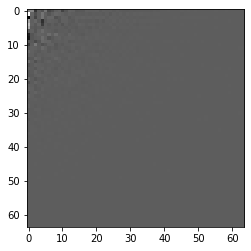

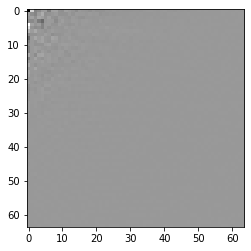

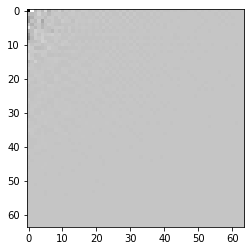

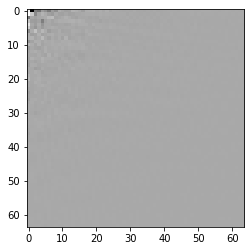

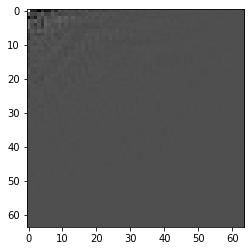

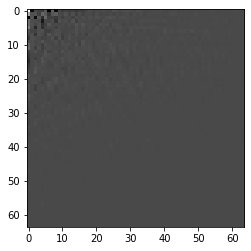

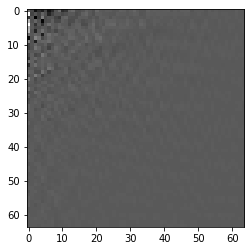

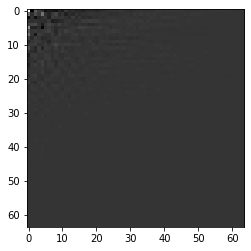

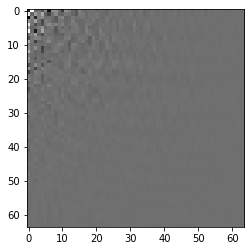

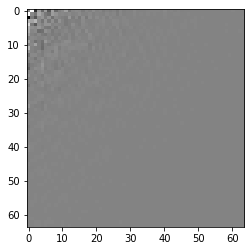

In [14]:
for i in range(10):
    tensor_to_picture(train_data[i][0][0])

In [71]:
for i in range(280):
    train_data[i] = dct.idct_2d(train_data[i])
    # train_data[i] = dct.idct_2d(imf)

In [19]:
for i in range(test_data.shape[0]):
    test_data[i] = dct.idct_2d(test_data[i])
    # train_data[i] = dct.idct_2d(imf)

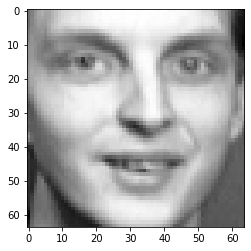

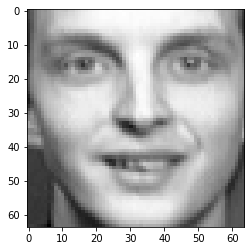

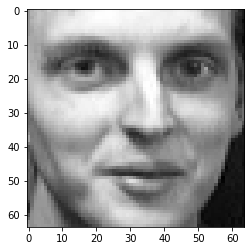

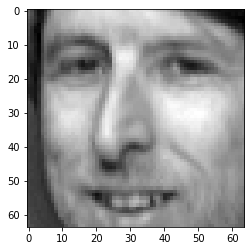

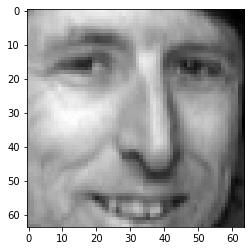

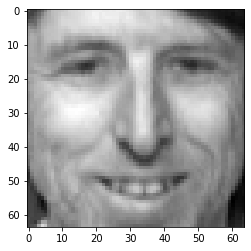

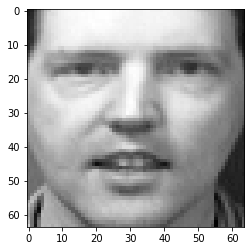

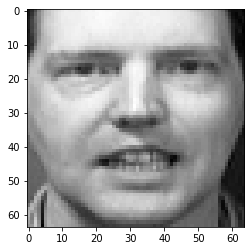

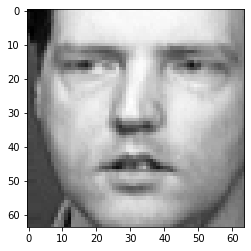

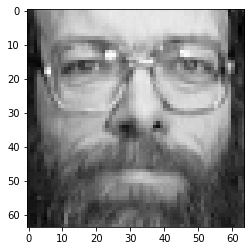

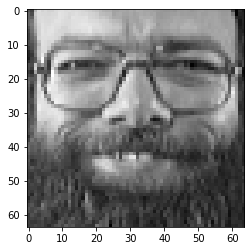

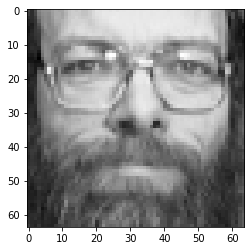

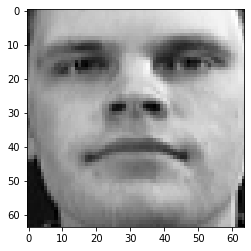

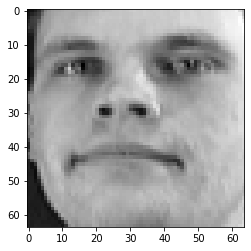

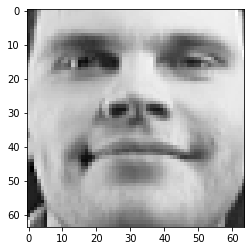

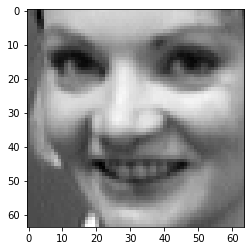

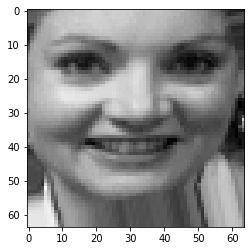

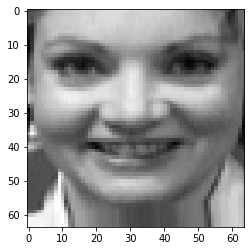

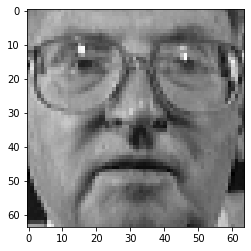

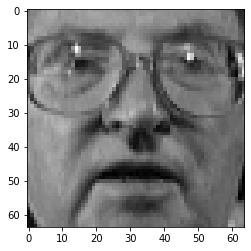

In [20]:
for i in range(20):
    tensor_to_picture(test_data[i][0][0])